In [126]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [127]:
def read_one_image(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return (img, filename.split("./data/")[1])


def read_images(filename=None):
    filename = "./data/{}.jpeg".format(filename) if filename is not None else "./data/*.*"
    return [read_one_image(file) for file in glob.glob(filename)]

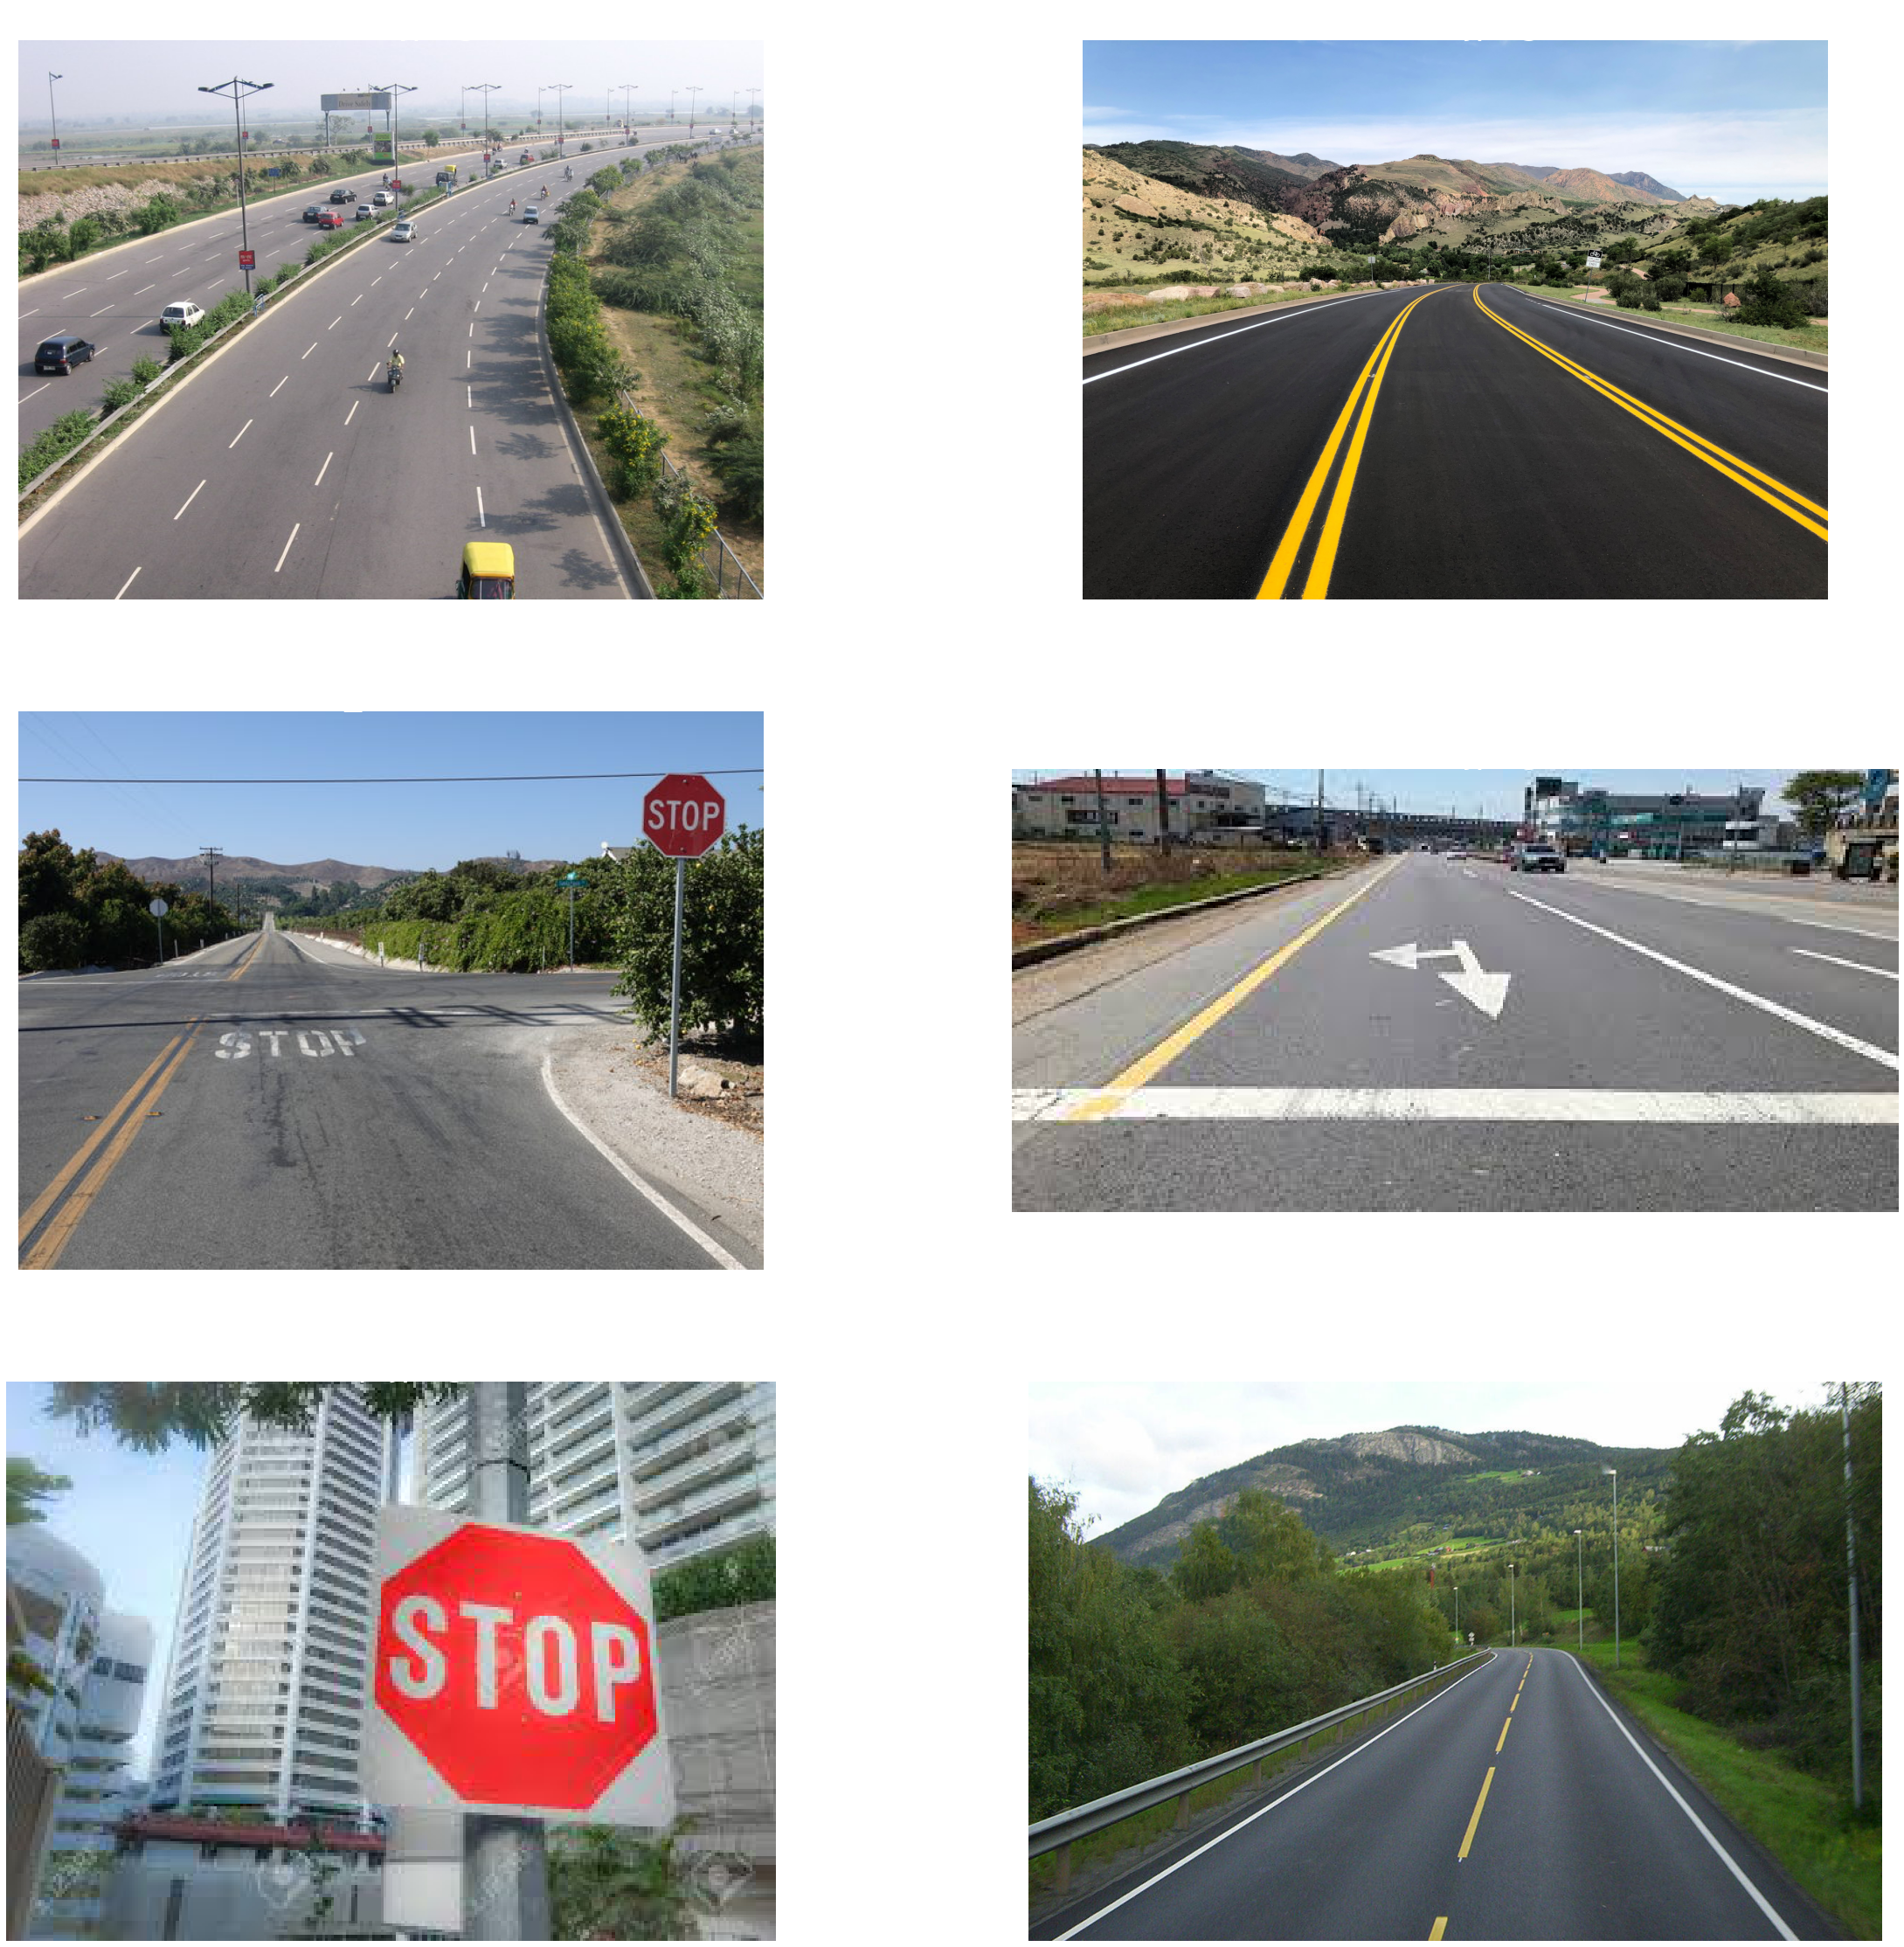

In [128]:

def show_images(images, title="", cmap=None):
    subplot_rows = 3 if len(images) > 1 else 1
    subplot_cols = 2 if len(images) > 1 else 1
    plt.subplots(subplot_rows, subplot_cols, figsize=(40, 40))
    for i, (img, filename) in enumerate(images):
        plt.subplot(subplot_rows, subplot_cols, i + 1)
        plt.axis("off")
        plt.title("{} {}".format(filename, title), fontsize=40, color='white')
        if cmap:
            plt.imshow(img, cmap)
        else:
            plt.imshow(img)


images = show_images(read_images())

In [129]:
def apply(images, fun, show=False, cmap=None, *args, **kwargs):
    new_images = [(fun(img, *args, **kwargs), filename) for (img,filename) in images]
    if show:
        show_images(new_images, cmap)
    return new_images

In [130]:

def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


gray_images = apply(images, gray_scale, cmap='gray')

In [131]:
# def image_segmentation_using_k_means(image):
#     image = image.reshape((-1, 3))
#     image = np.float32(image)
#
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
#     K = 3
#     attempts = 10
#
#     ret, label, center = cv2.kmeans(image, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
#     center = np.uint8(center)
#     res = center[label.flatten()]
#     result_image = res.reshape((image.shape))
#     return result_image
#
# #apply(images, image_segmentation_using_k_means)

In [132]:
# def image_segmentation_using_contours(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     _, thresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_BINARY_INV)
#     edges = cv2.dilate(cv2.Canny(thresh, 0, 255), None)
#
#     cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
#     mask = np.zeros((256, 256), np.uint8)
#     masked = cv2.drawContours(mask, [cnt], -1, 255, -1)
#
#     dst = cv2.bitwise_and(image, image, mask=mask)
#     segmented = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
#     return segmented
#
#
# apply(images, image_segmentation_using_contours)

In [133]:
# def filter_image(image, mask):
#     r = image[:,:,0] * mask
#     g = image[:,:,1] * mask
#     b = image[:,:,2] * mask
#     return np.dstack([r,g,b])
#
# def image_segmentation_using_otsu(image):
#     gray_img = gray_scale(image)
#     thresh = threshold_otsu()
#     img_otsu  = gray_img < thresh
#     return filter_image(image, img_otsu)
#
# apply(images, image_segmentation_using_otsu)


In [134]:
def image_segmentation_using_color_masking(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    delta_low = 40
    delta_high = 20
    low_color = (124 + delta_low, 118 + delta_low, 120 + delta_low)
    high_color = (69 - delta_high, 82 - delta_high, 90 - delta_high)

    mask = cv2.inRange(hsv_img, high_color, low_color)
    result = cv2.bitwise_and(image, image, mask=mask)
    return result

In [135]:
def gaussian_blurring(image, kernel_size):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), cv2.BORDER_CONSTANT)

In [166]:
def canny_edge_detection(image):
    return cv2.Canny(image, 50, 200)

In [137]:
def crop_images(image, crop_ratio):
    curr_rows = image.shape[0]
    new_rows = int(curr_rows * crop_ratio)
    return image[new_rows:, :, :]

In [138]:
def dilation(image, kernel_size, iterations):
    return cv2.dilate(image, np.ones((kernel_size, kernel_size), np.uint8), iterations)

In [139]:
def thresholding(gray_image):
    ret, thresh1 = cv2.threshold(gray_image, 120, 255, cv2.THRESH_BINARY +
                                 cv2.THRESH_OTSU)
    return thresh1

In [140]:
def hough_transform(gray_image):
    # Use canny edge detection
    edges = cv2.Canny(gray_image, 50, 150, apertureSize=3)

    # Apply HoughLinesP method to
    # to directly obtain line end points
    lines = cv2.HoughLinesP(
        edges,  # Input edge image
        1,  # Distance resolution in pixels
        np.pi / 180,  # Angle resolution in radians
        threshold=100,  # Min number of votes for valid line
        minLineLength=5,  # Min allowed length of line
        maxLineGap=10  # Max allowed gap between line for joining them
    )

    # Iterate over points
    for points in lines:
        # Extracted points nested in the list
        x1, y1, x2, y2 = points[0]
        # Draw the lines joing the points
        # On the original image
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Maintain a simples lookup list for points
        lines_list.append([(x1, y1), (x2, y2)])

/Users/neetesh/opt/anaconda3/envs/computer-vision/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


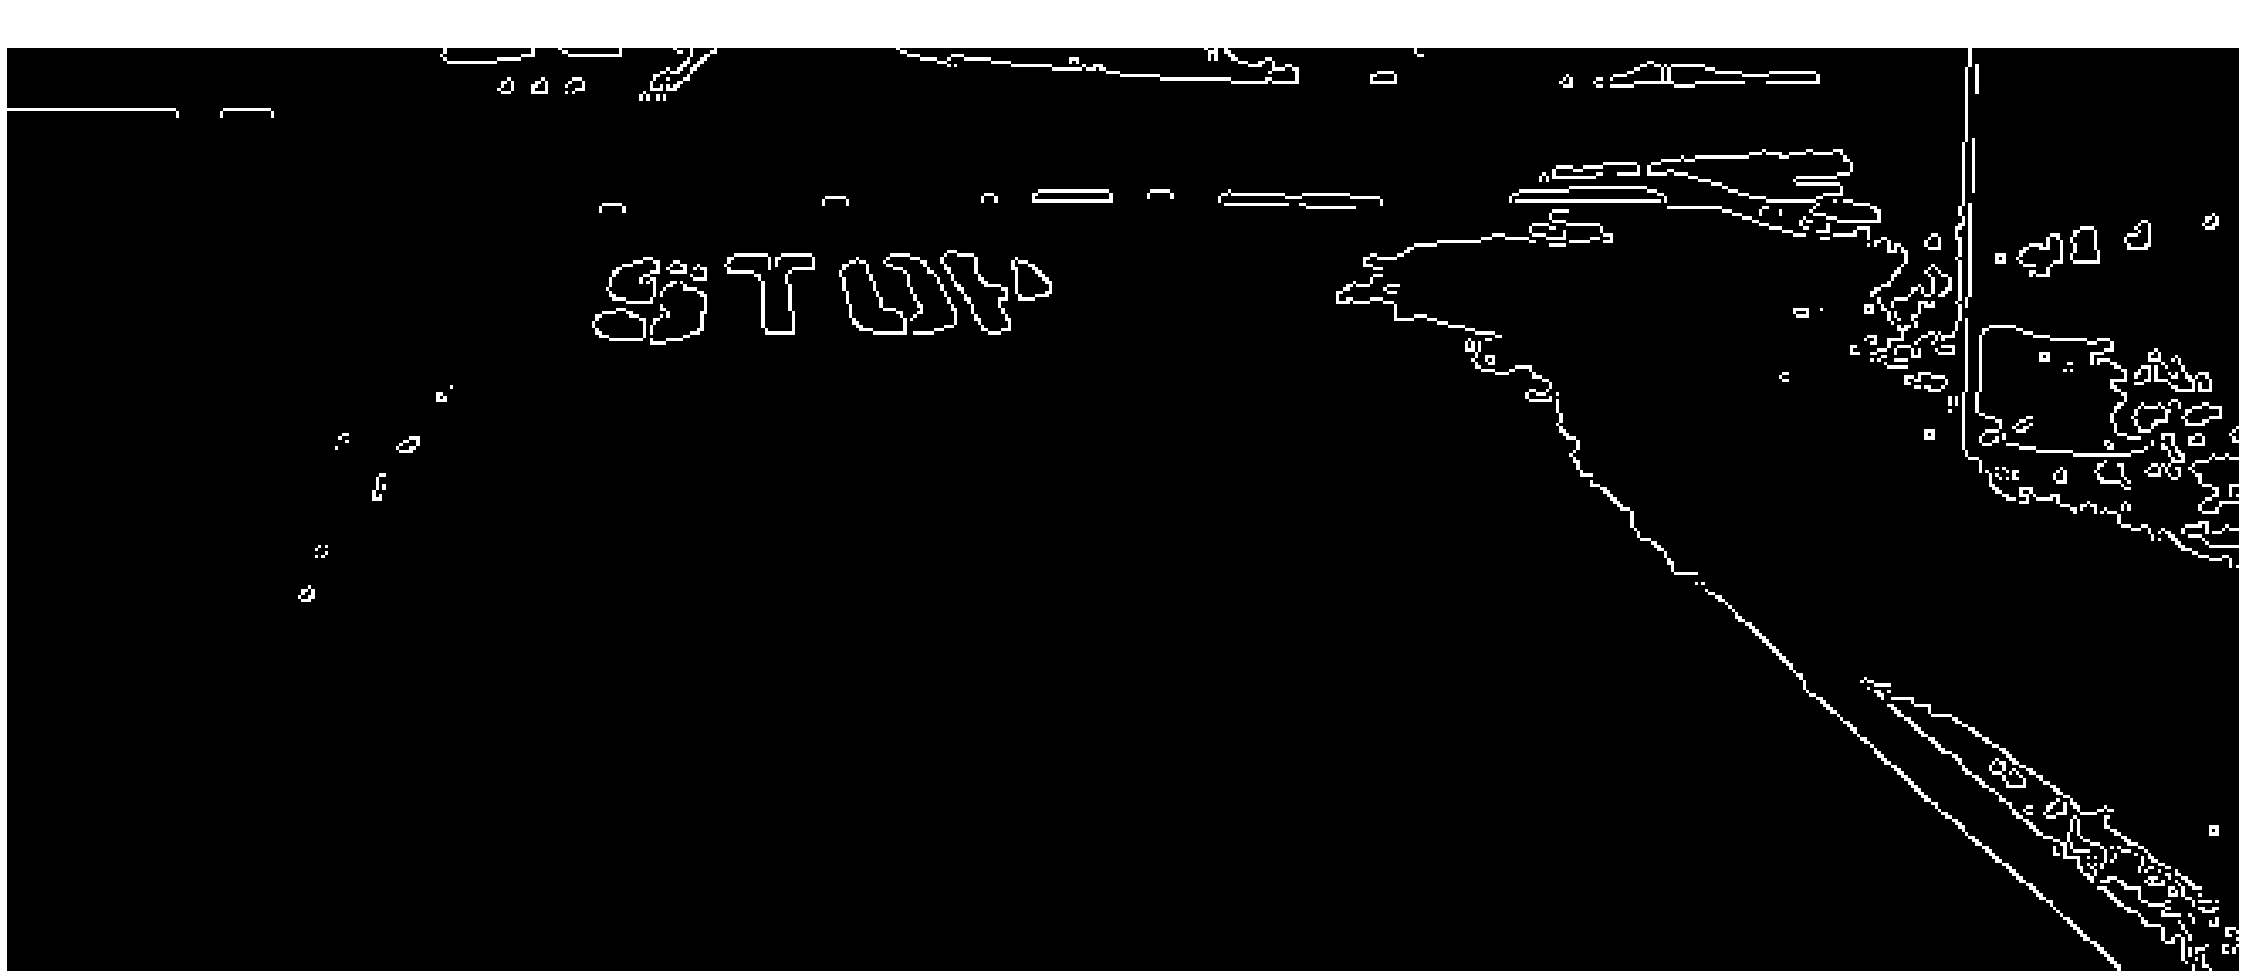

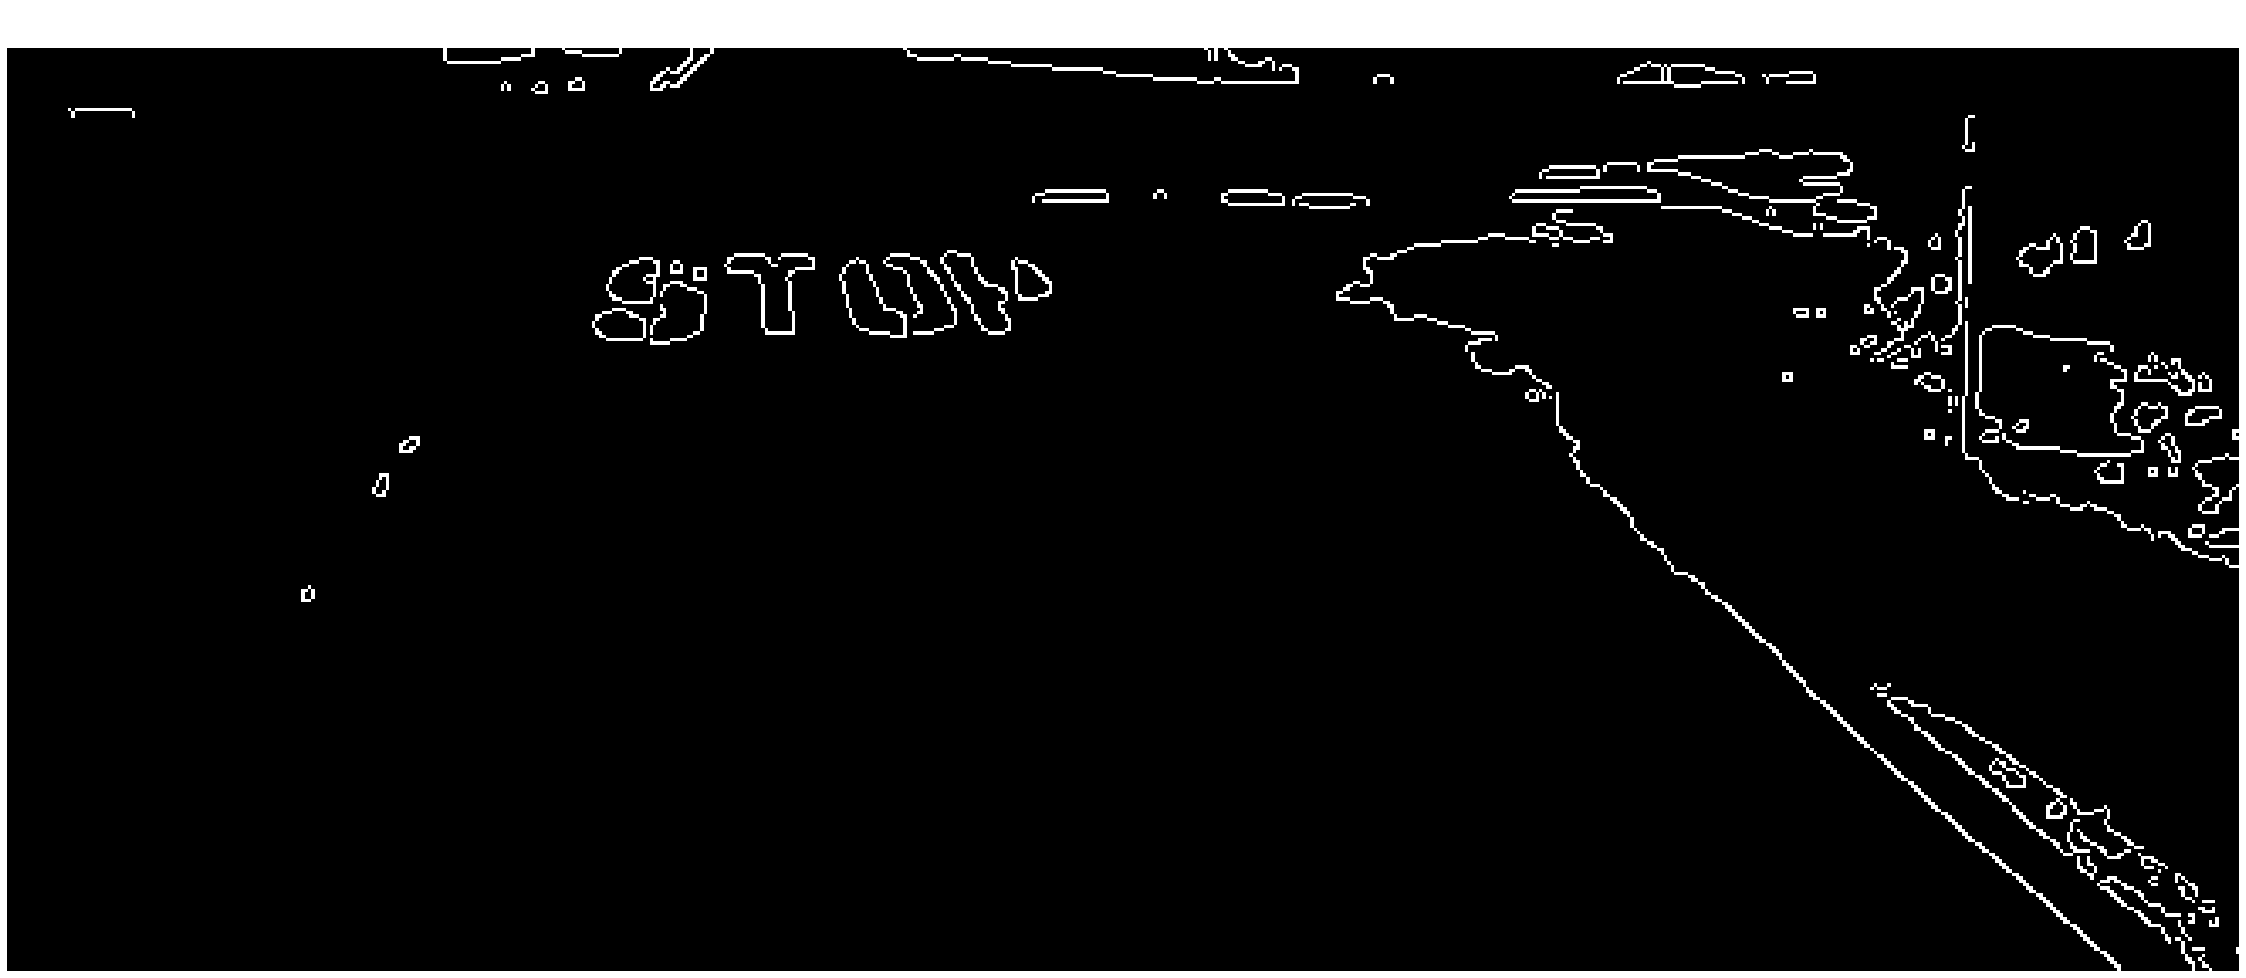

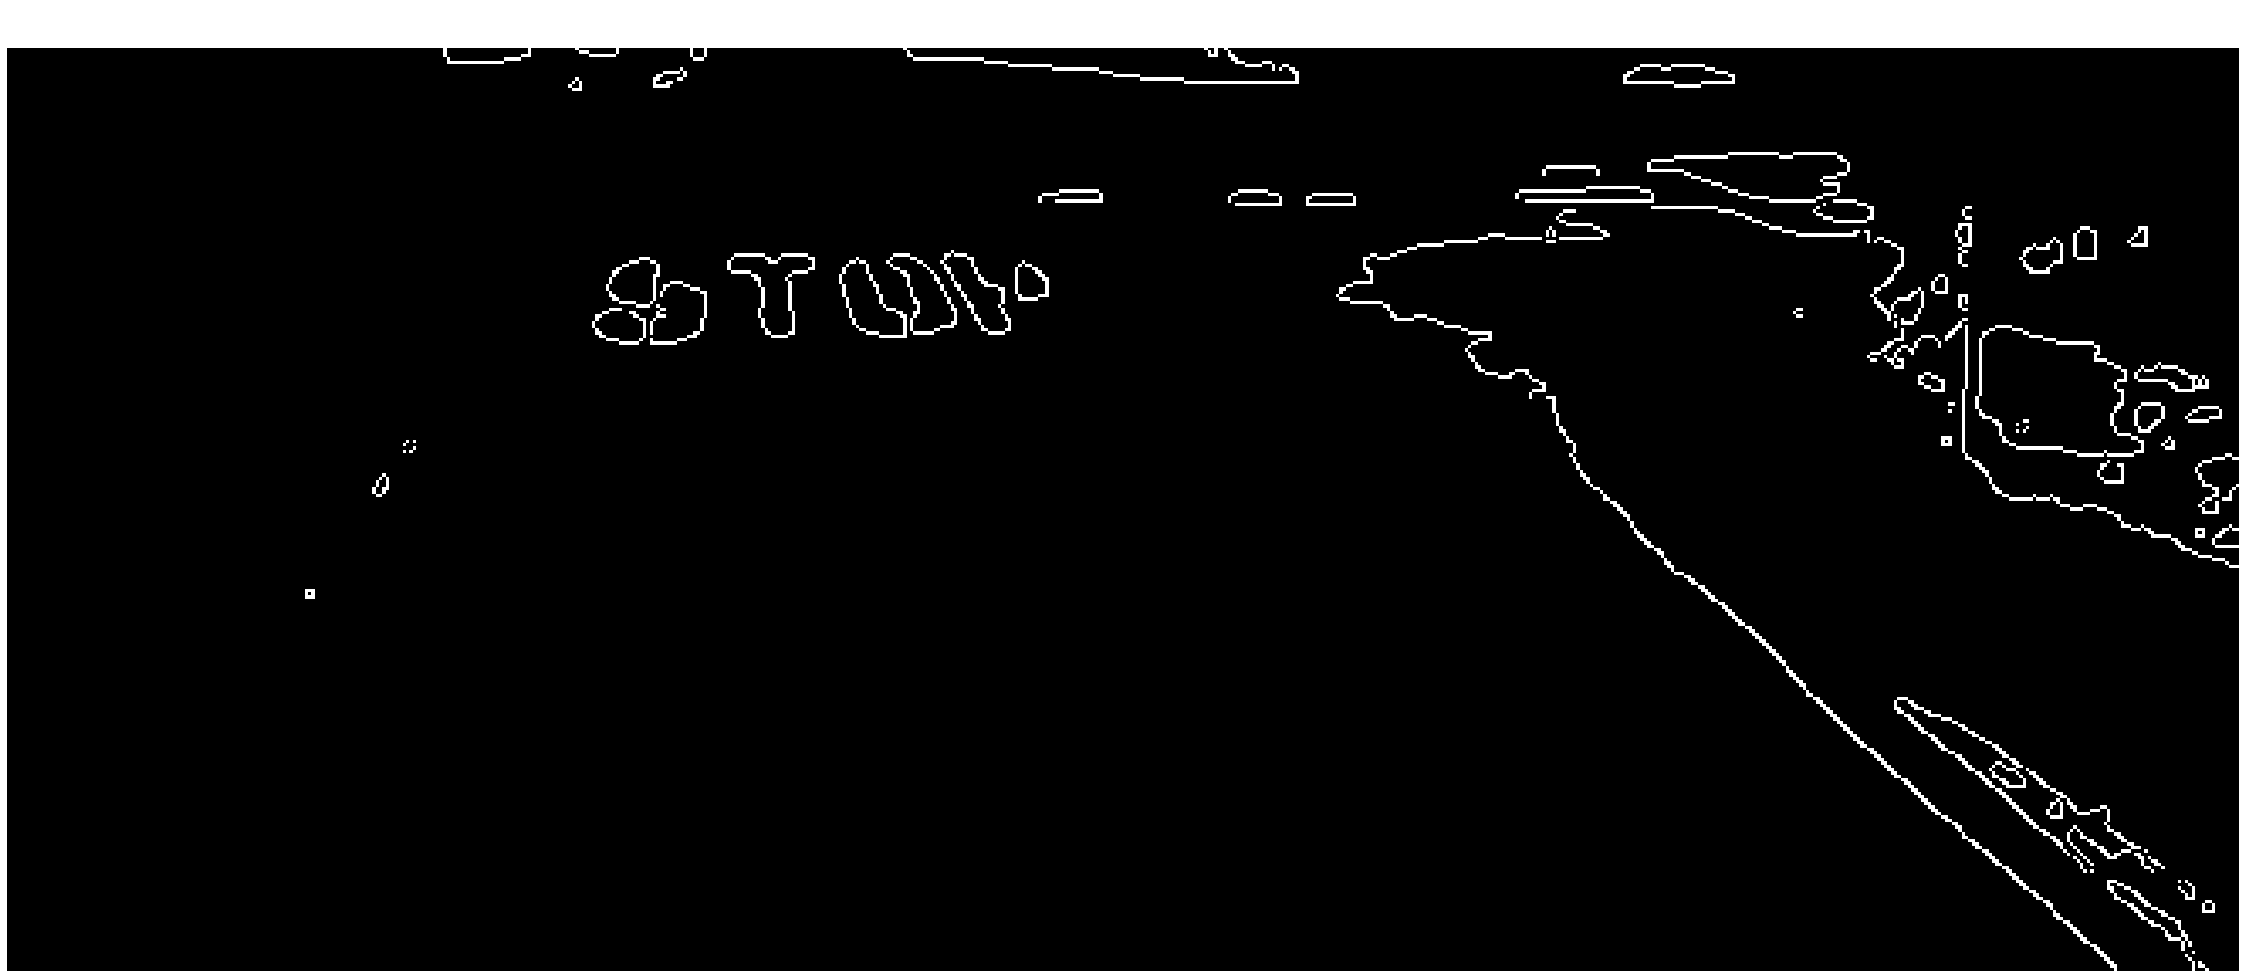

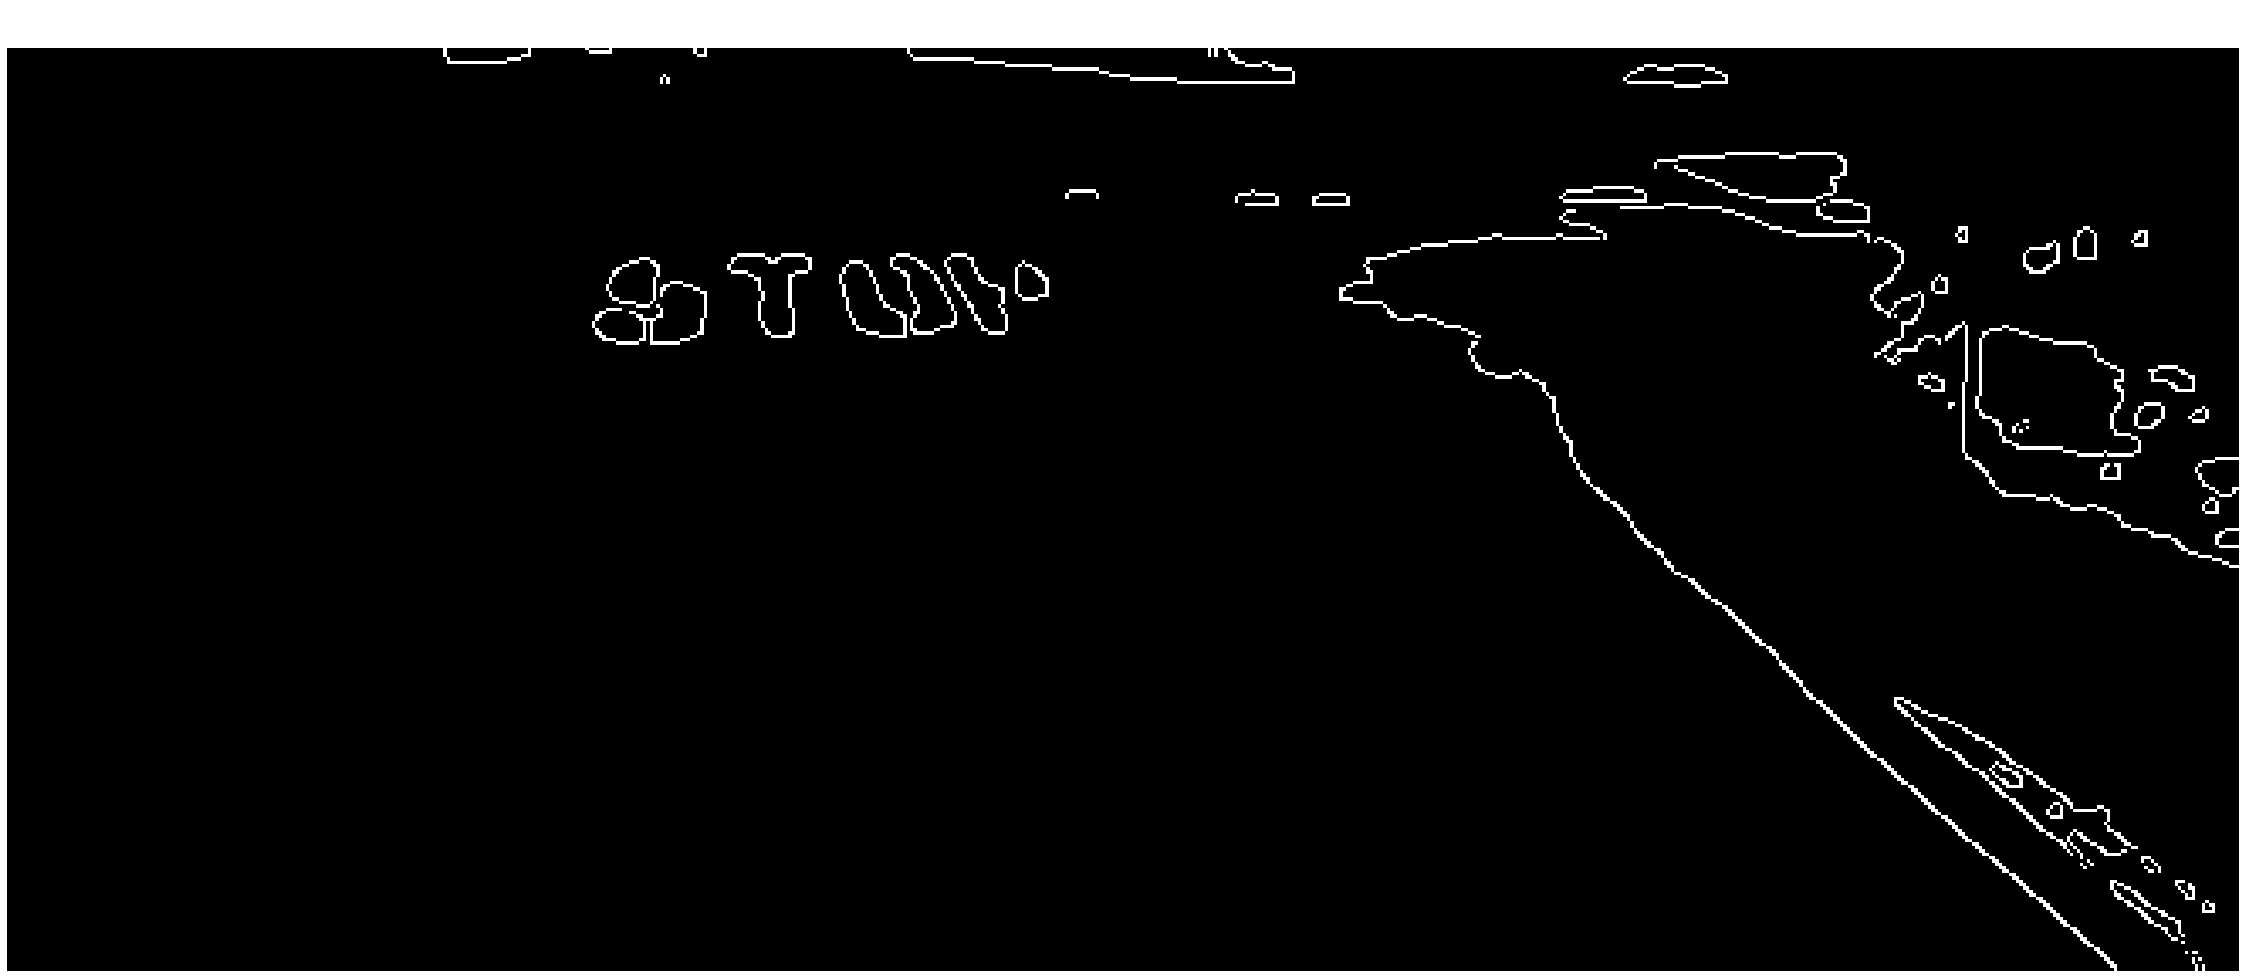

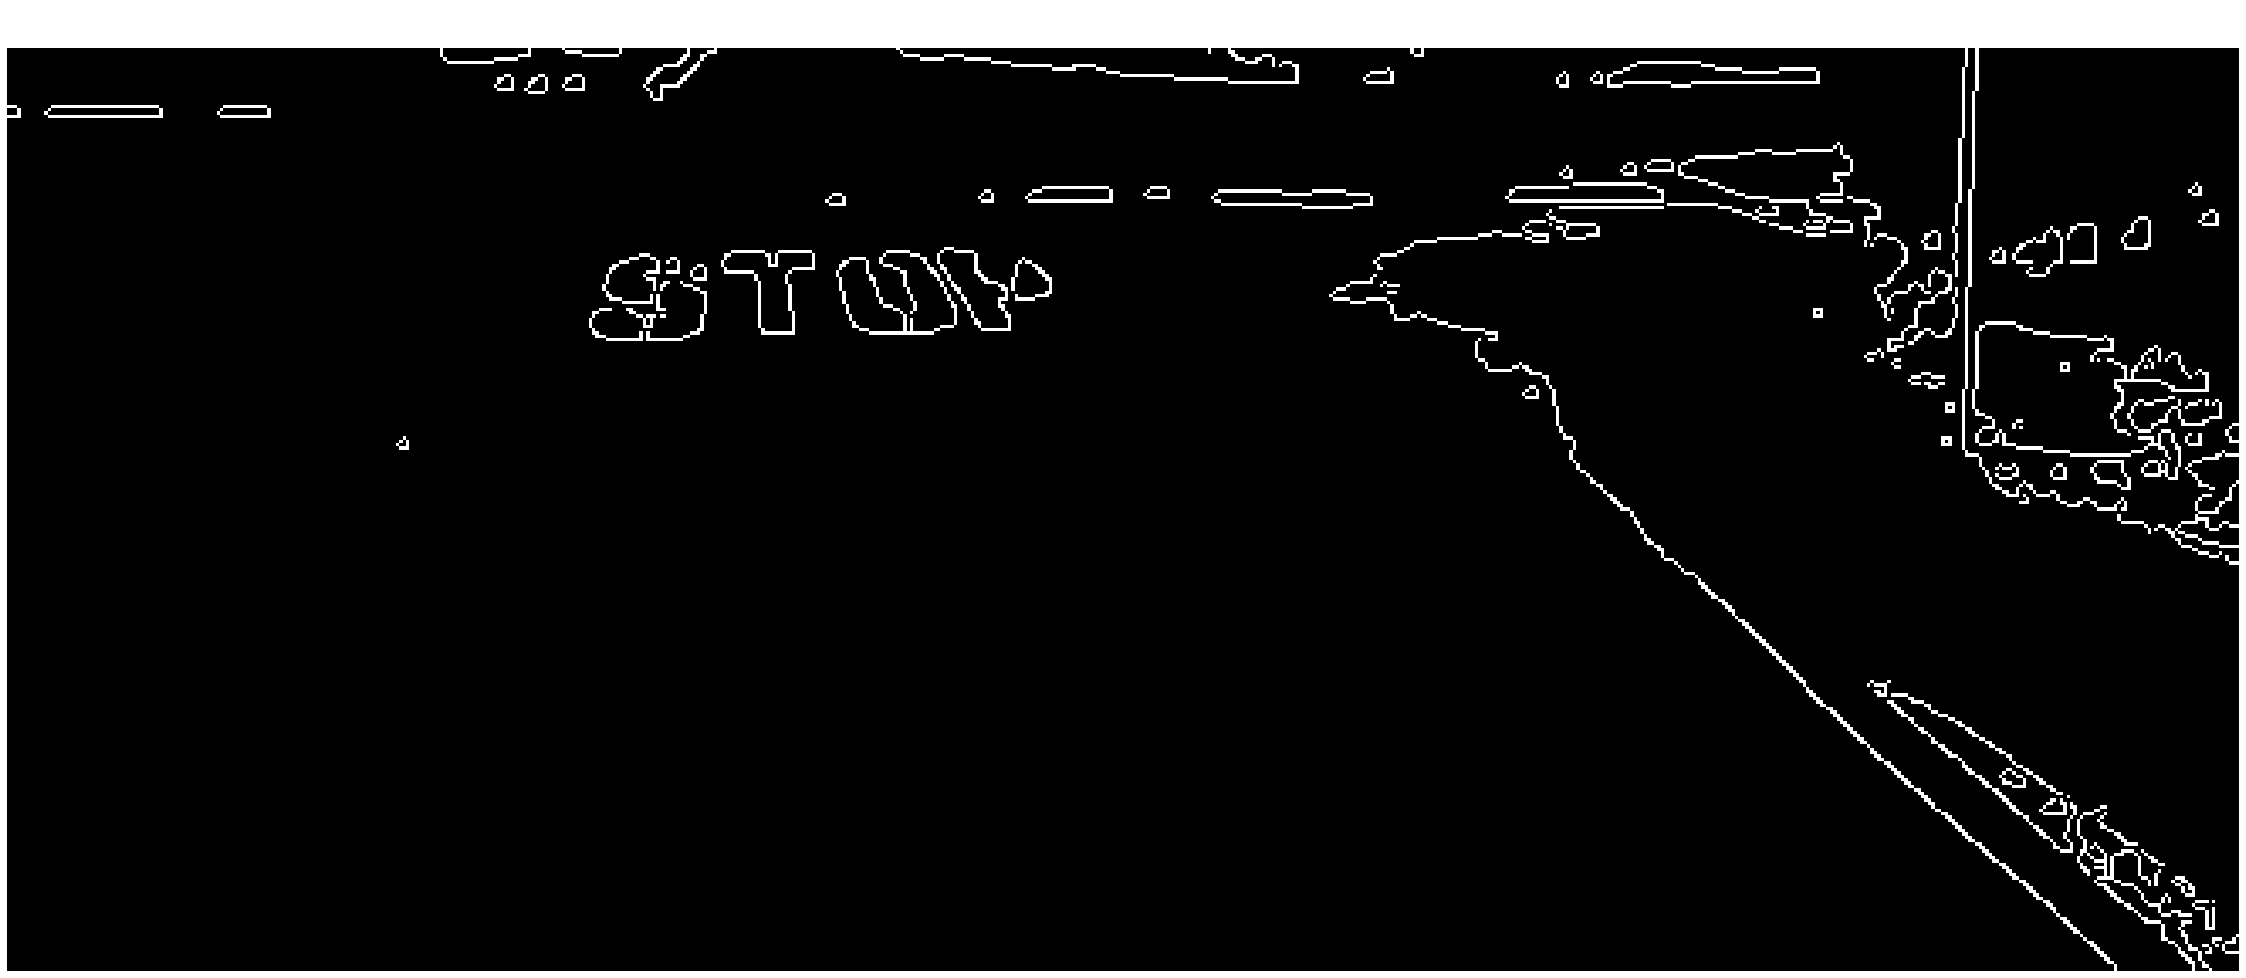

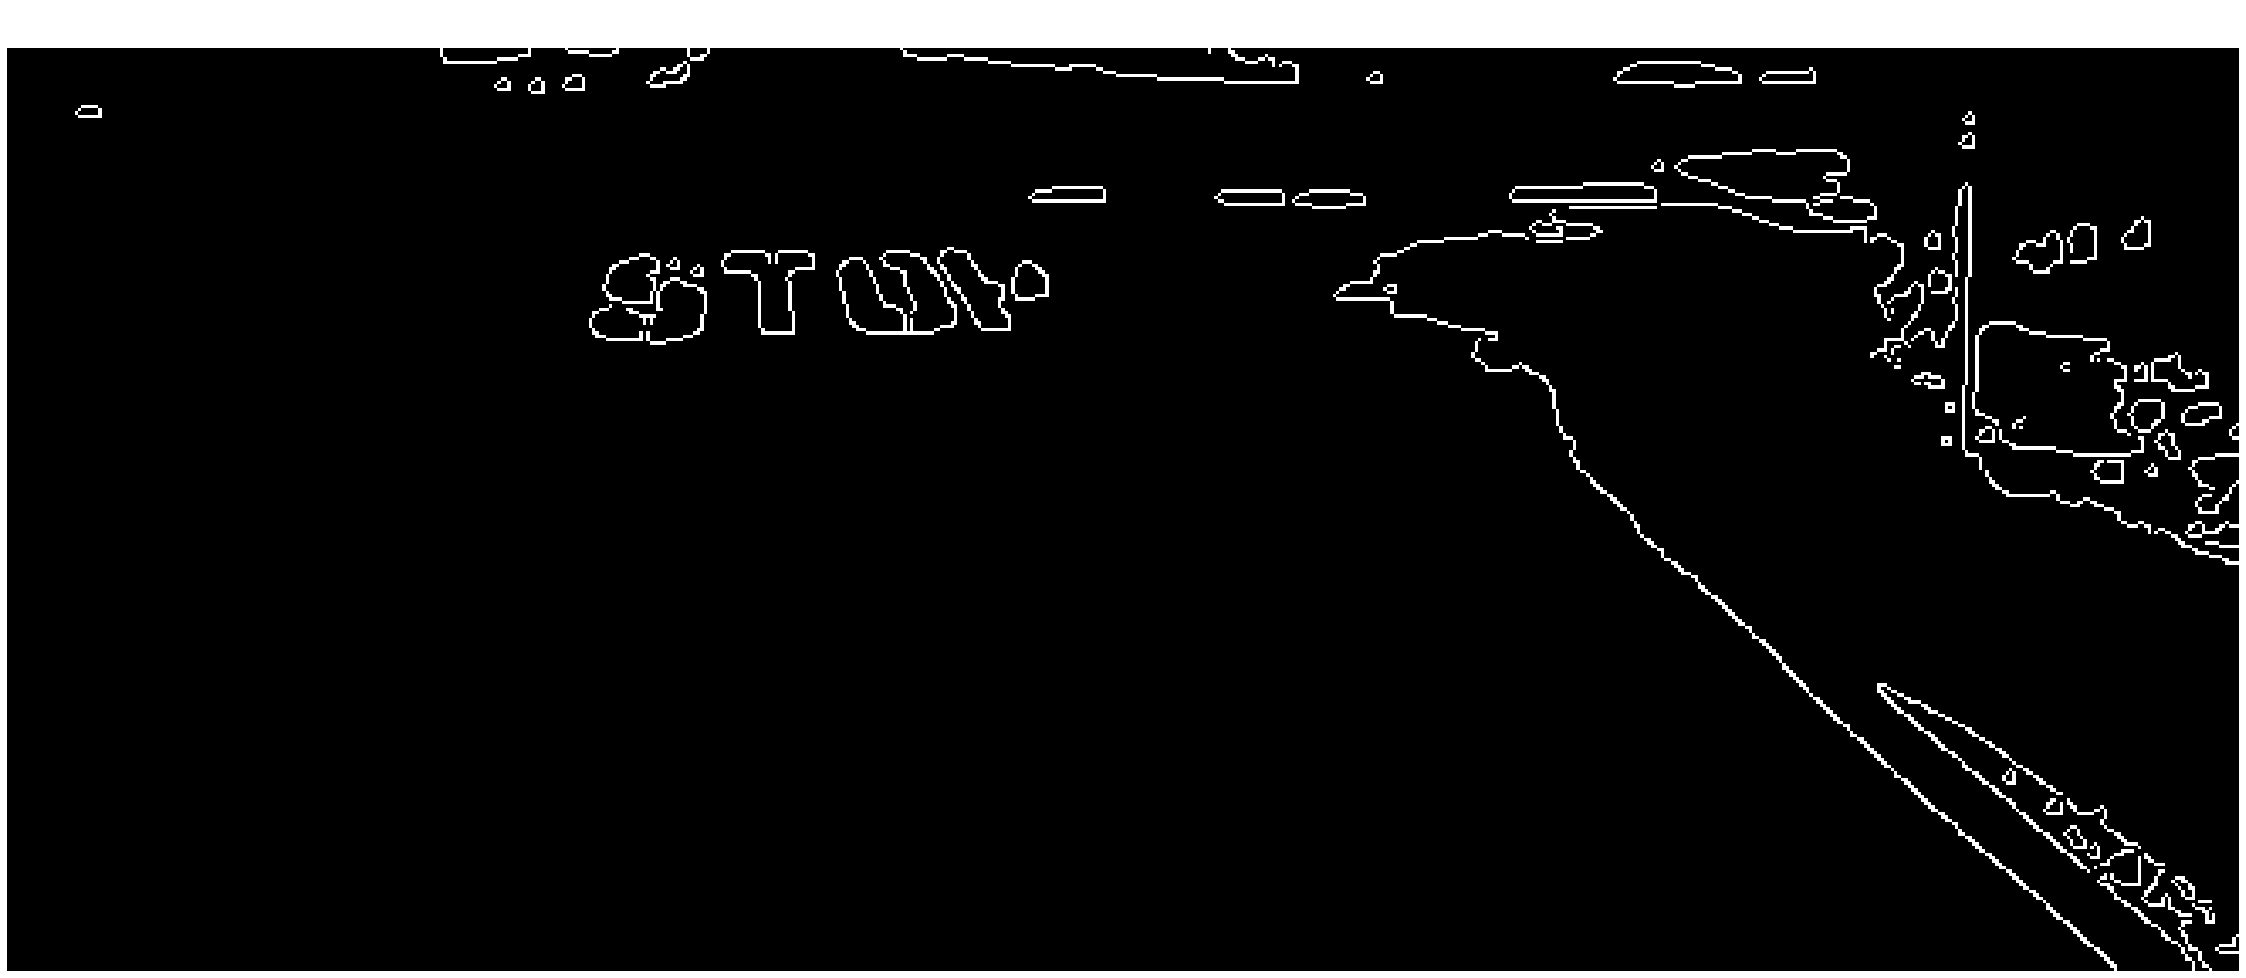

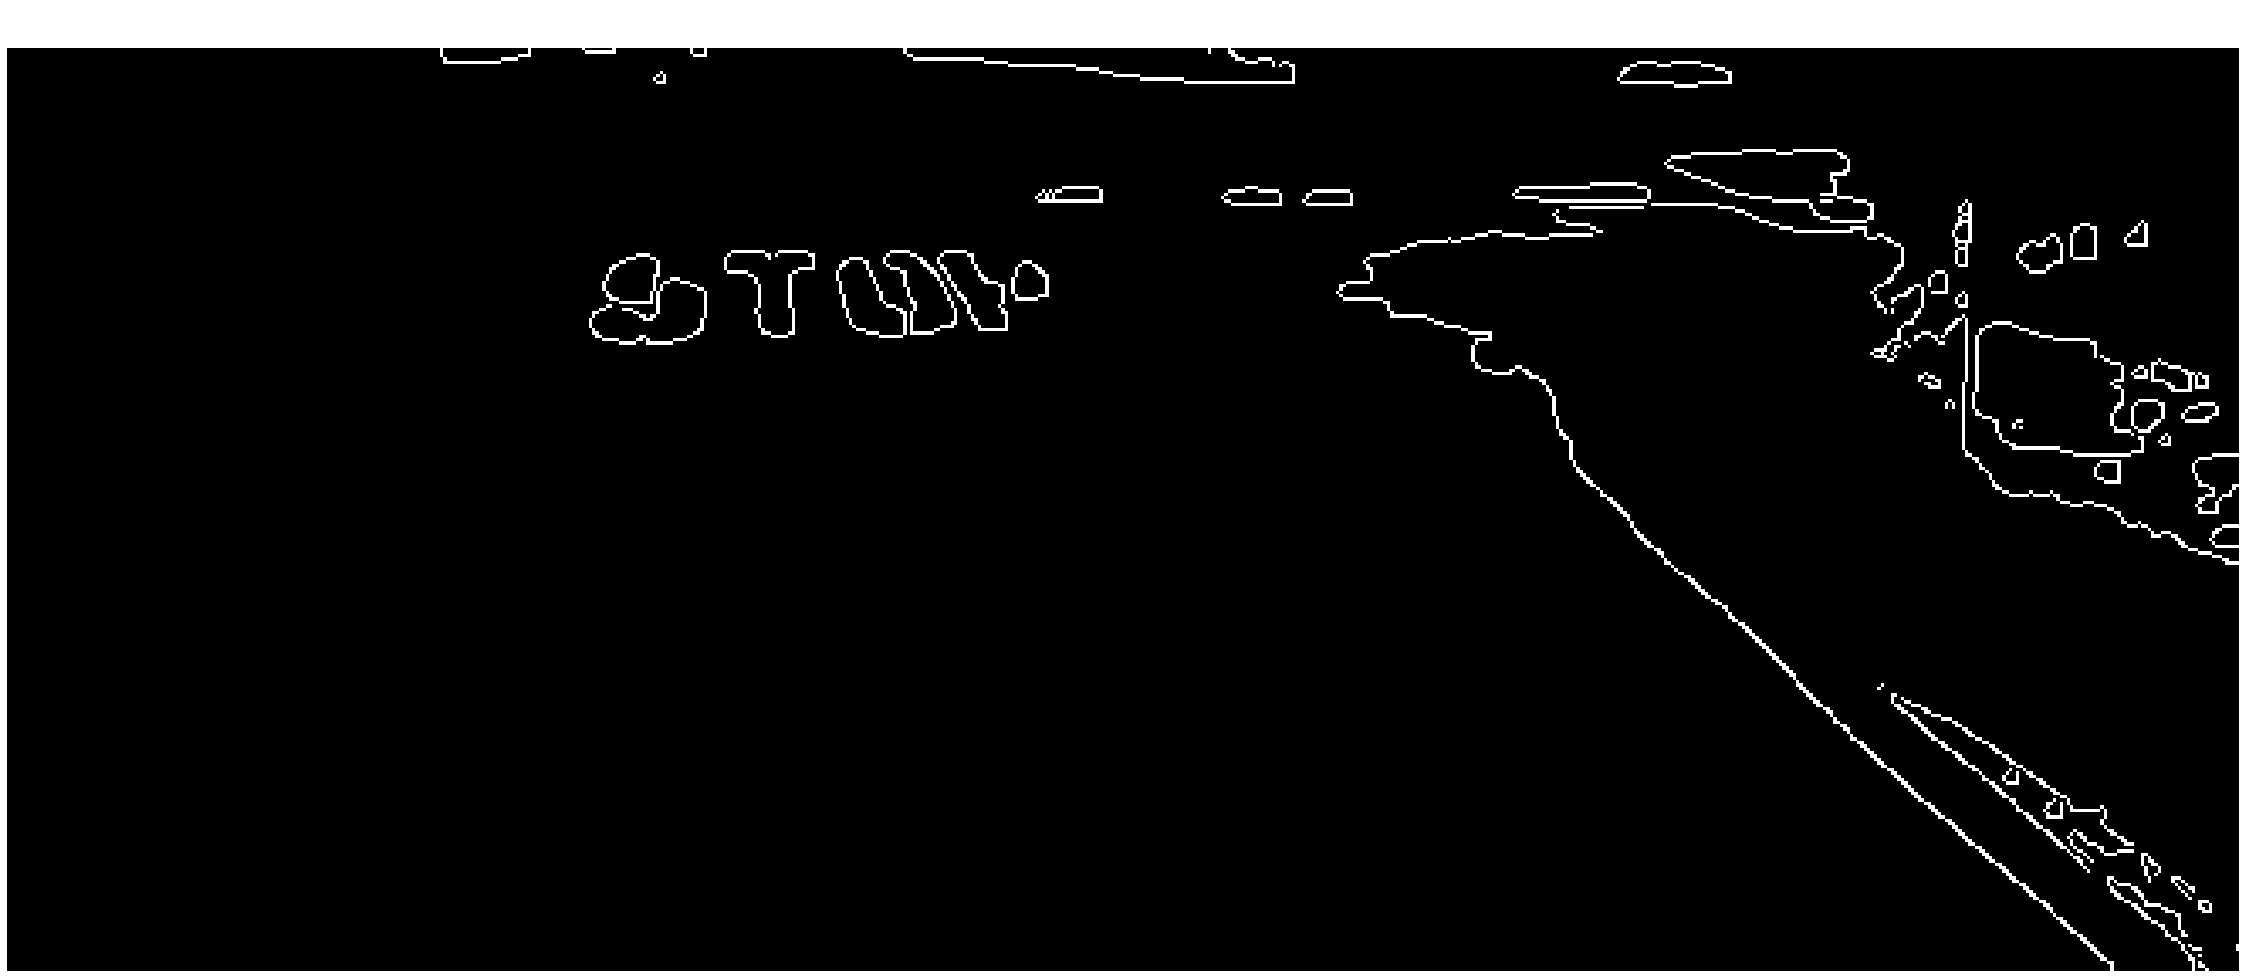

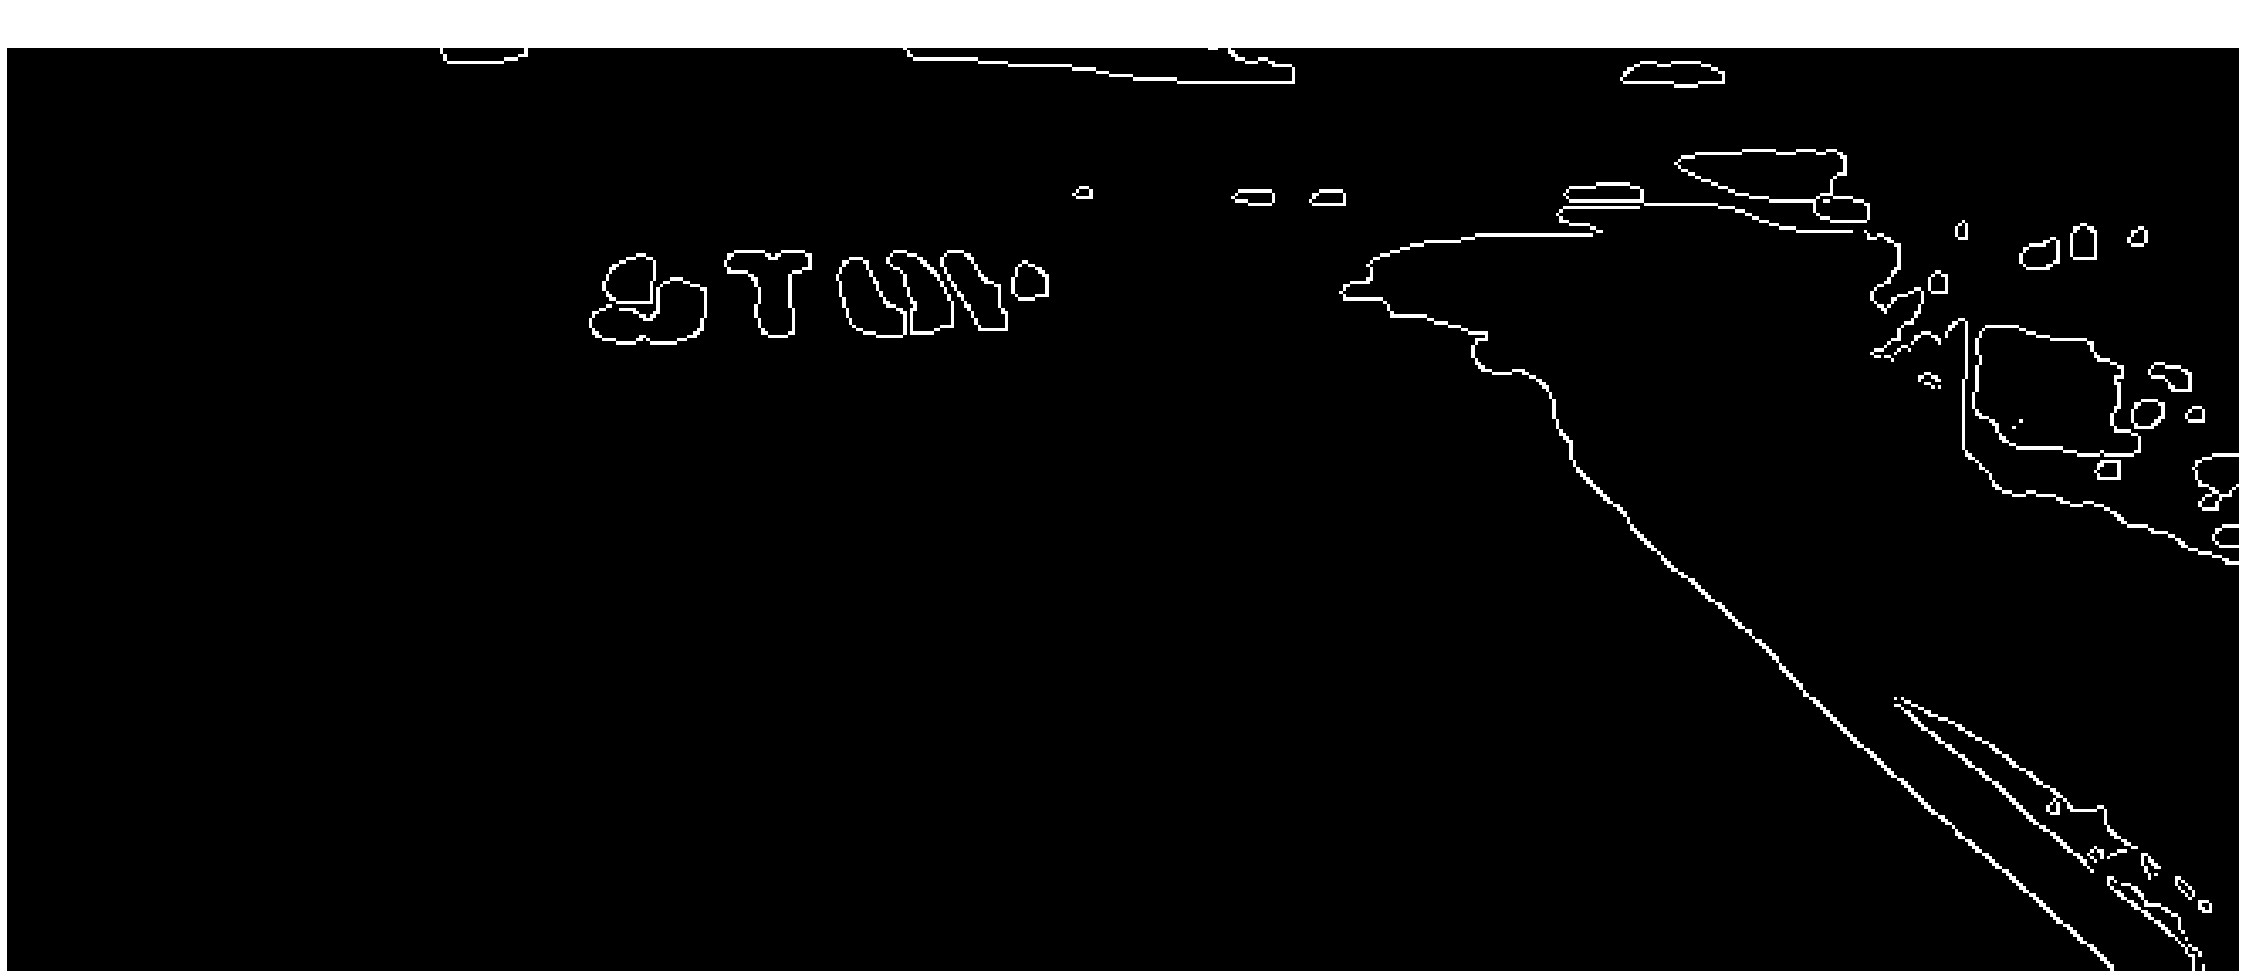

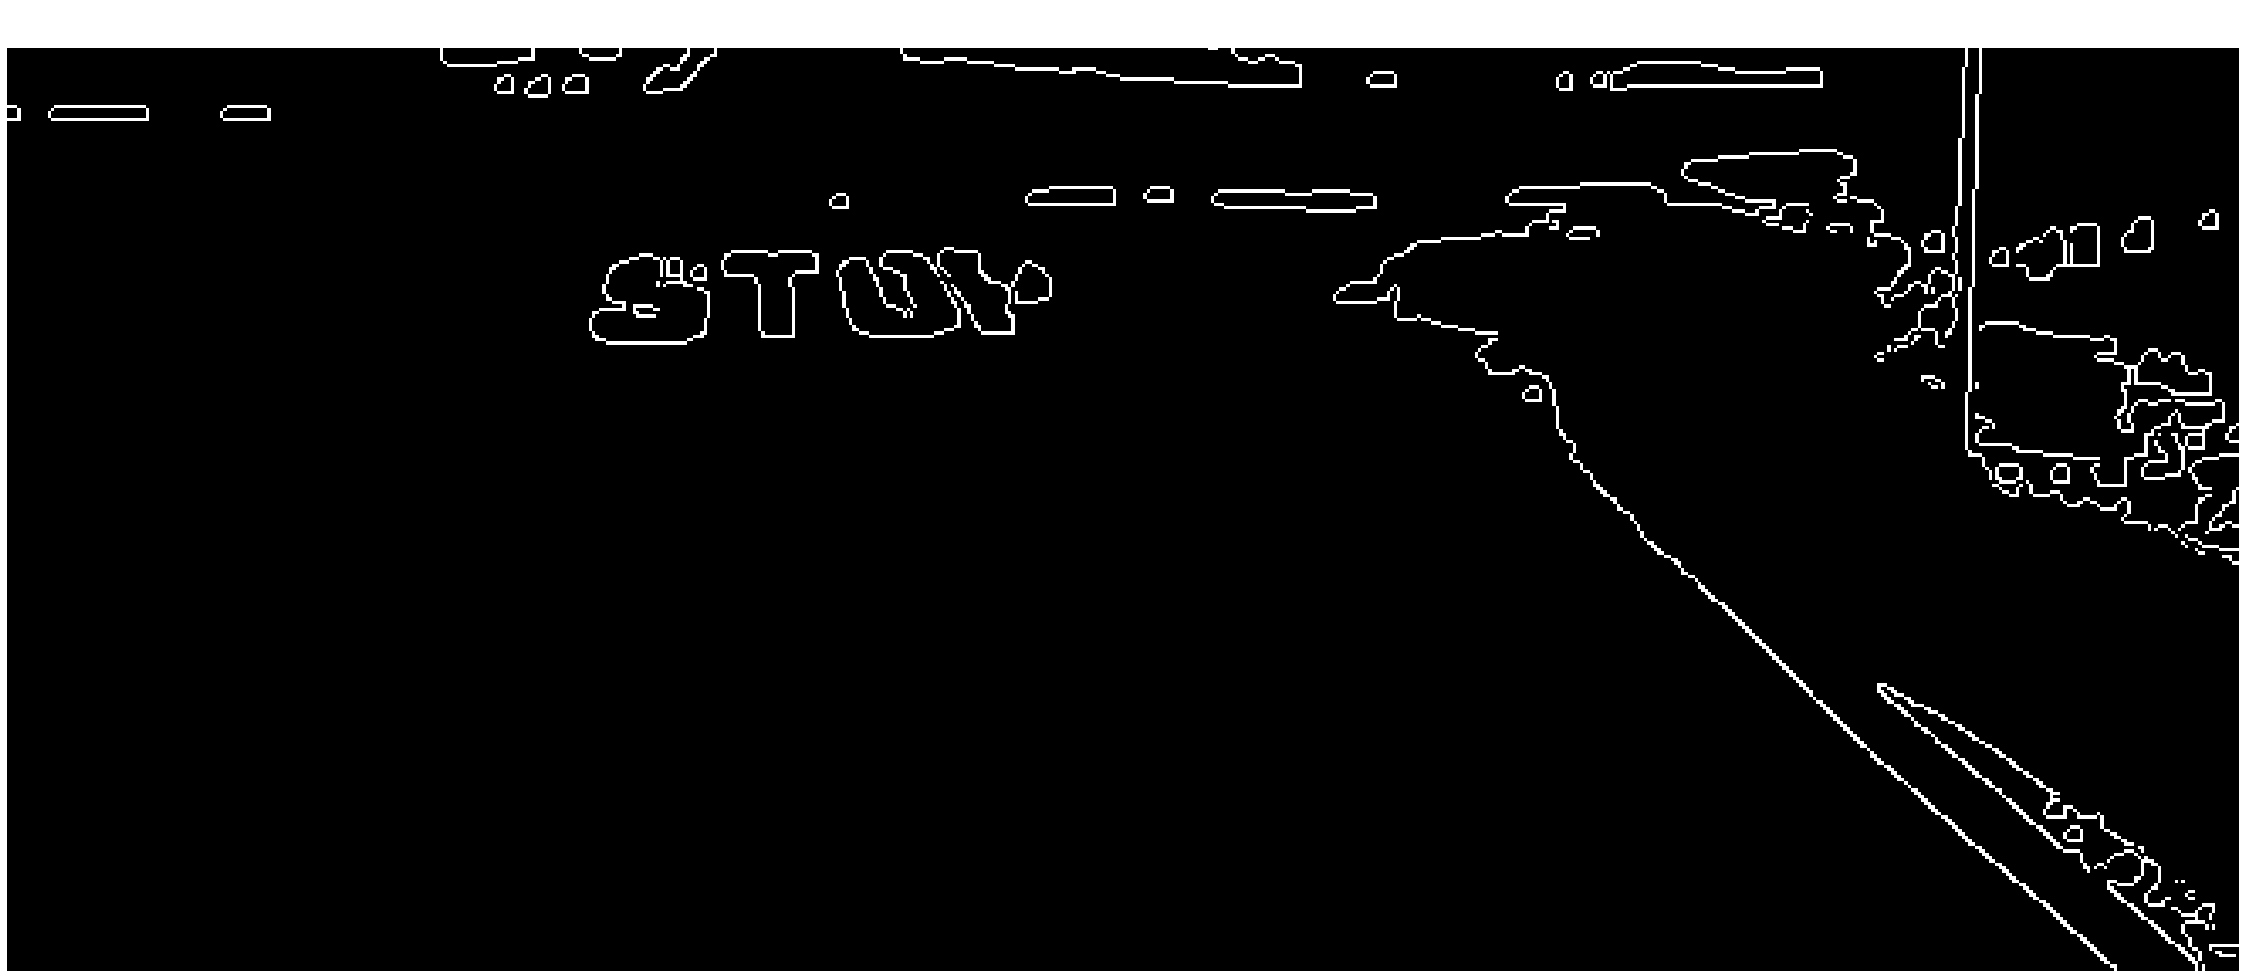

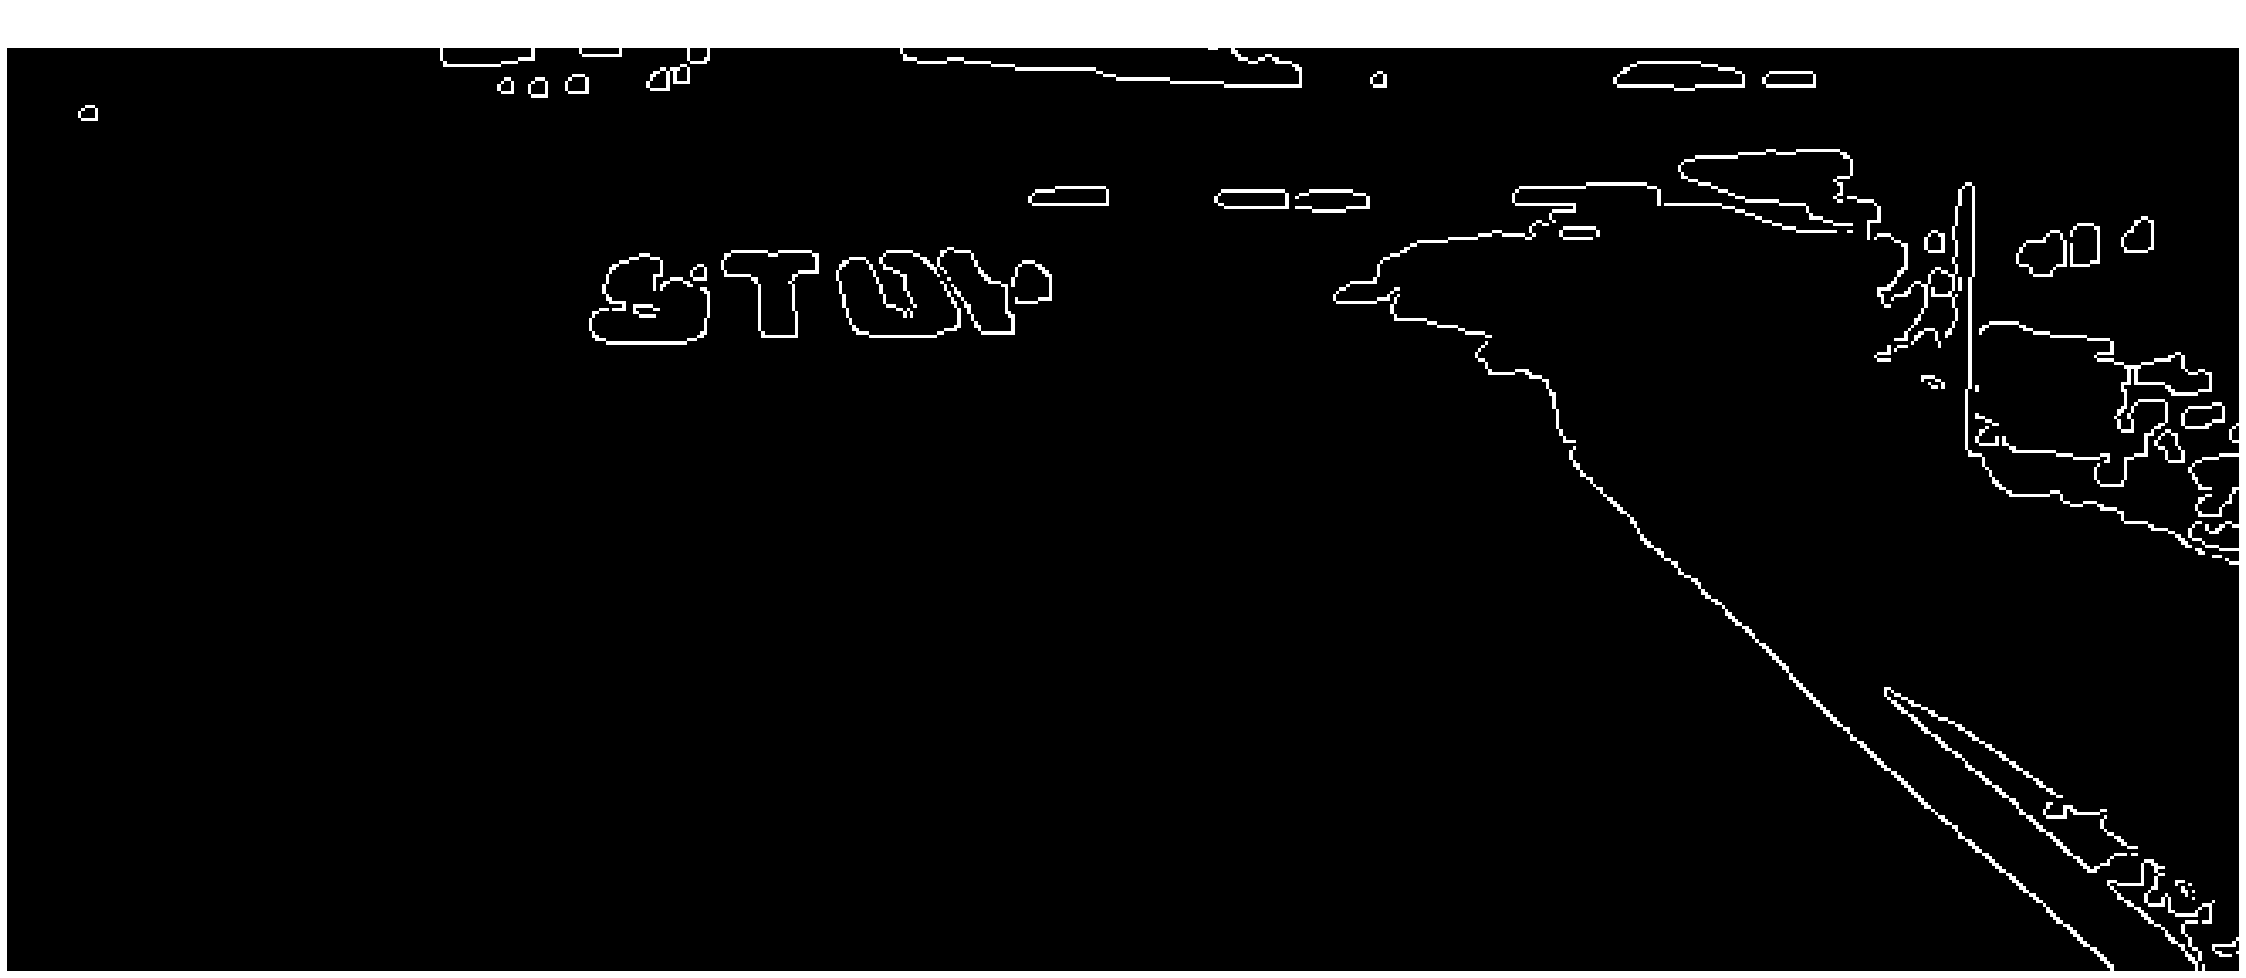

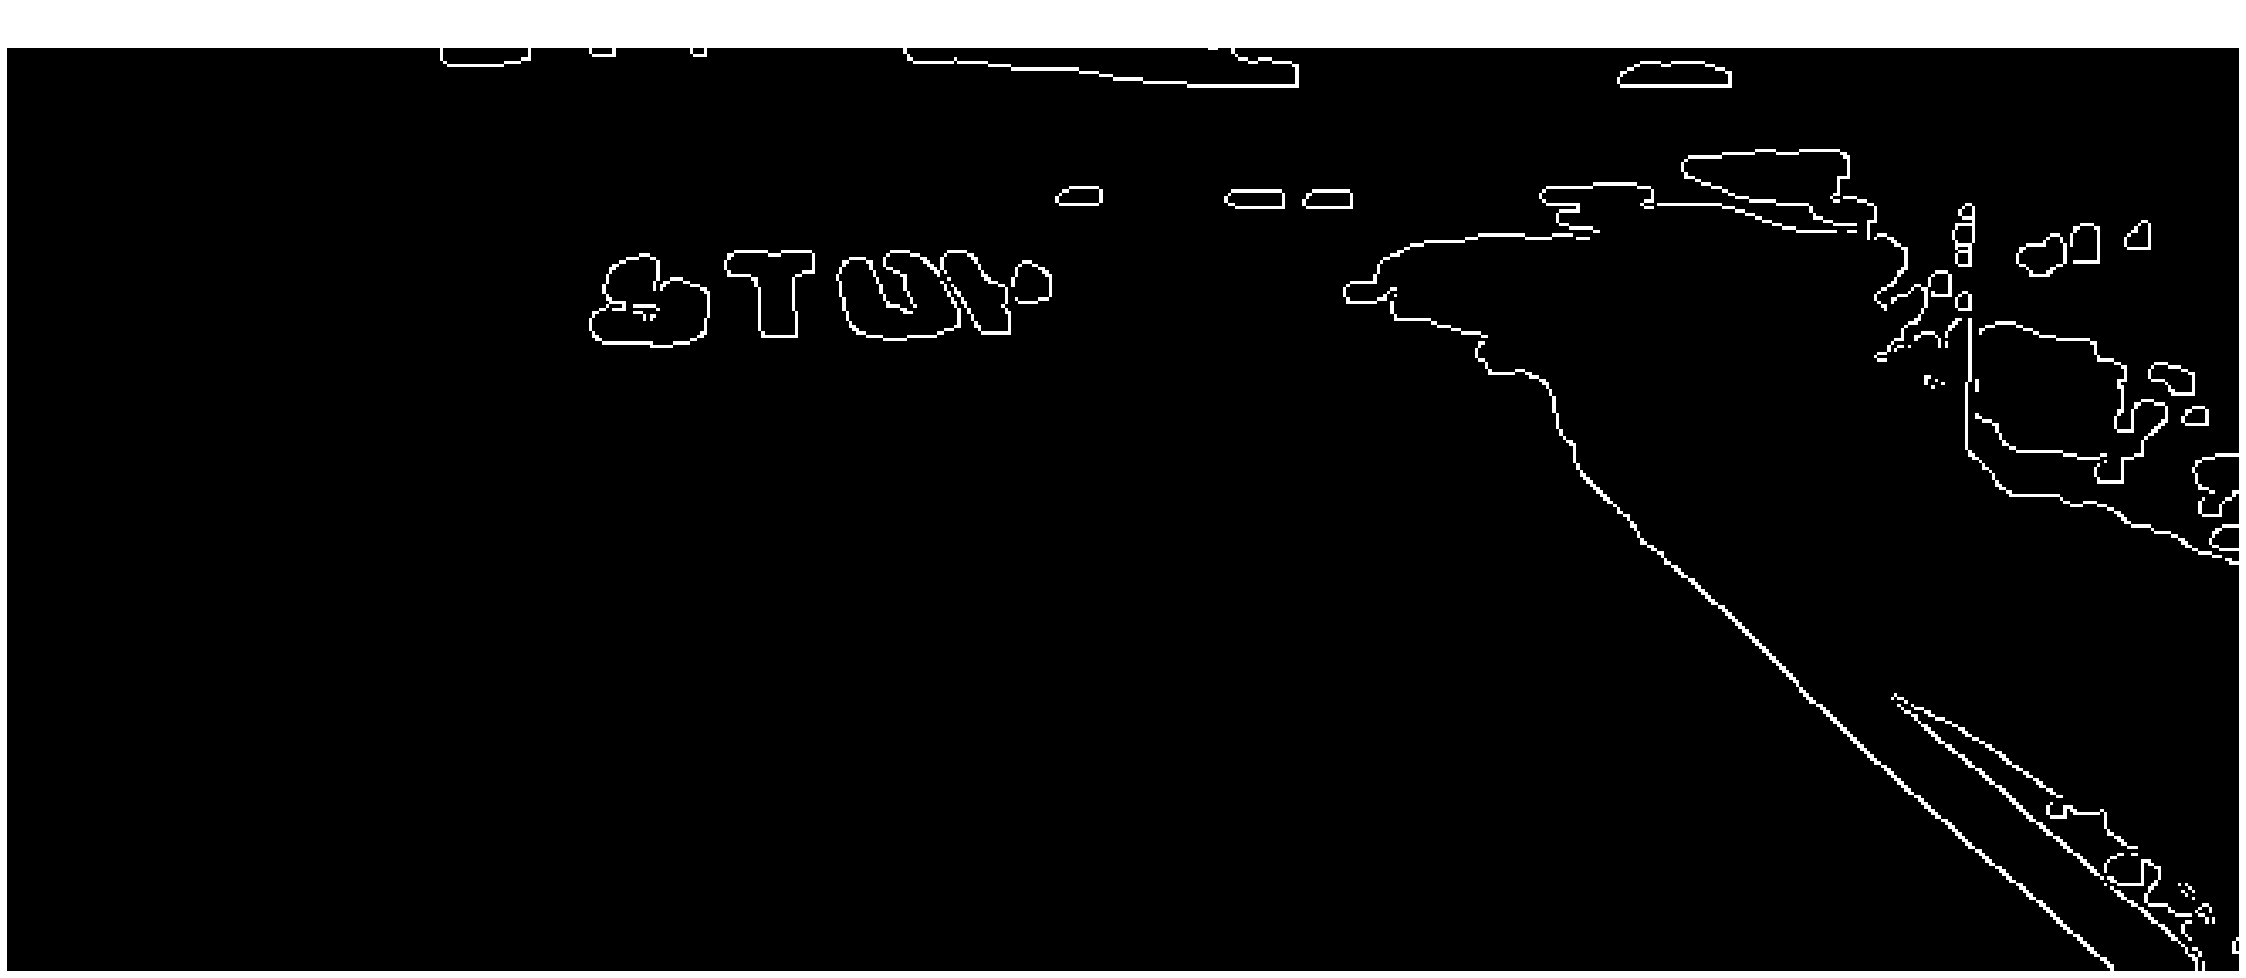

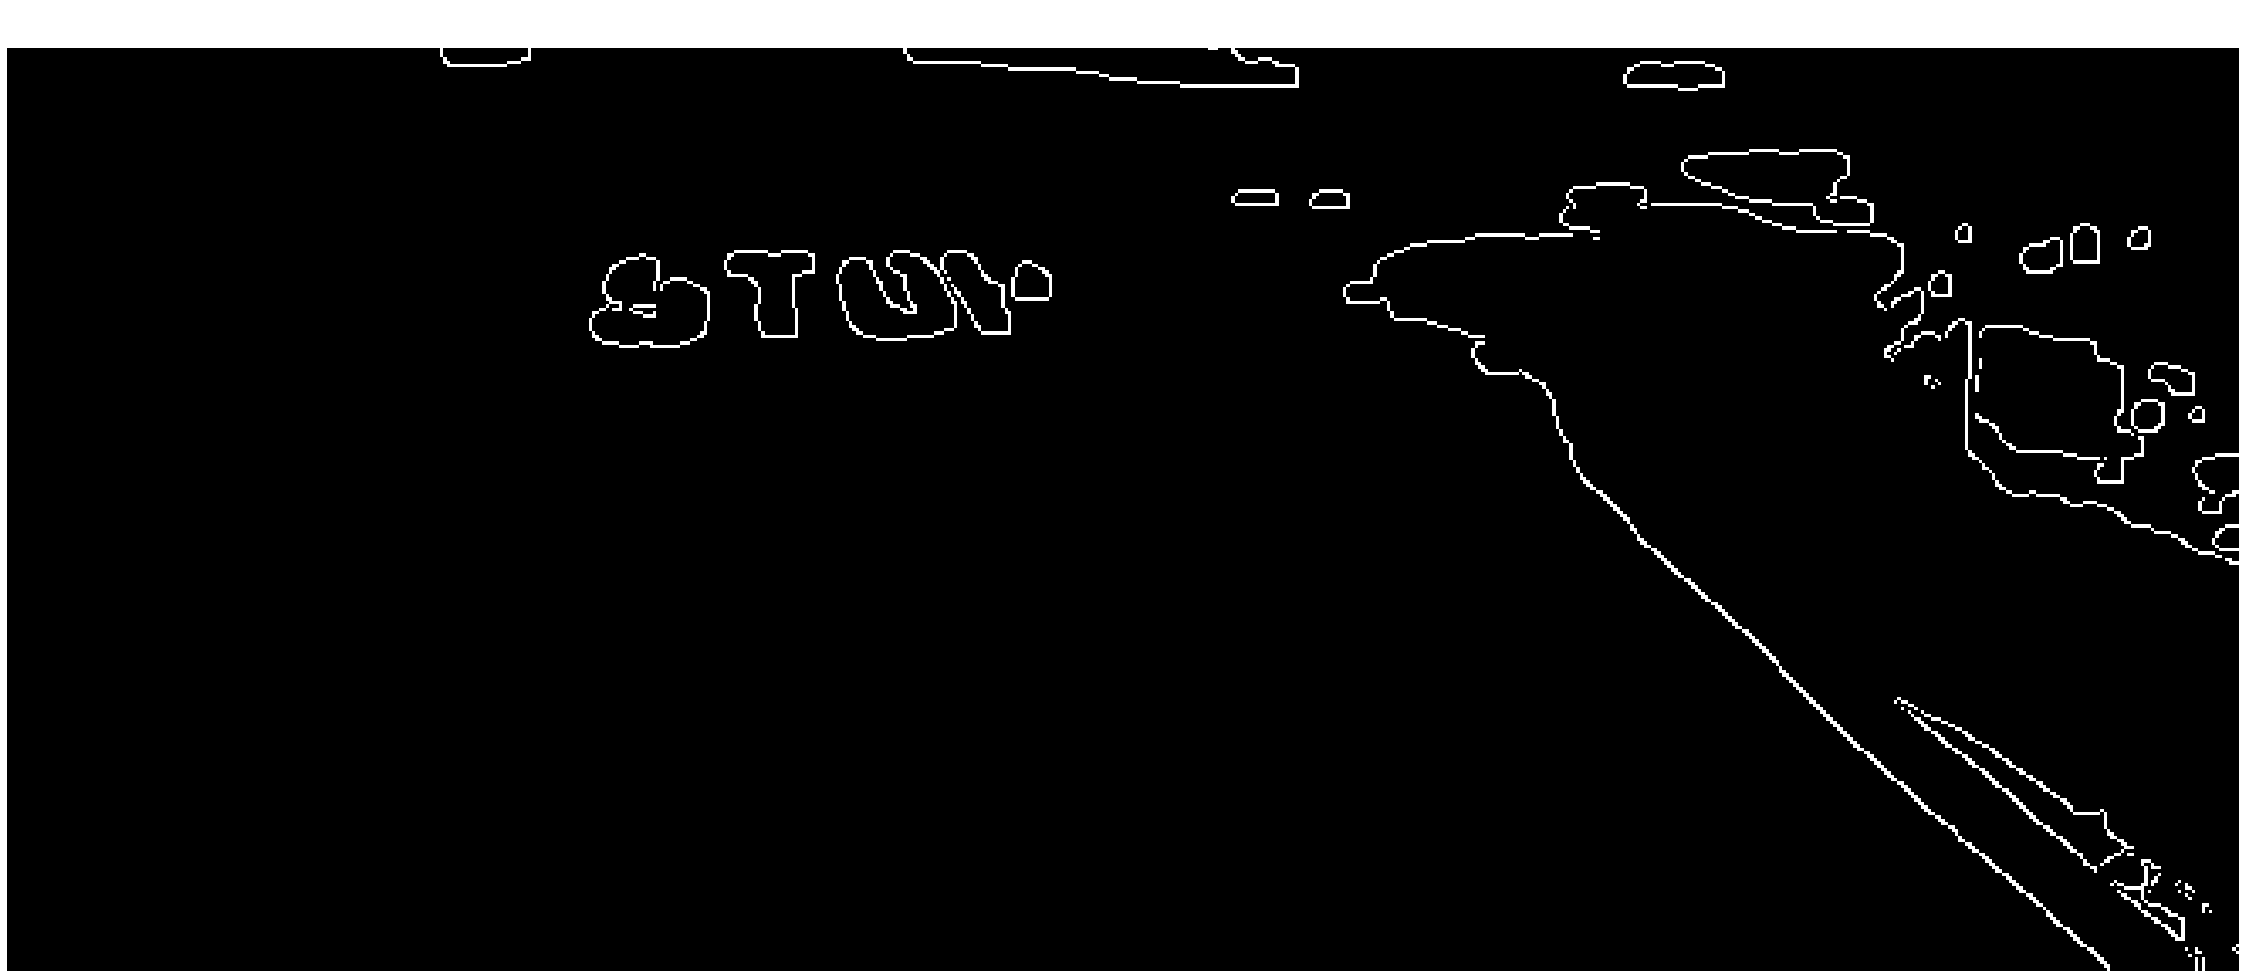

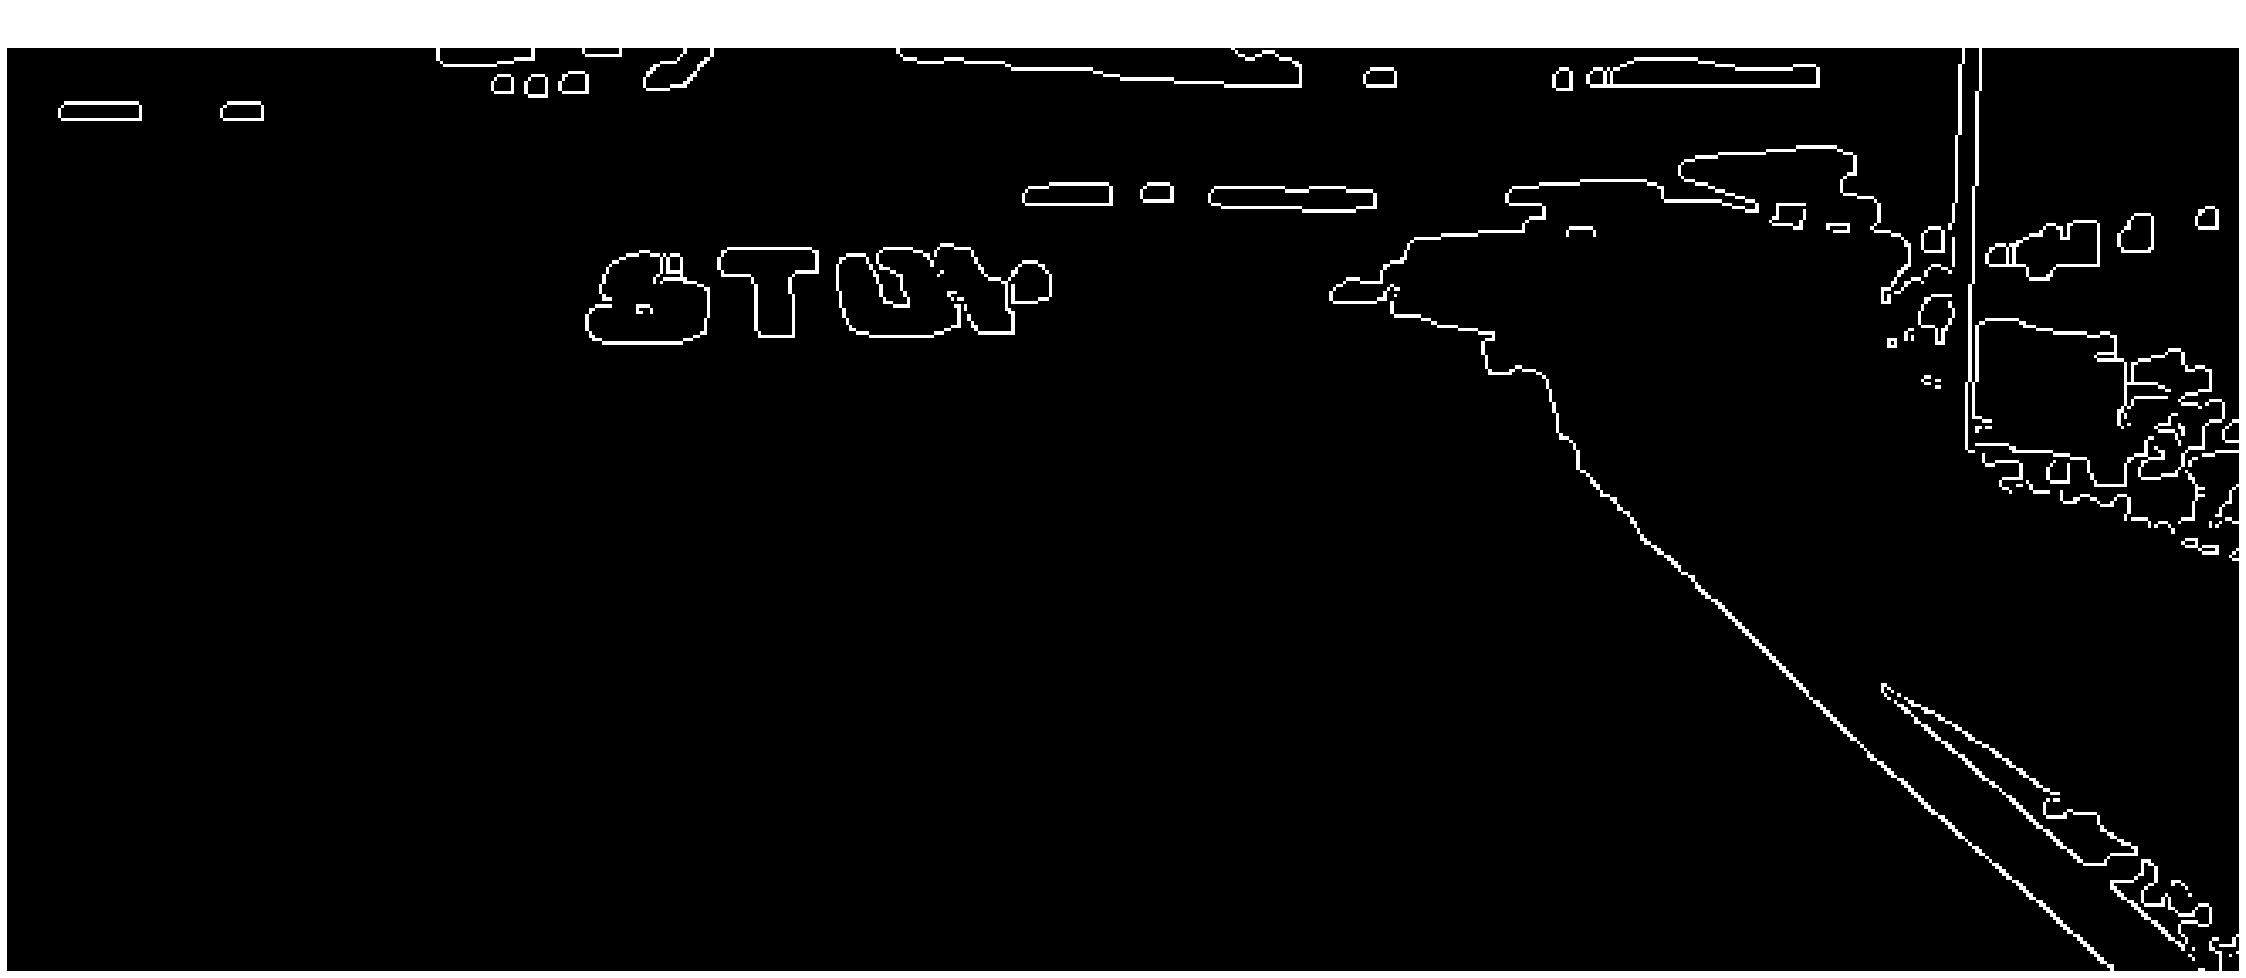

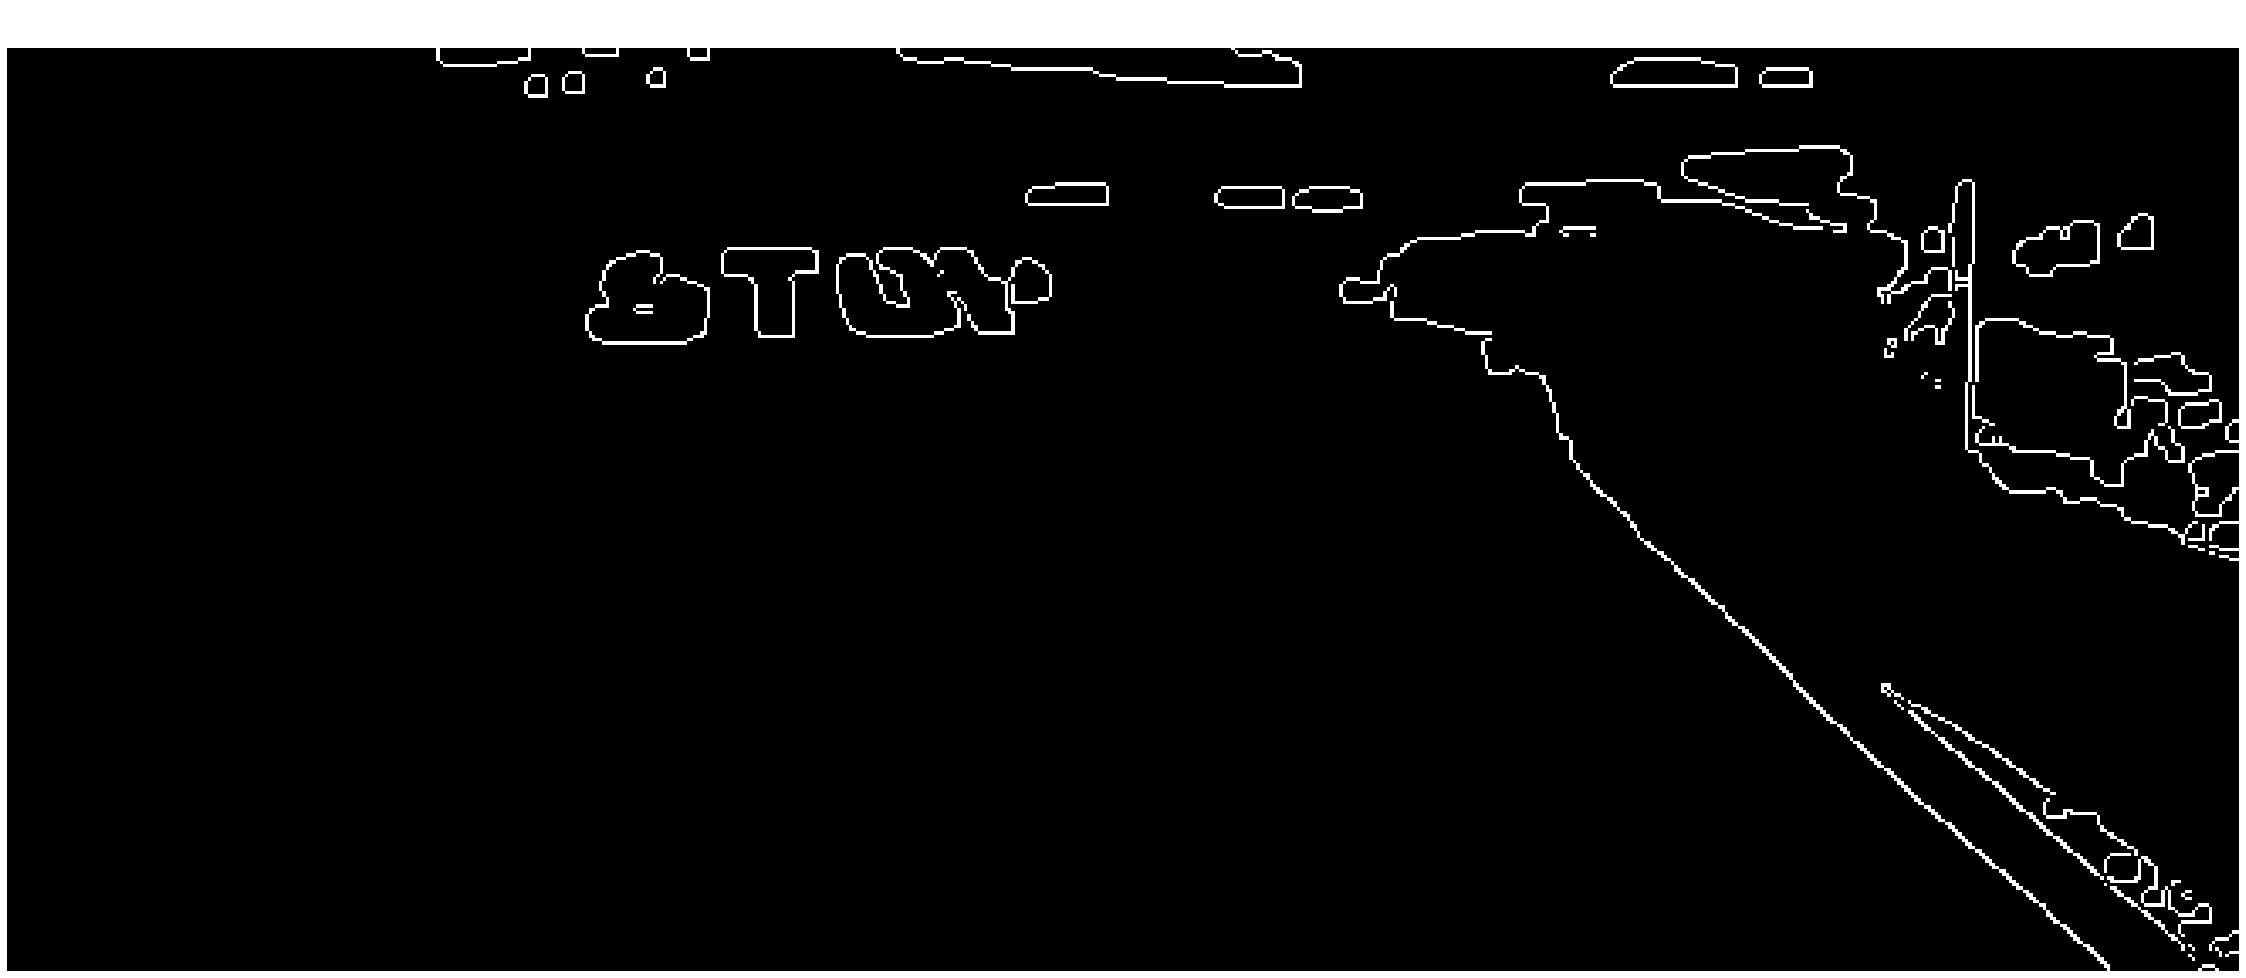

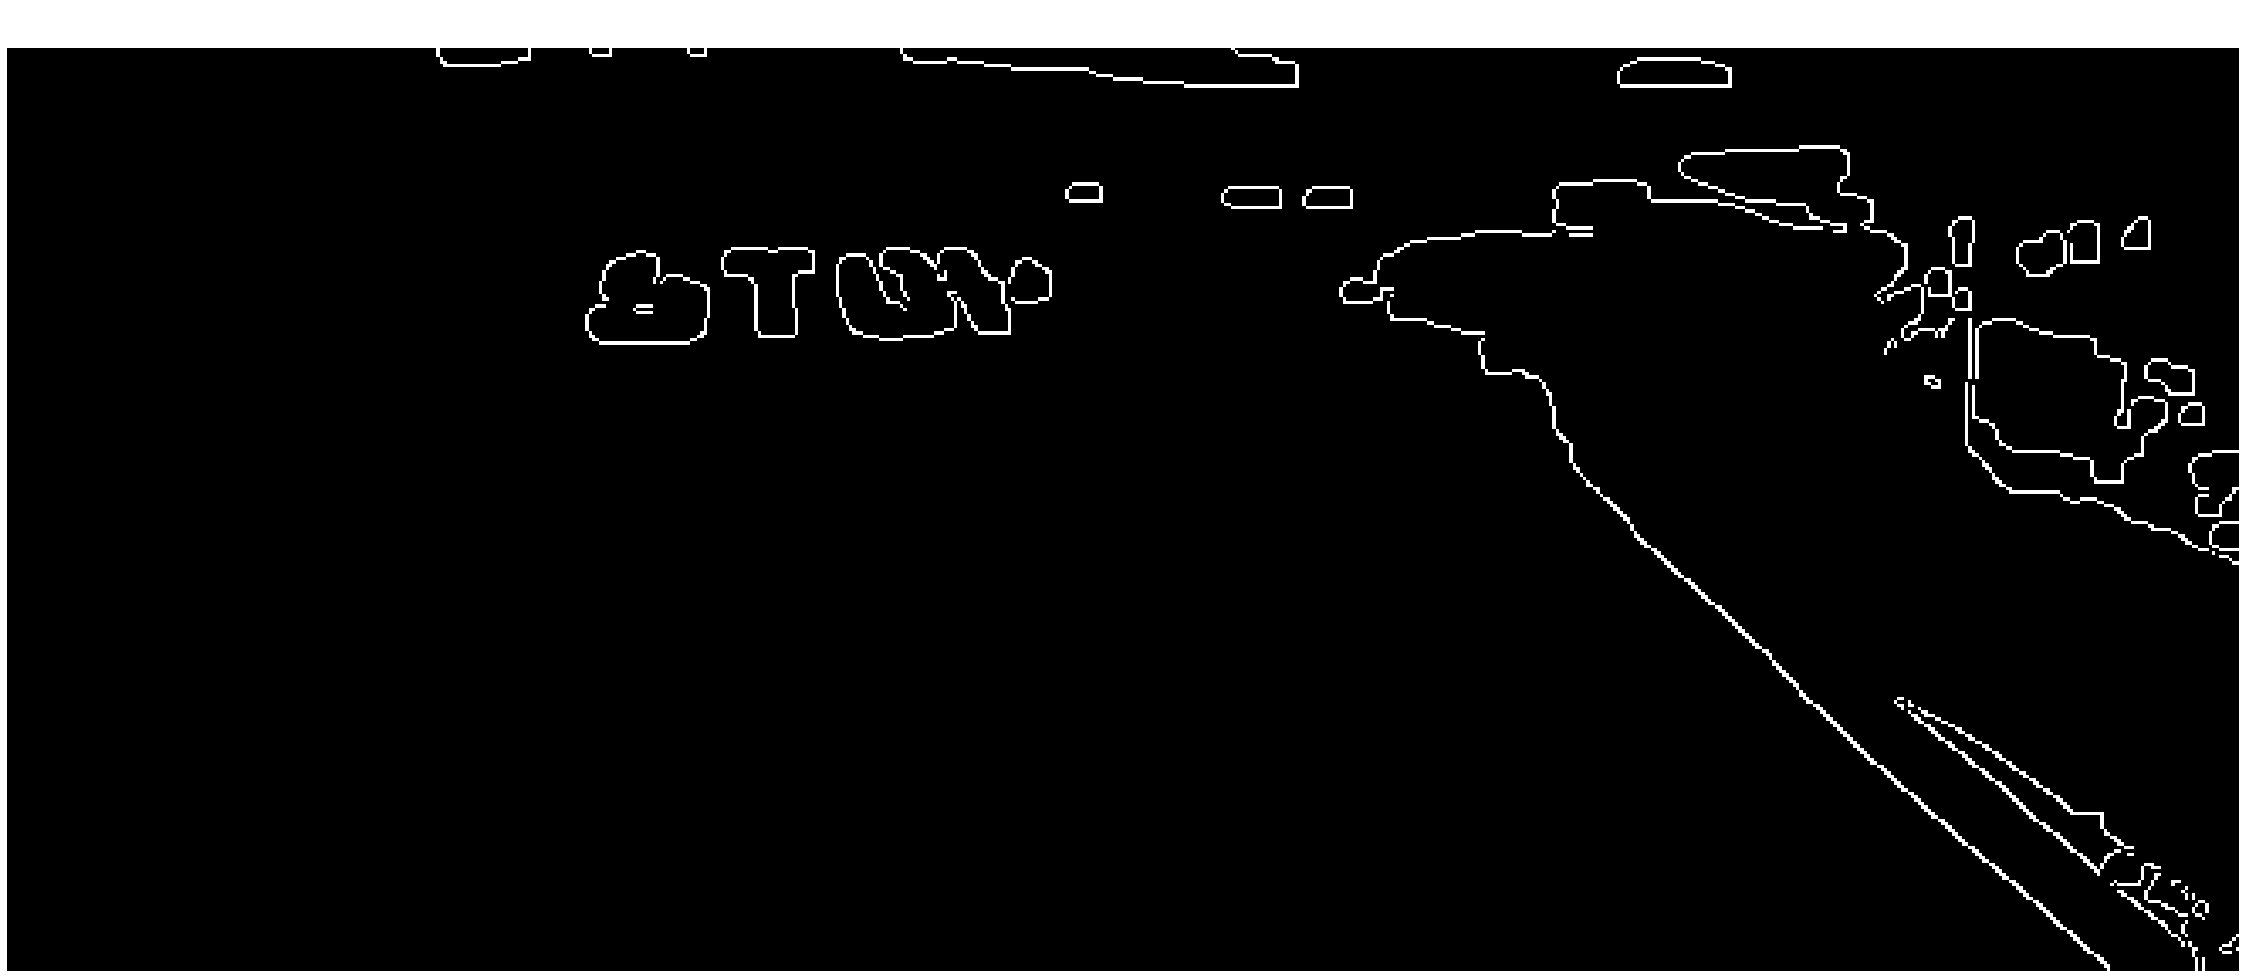

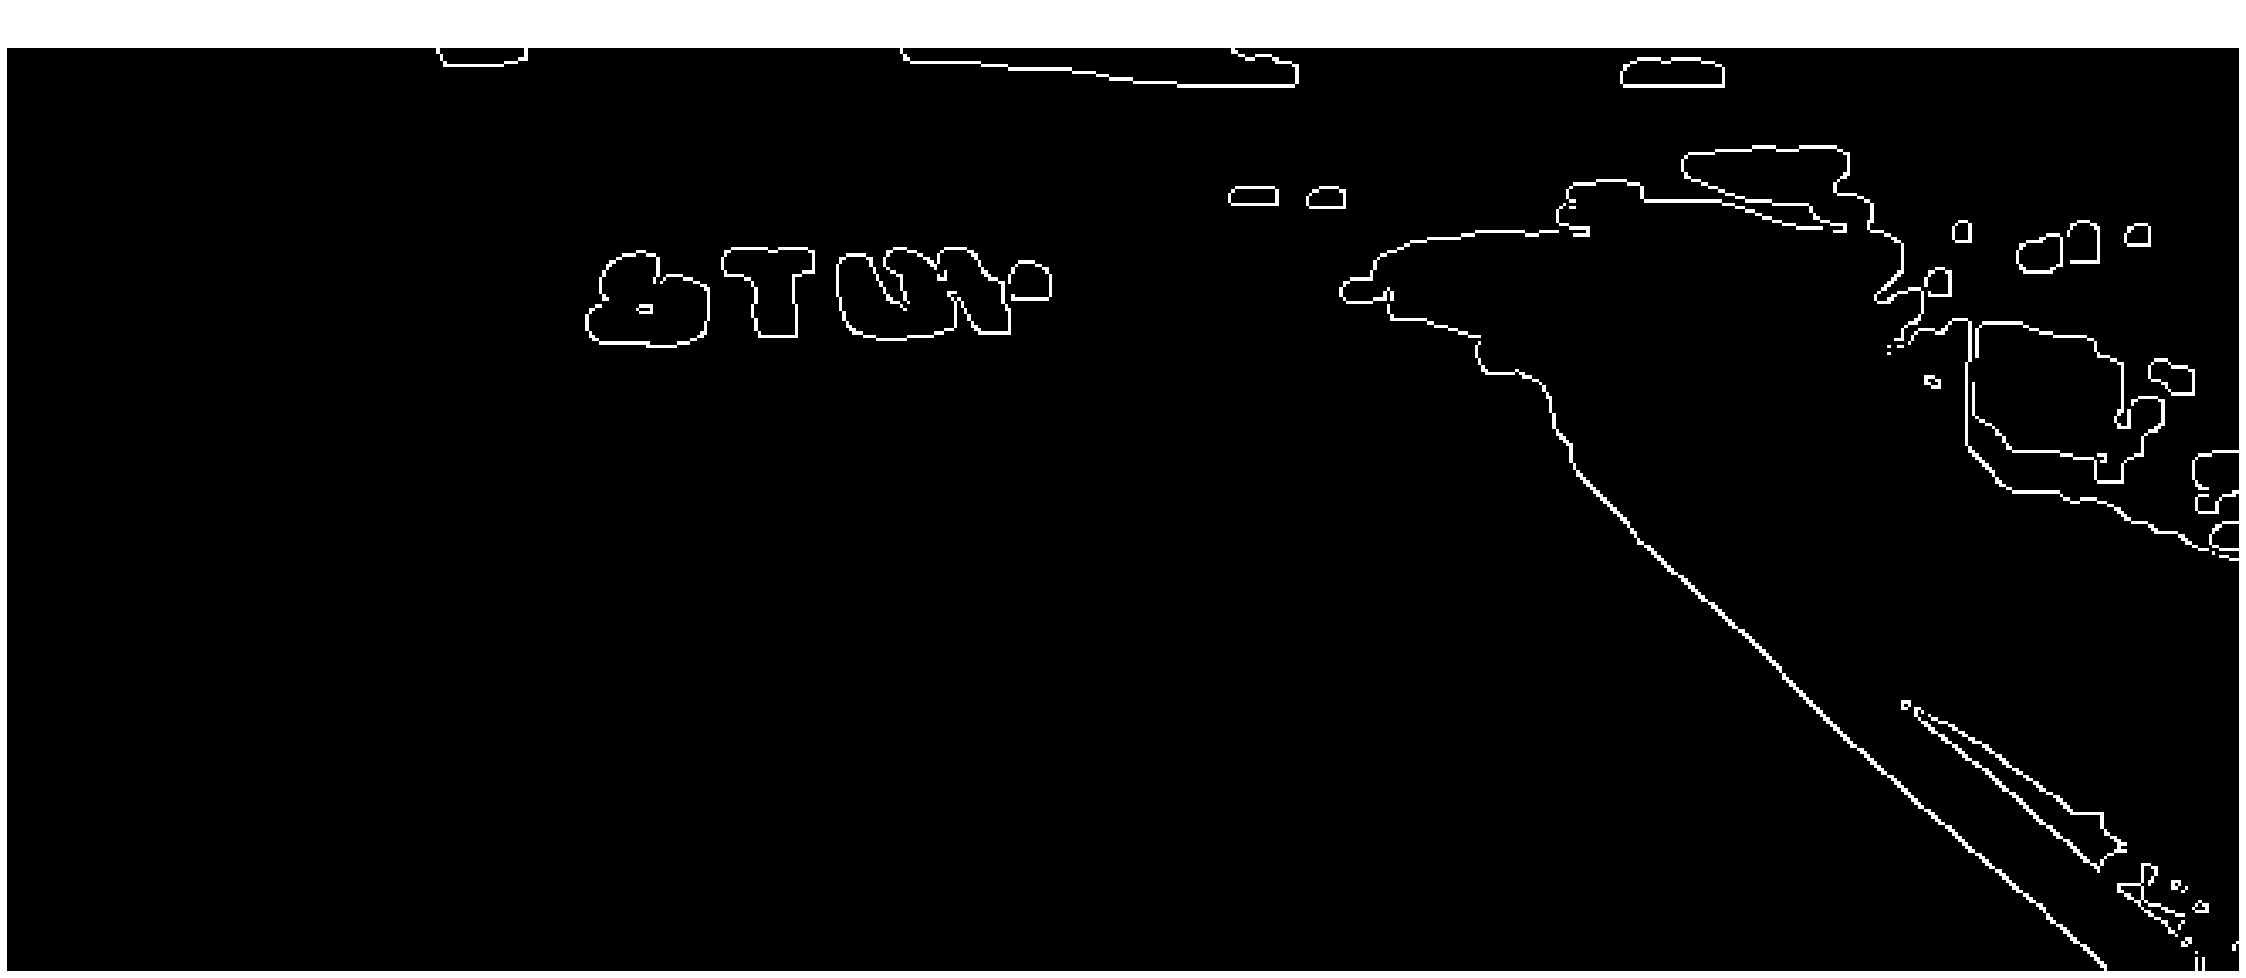

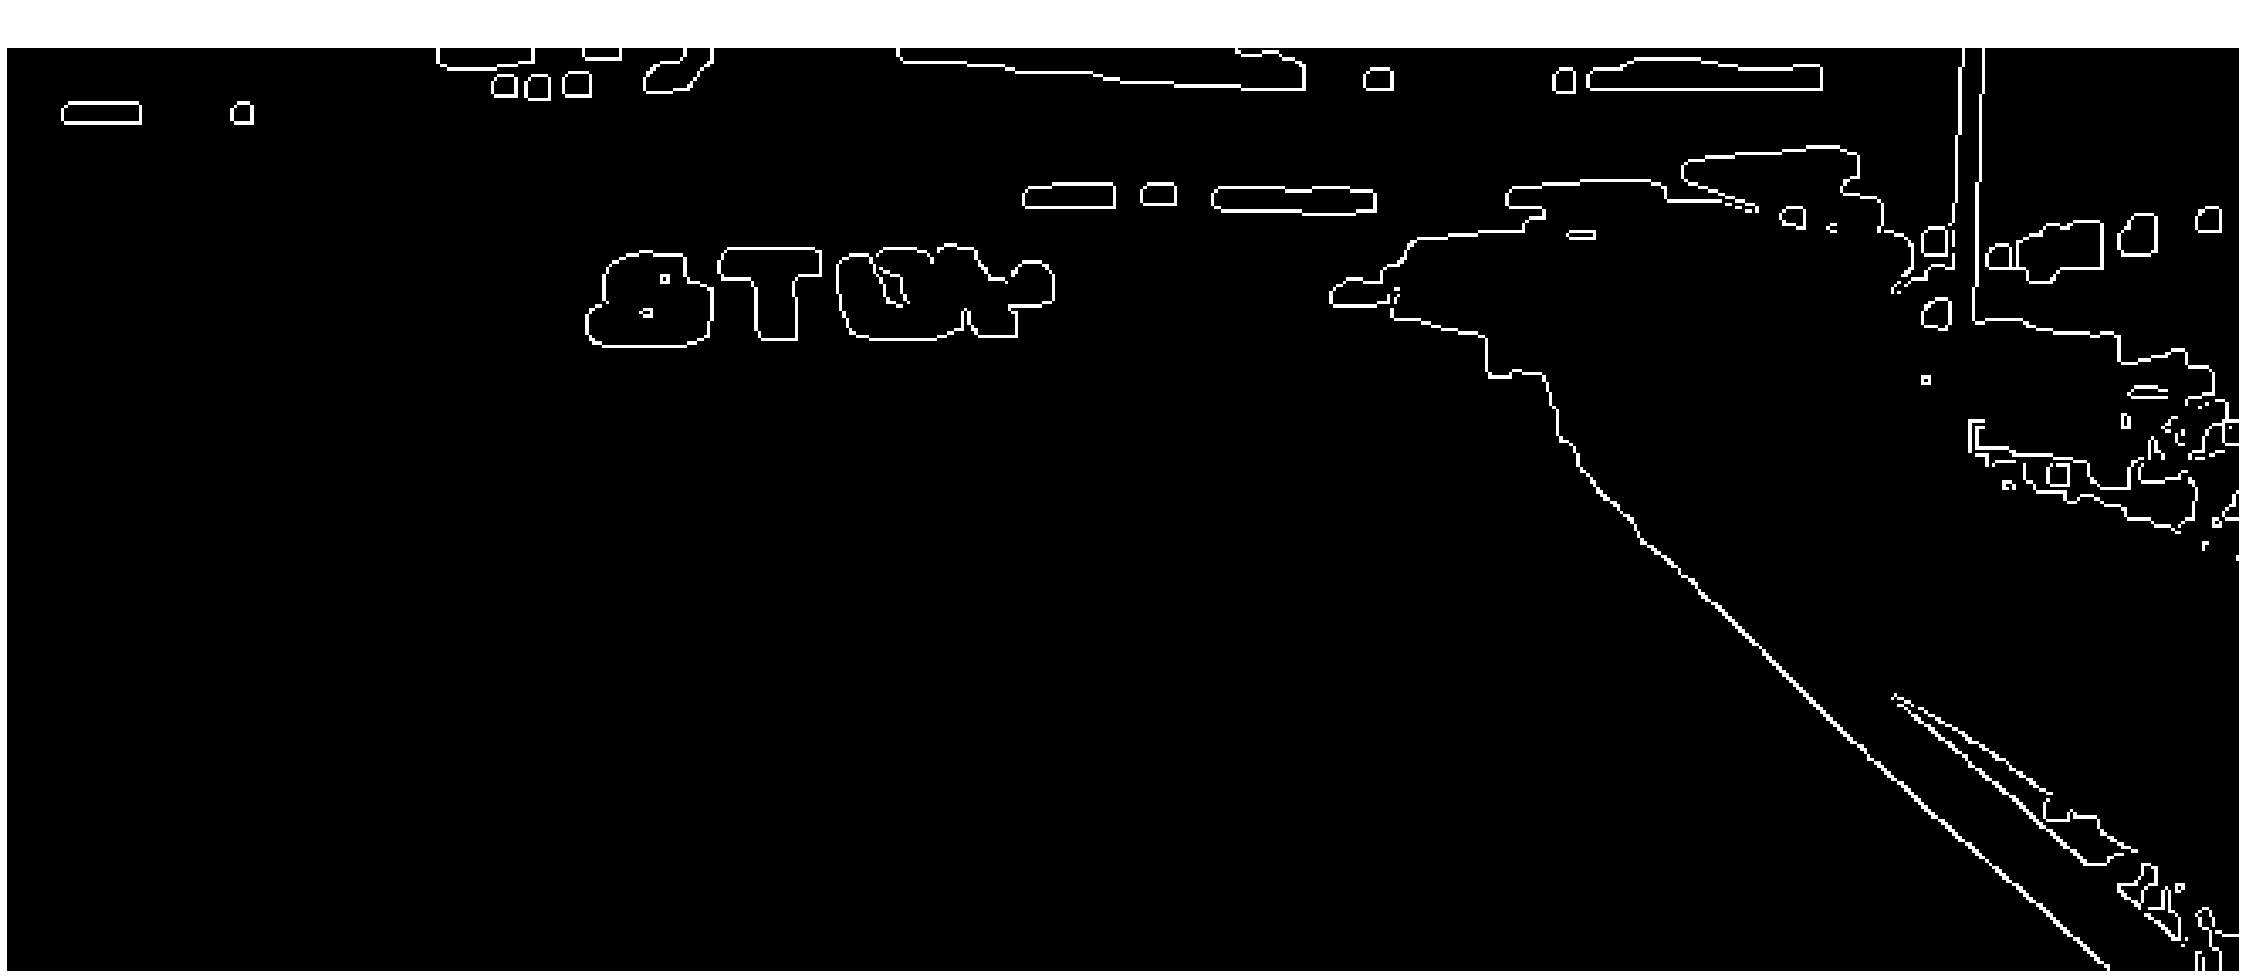

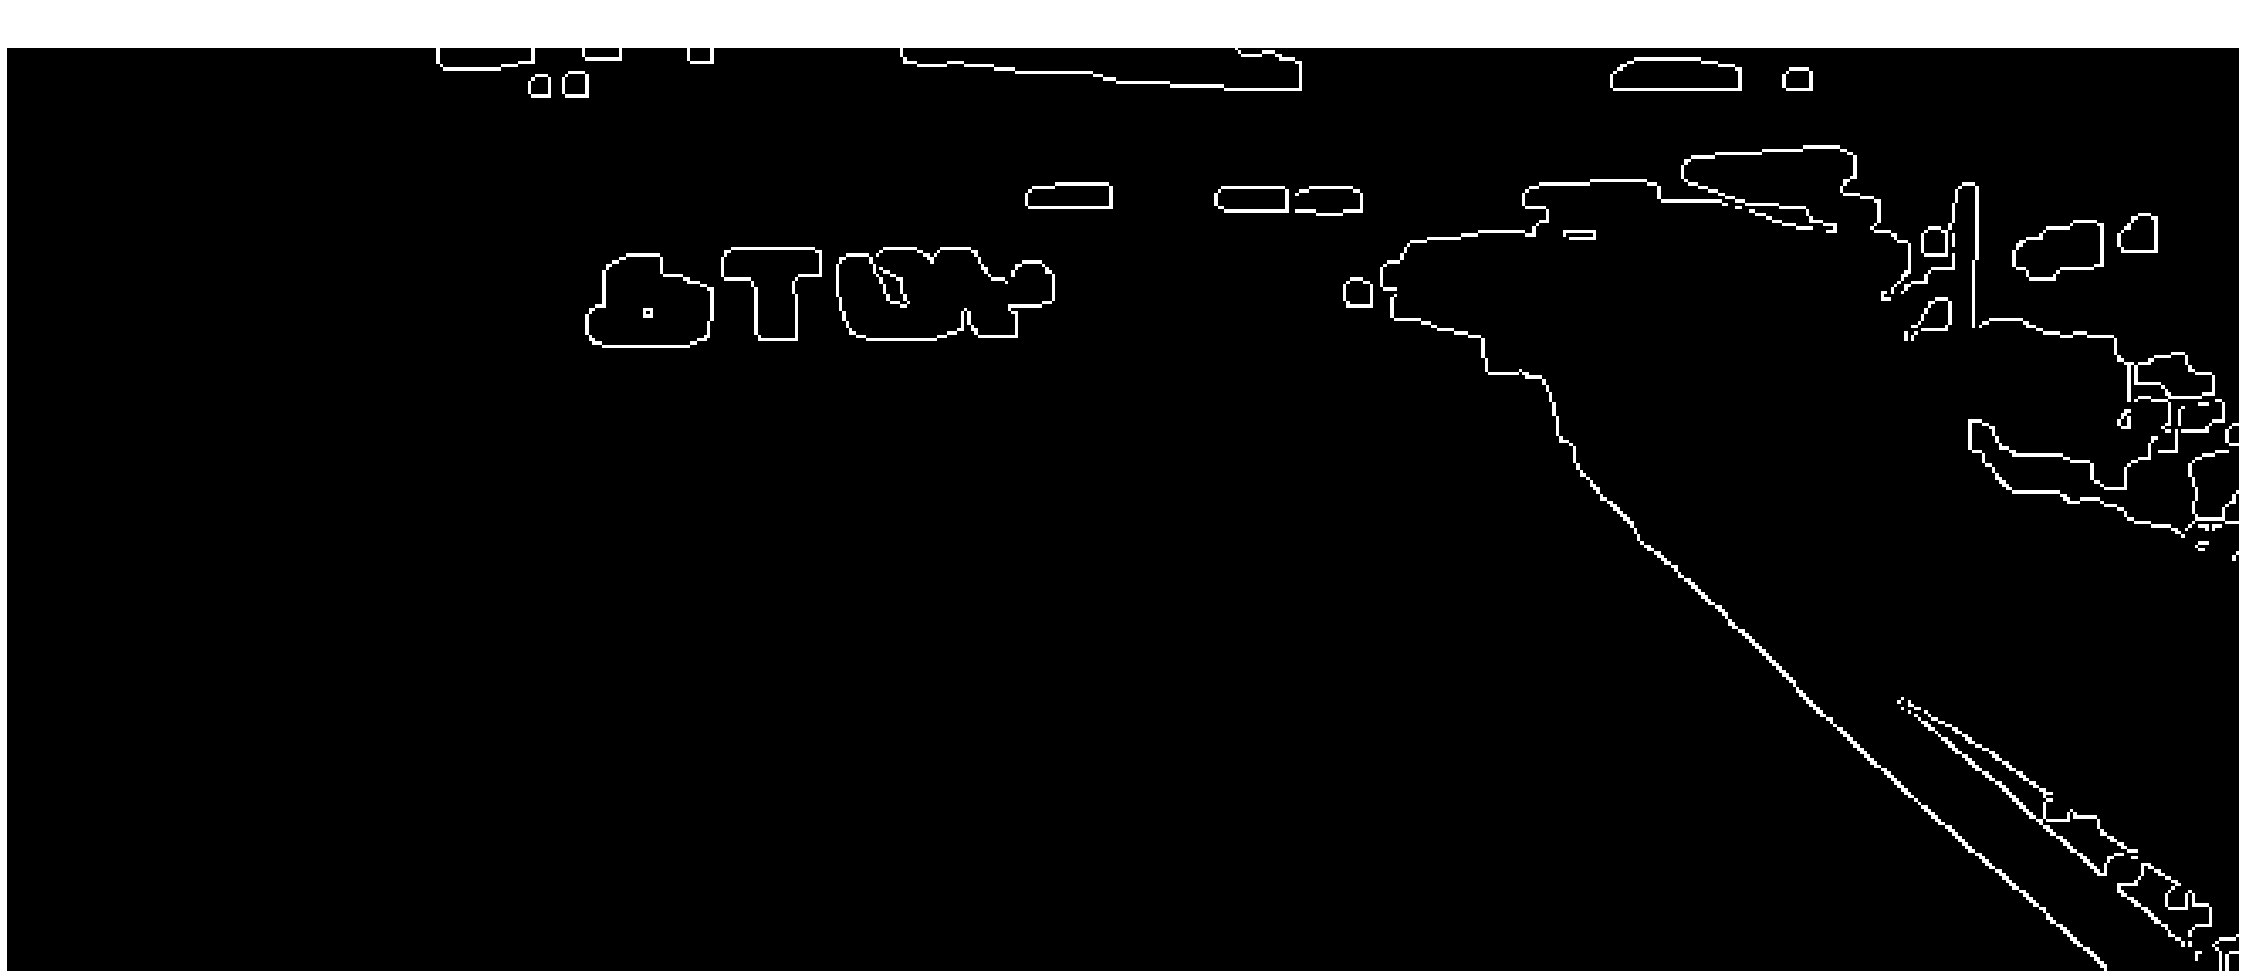

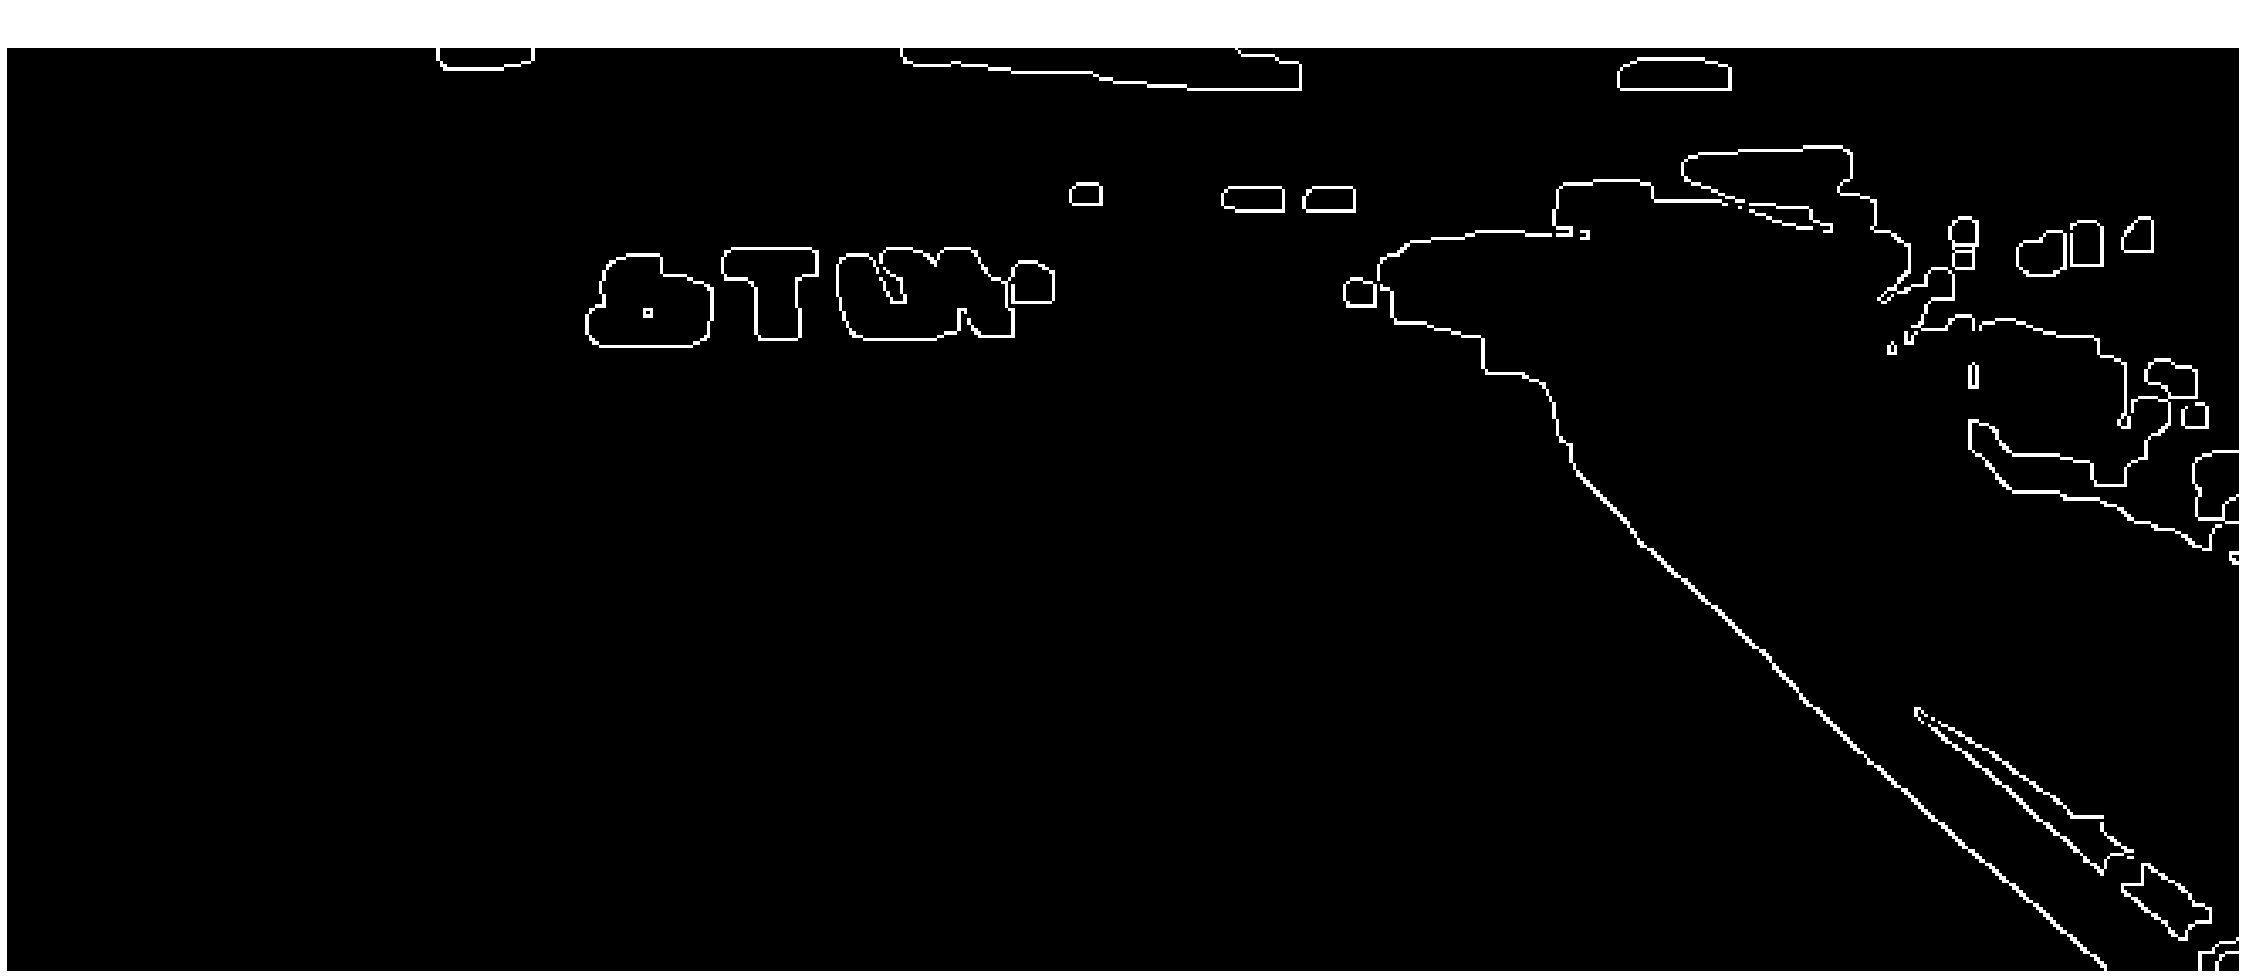

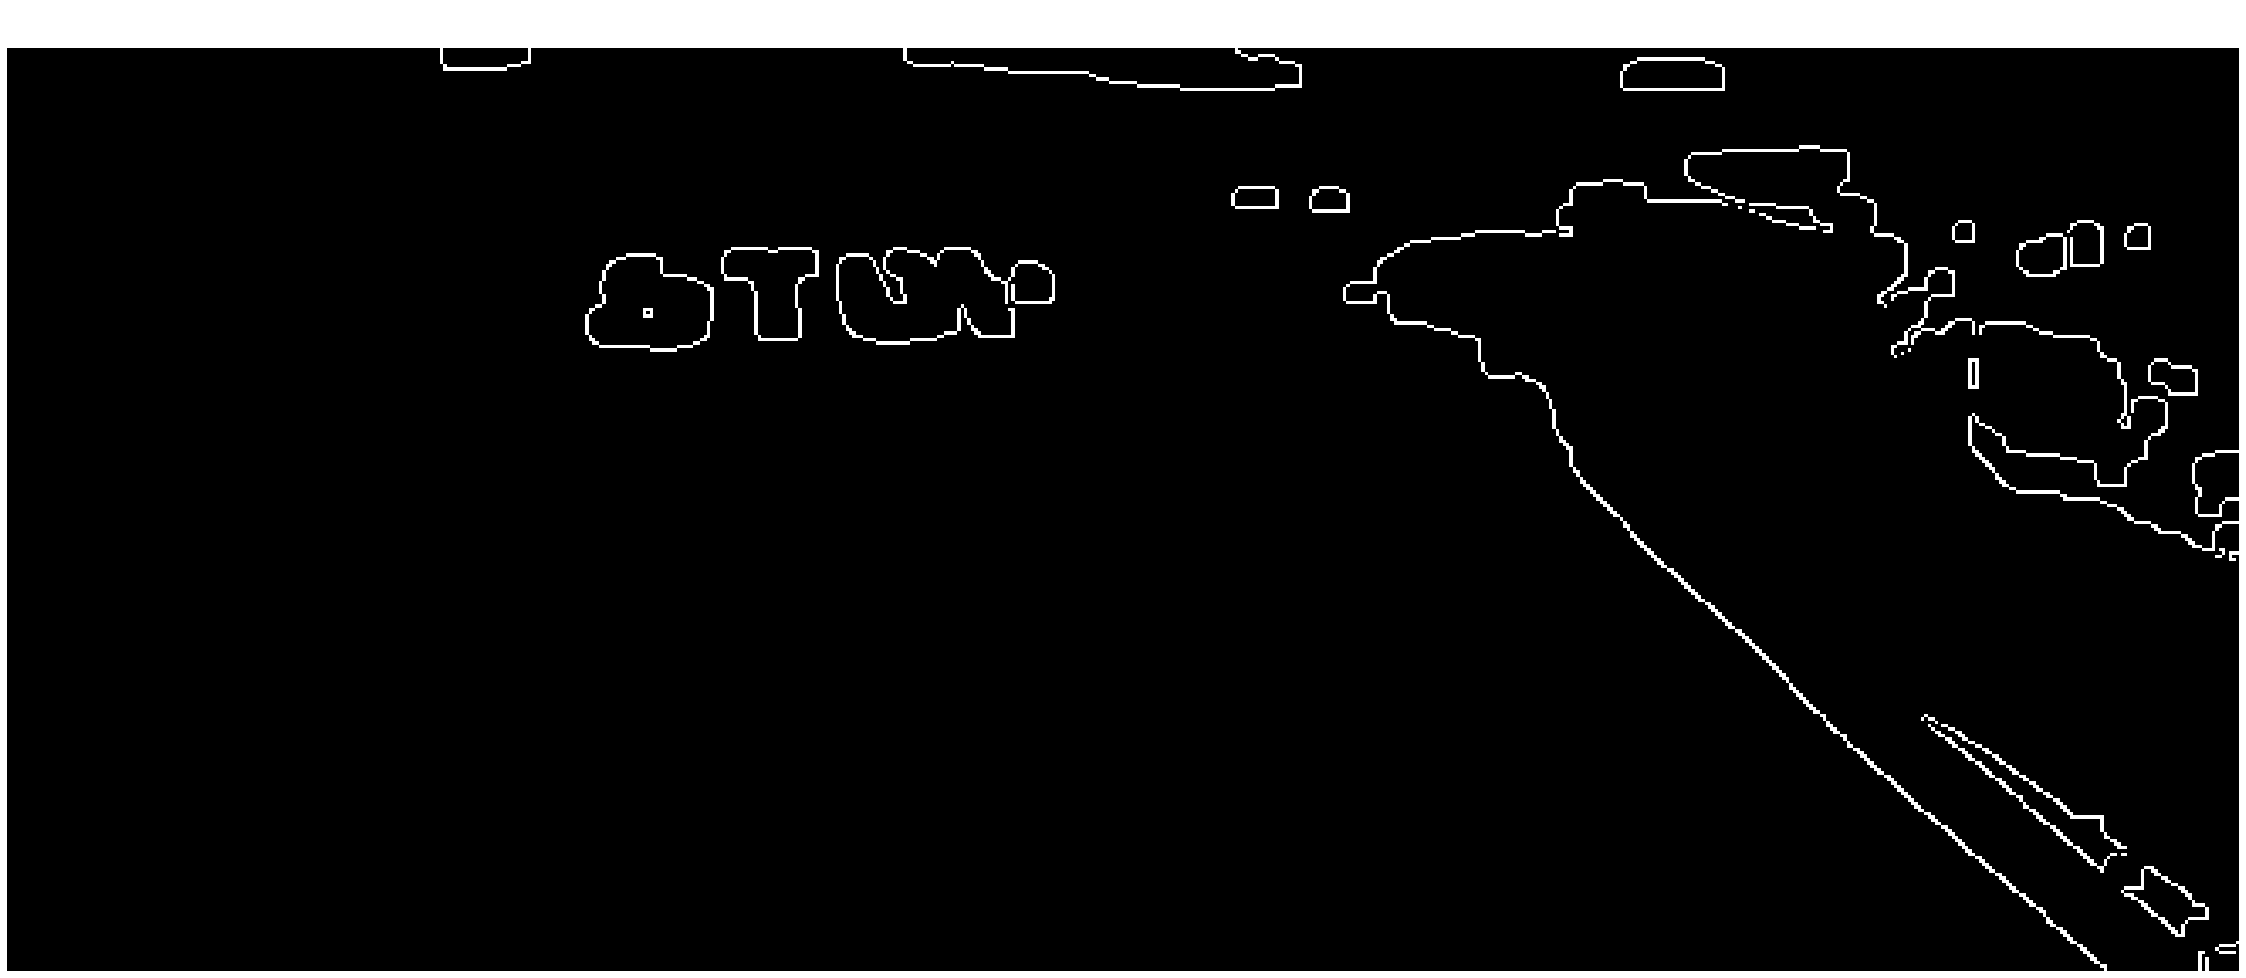

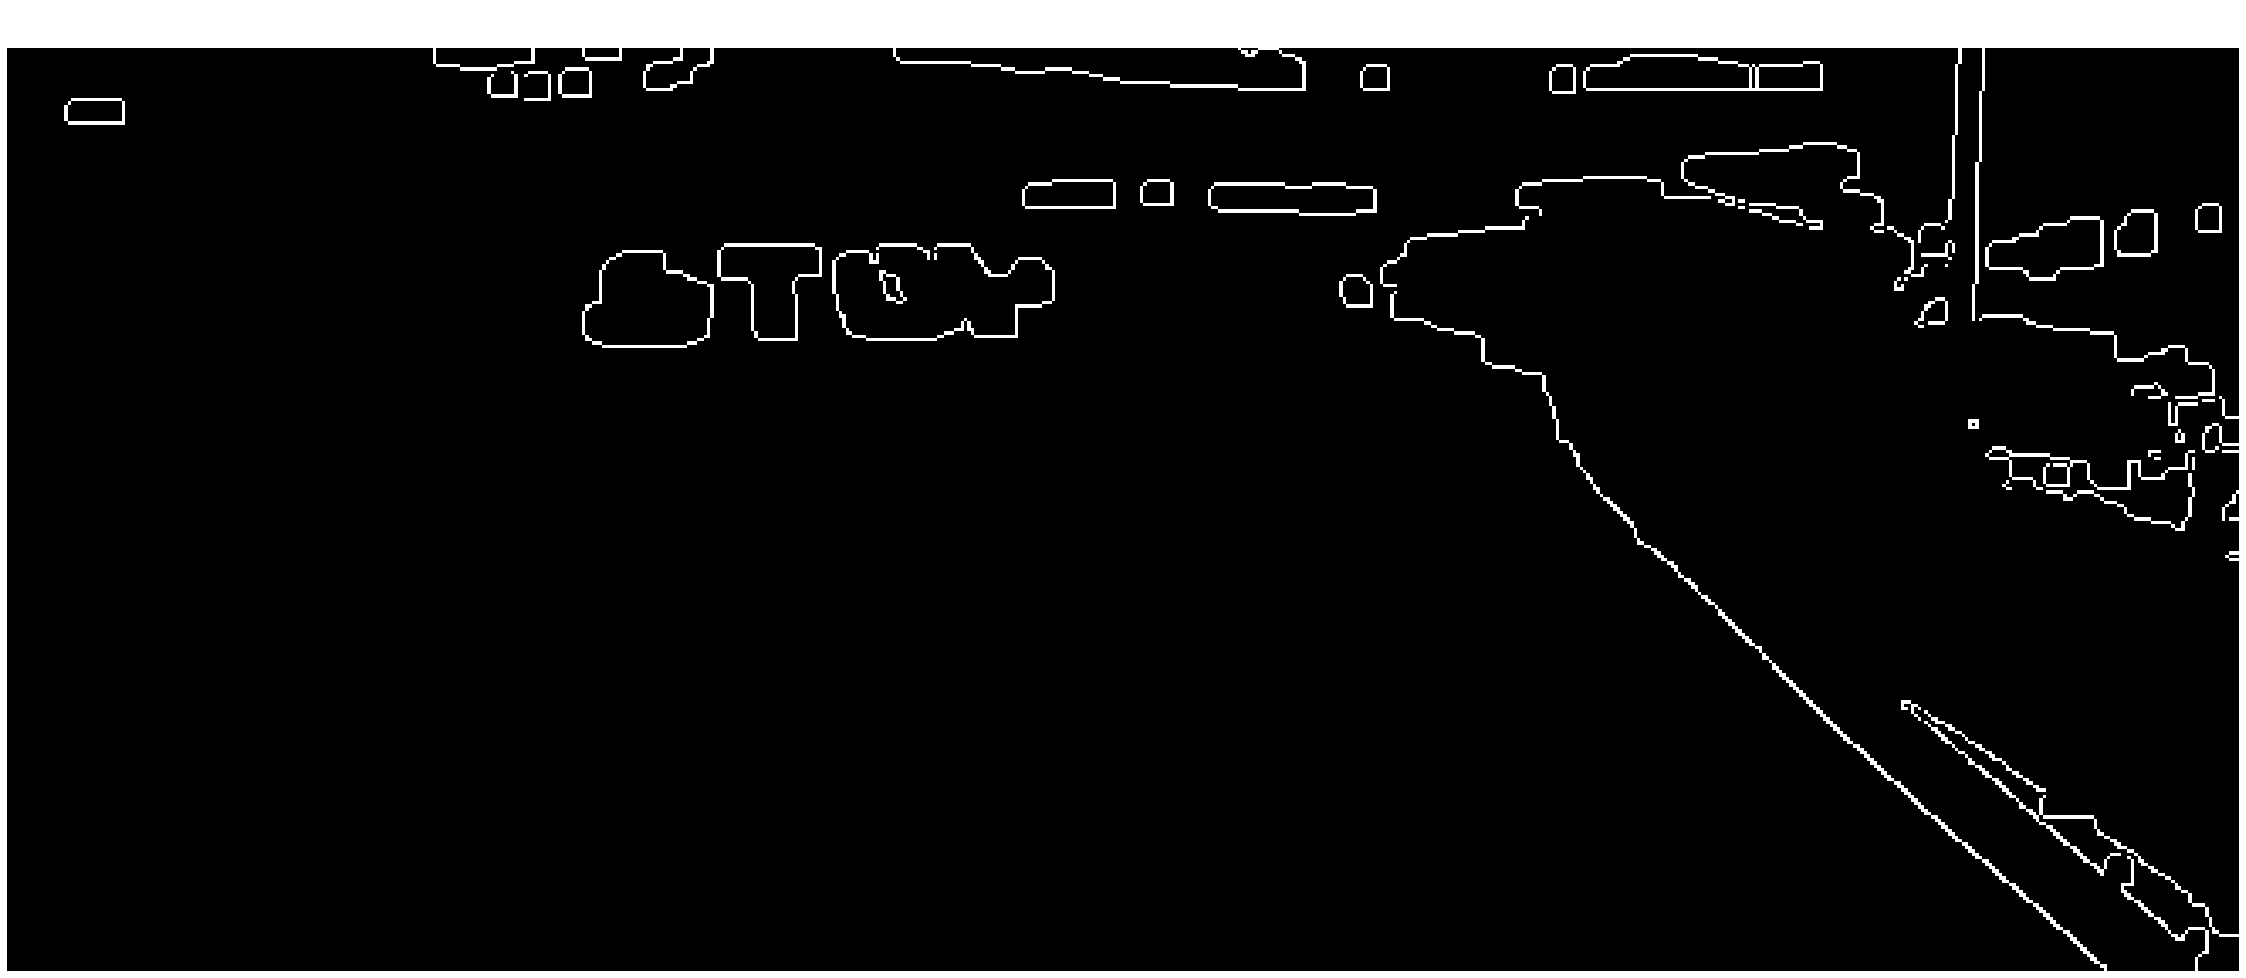

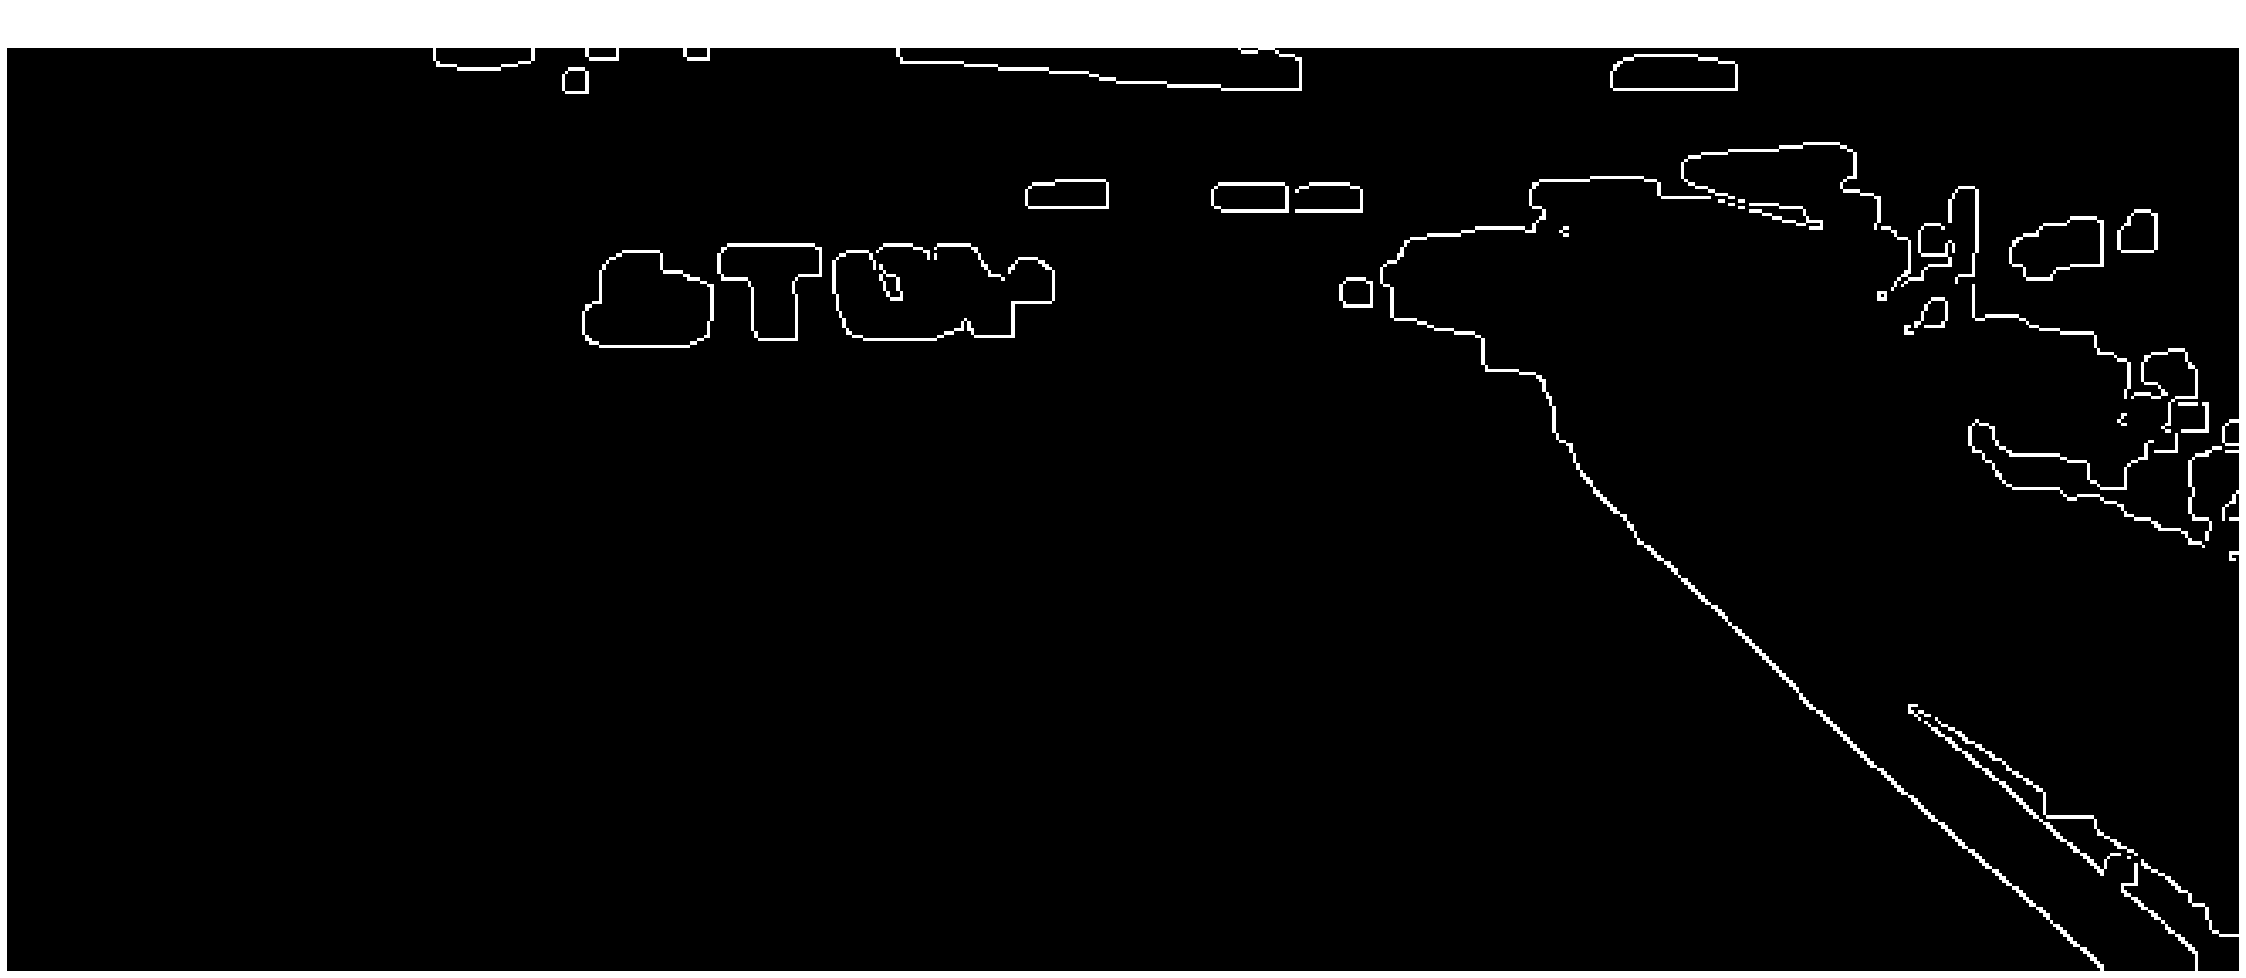

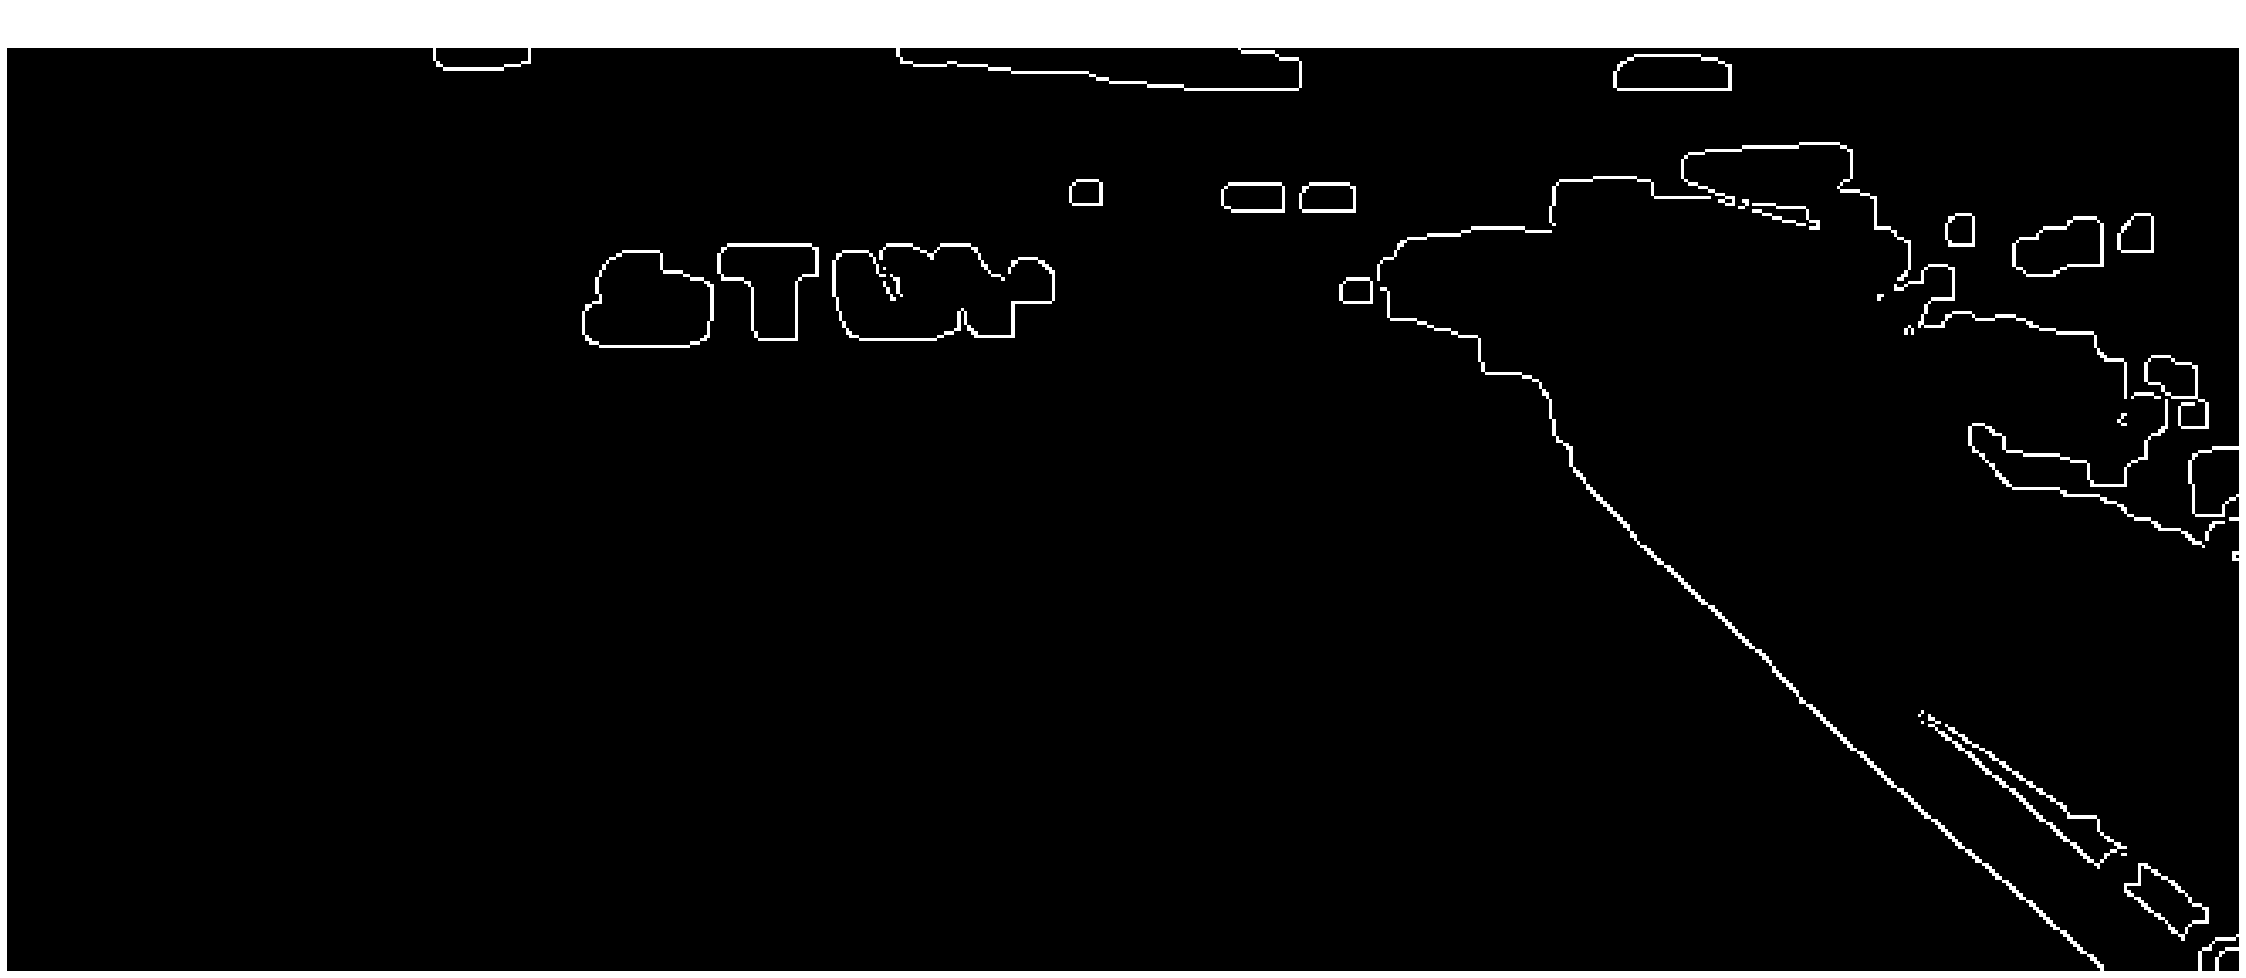

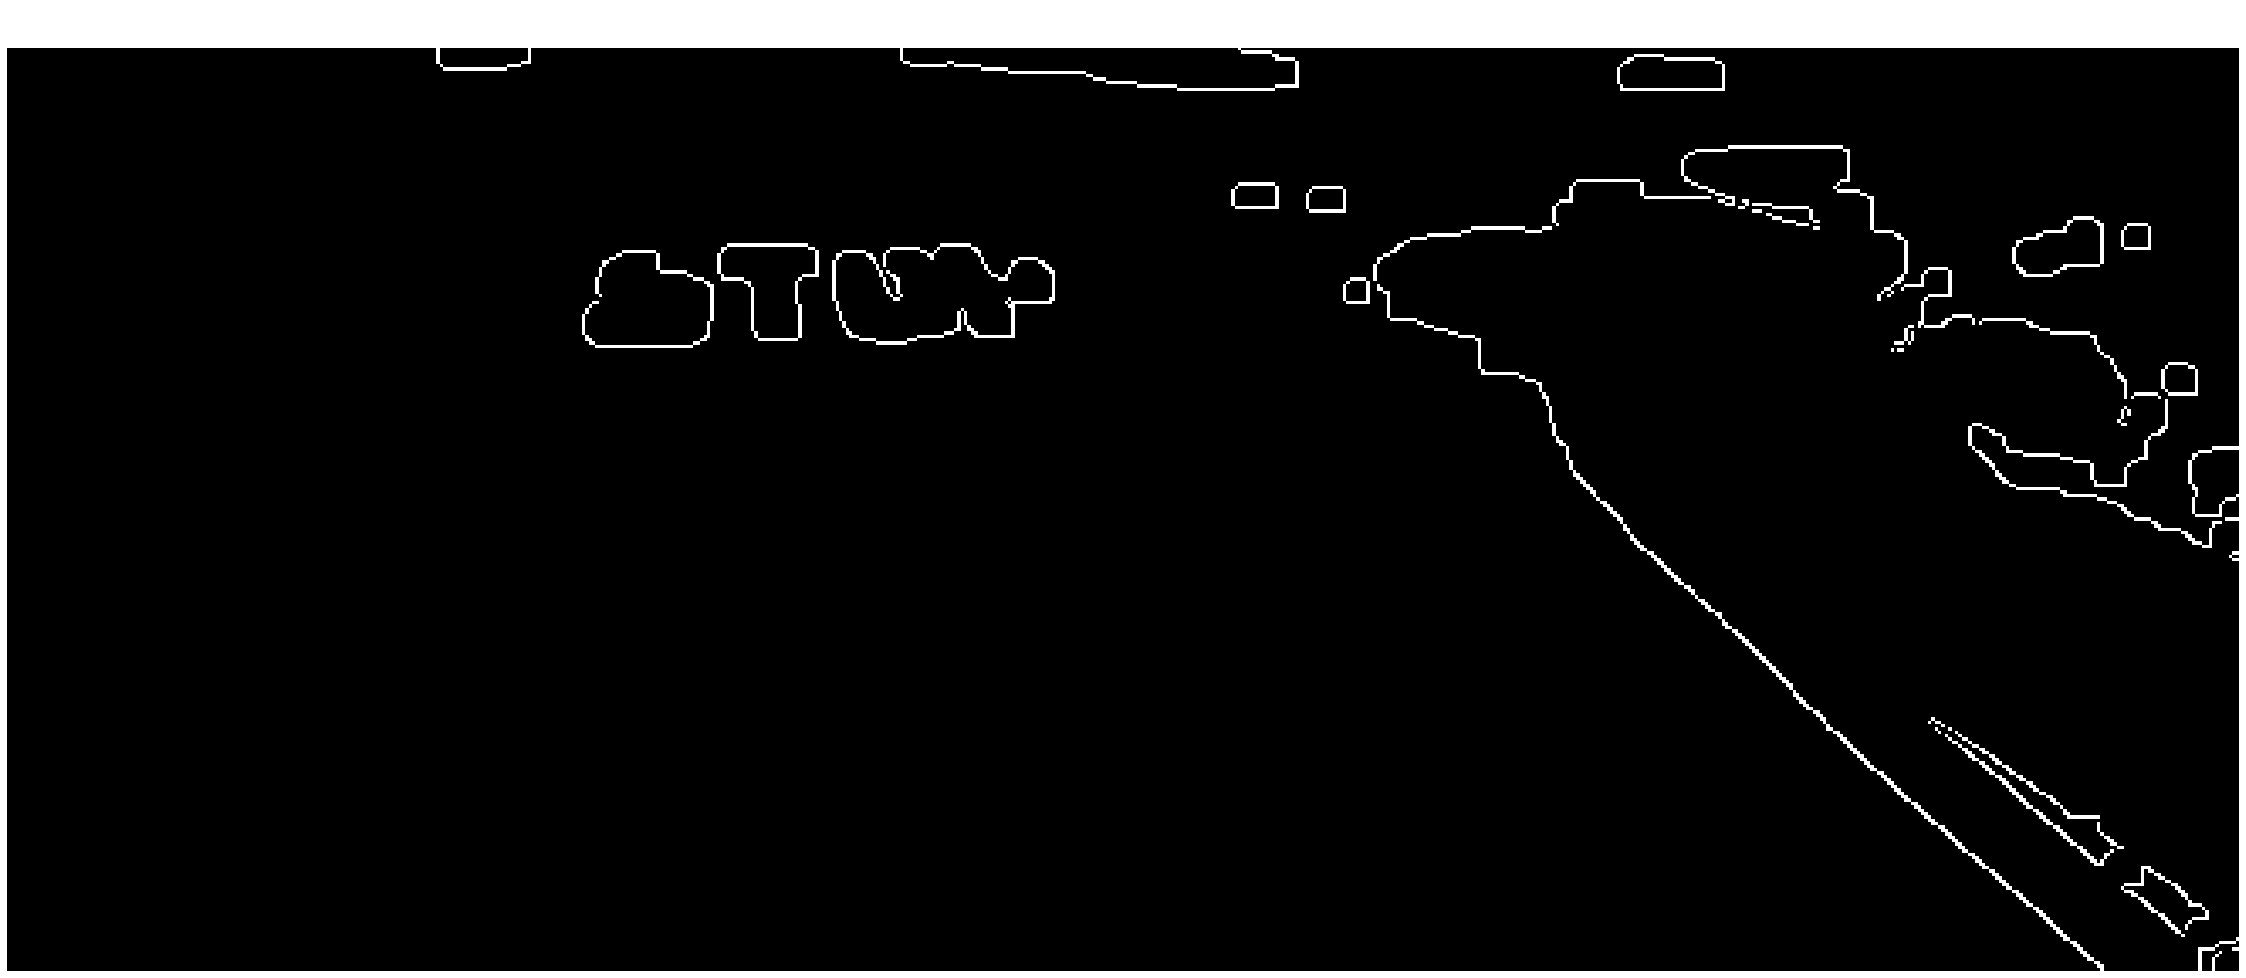

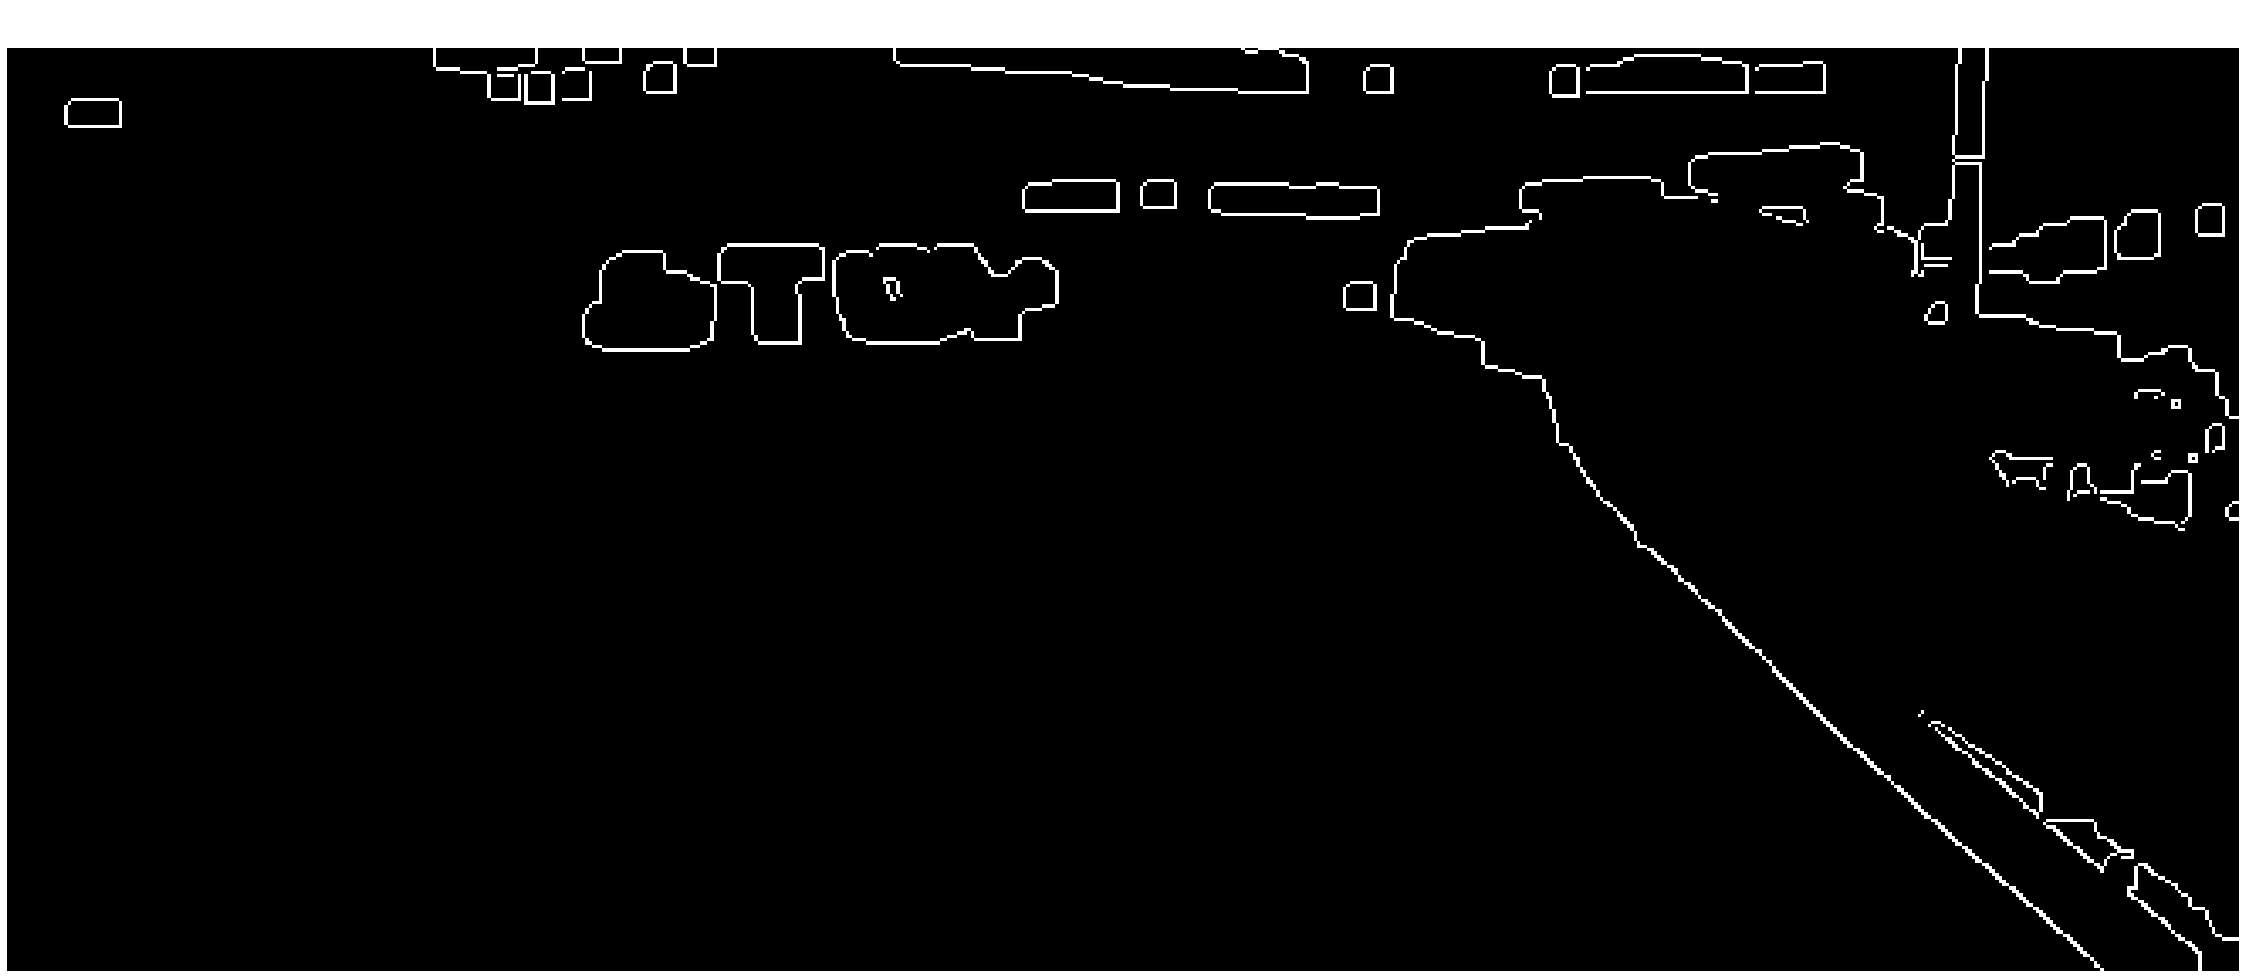

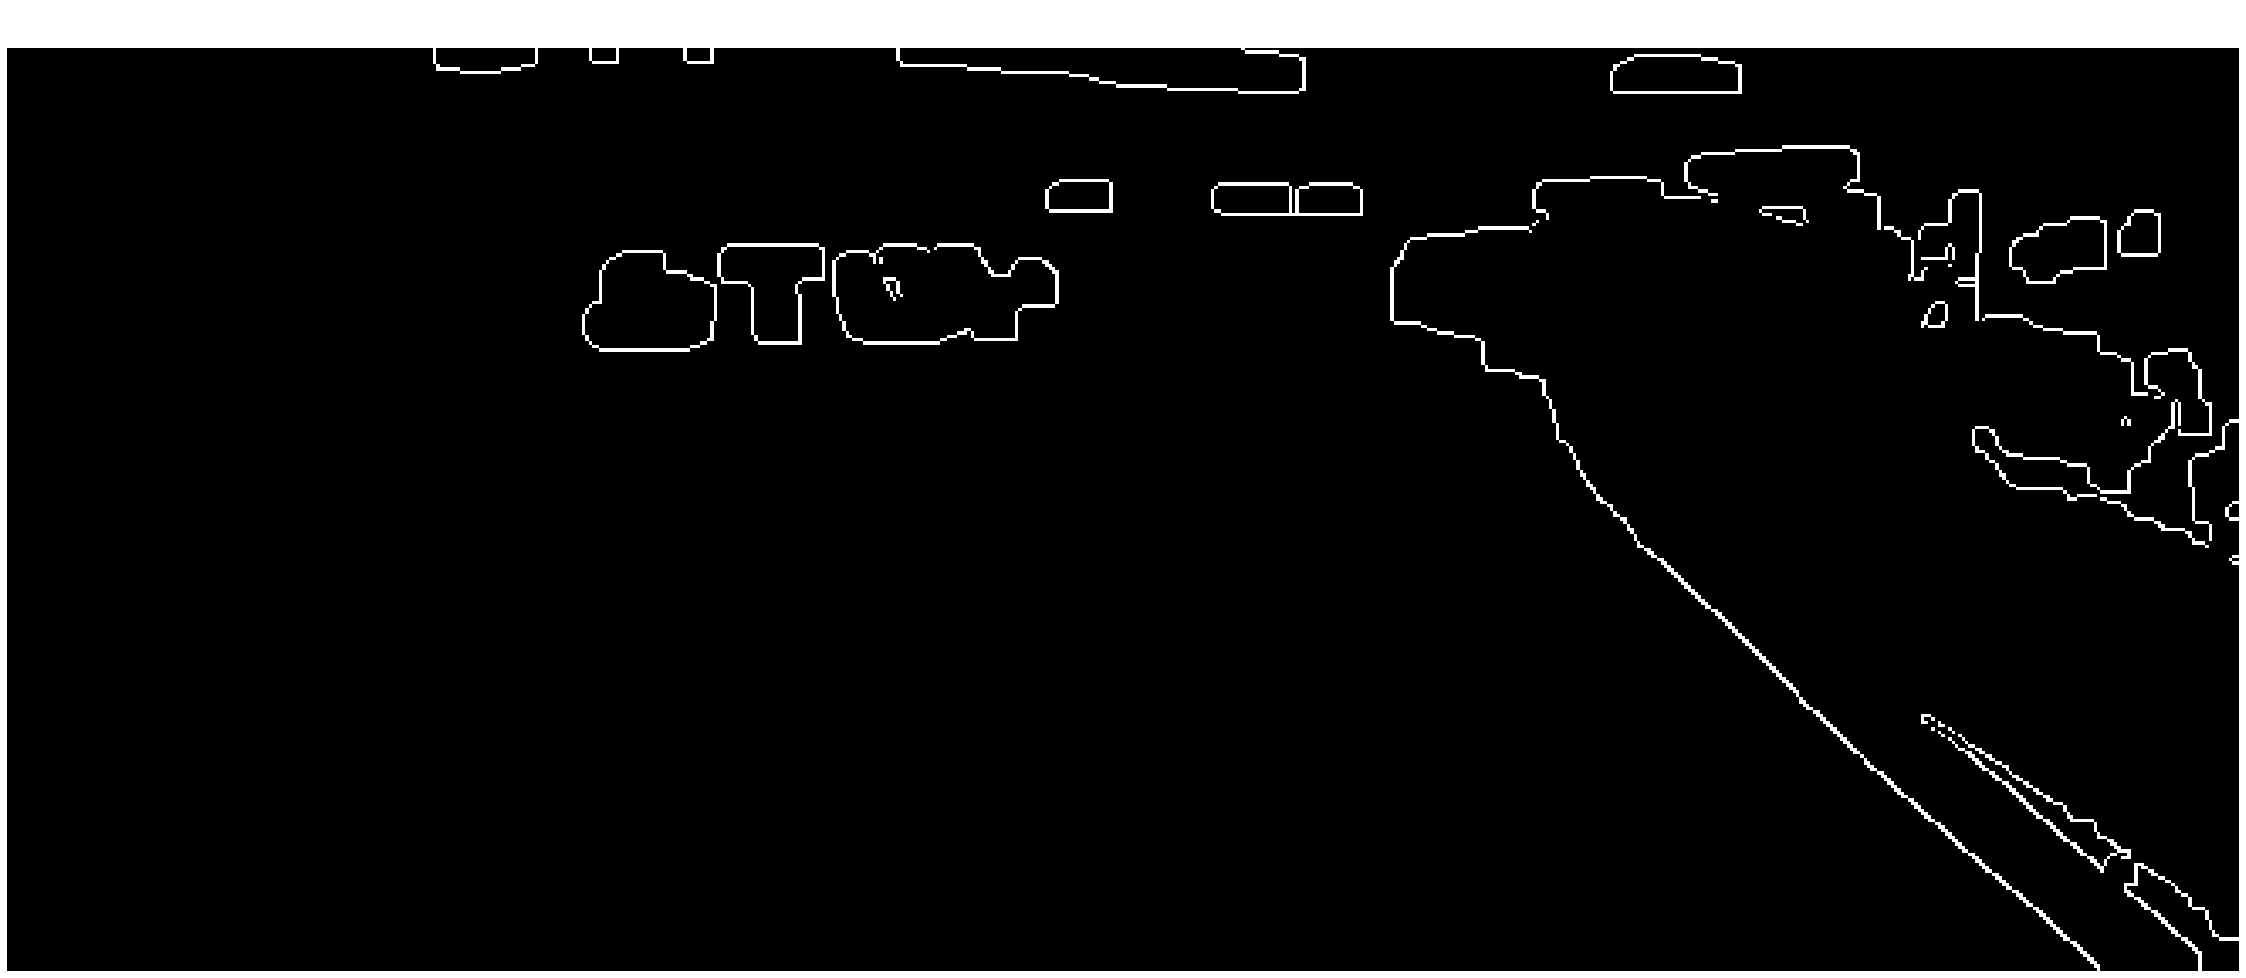

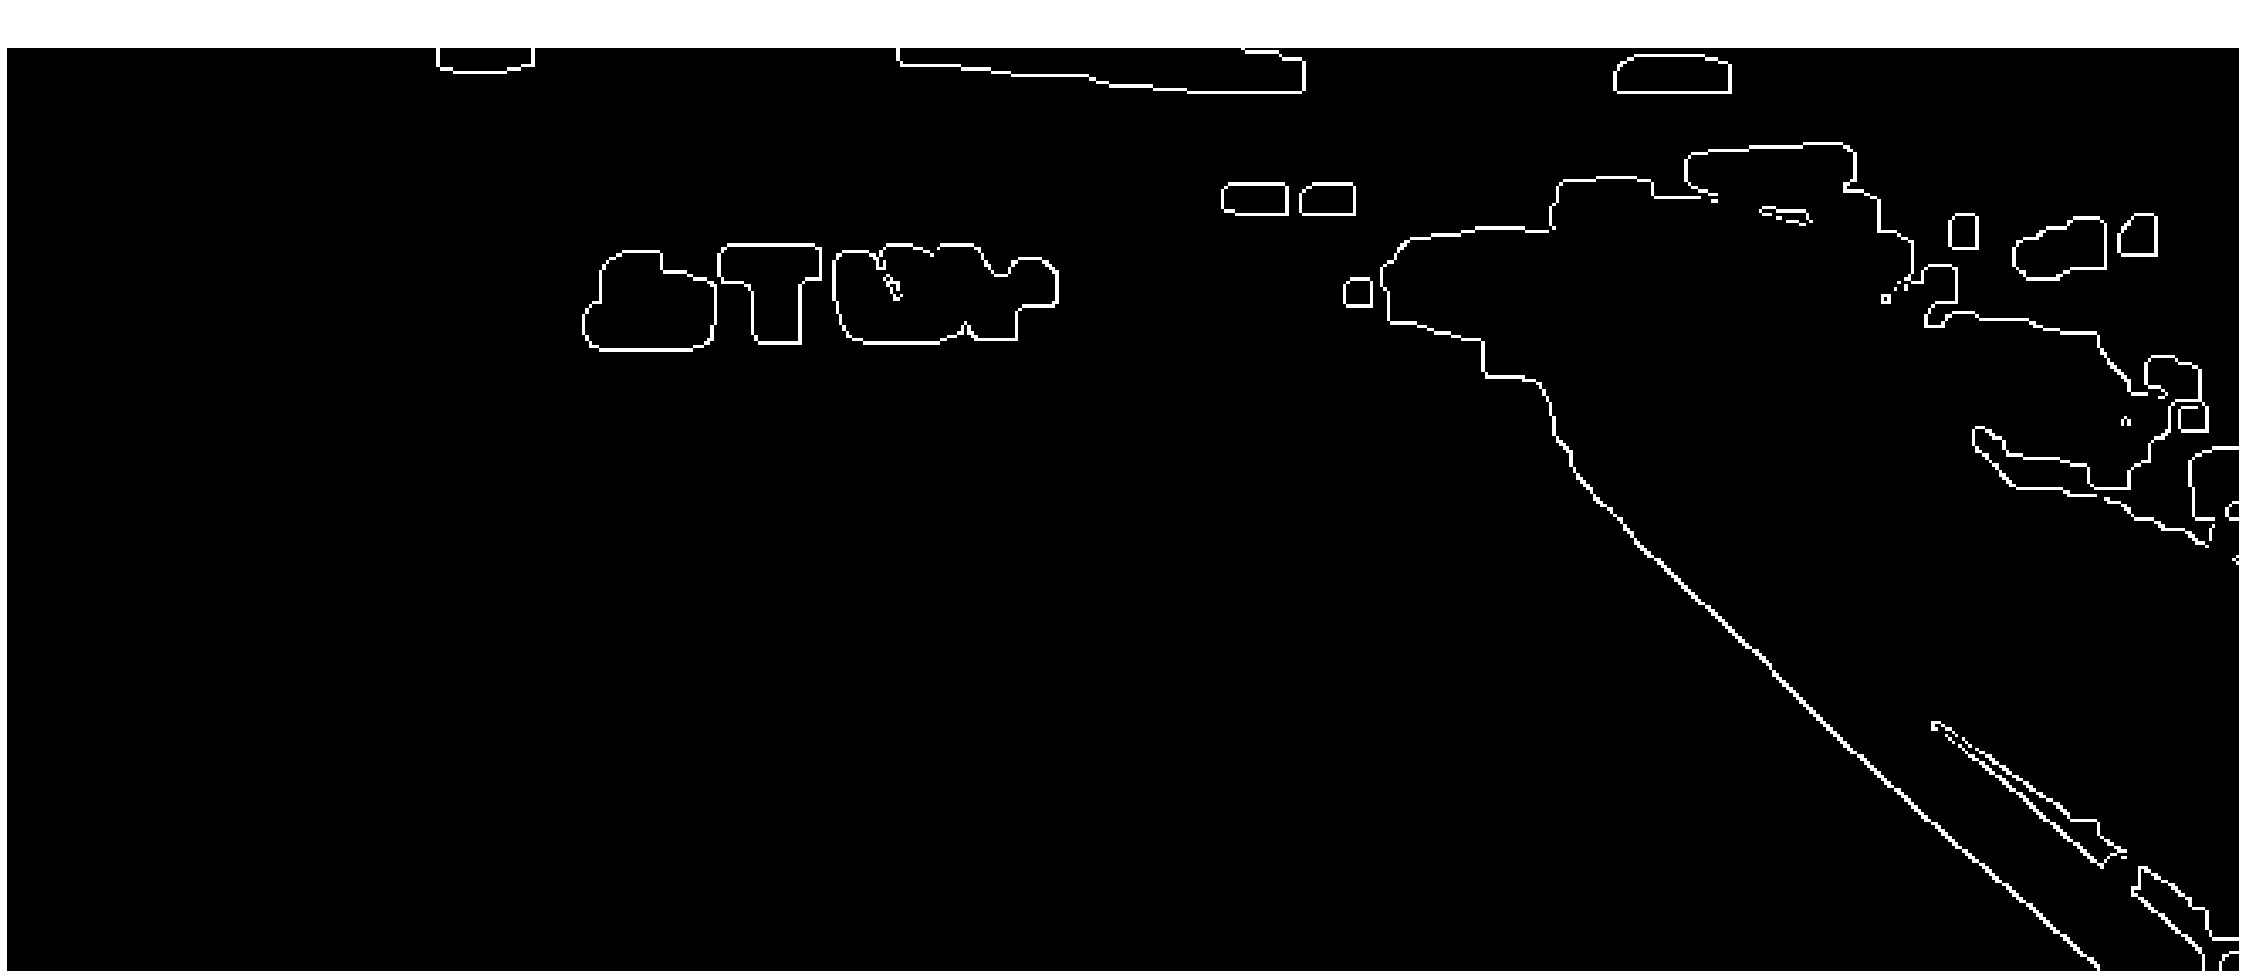

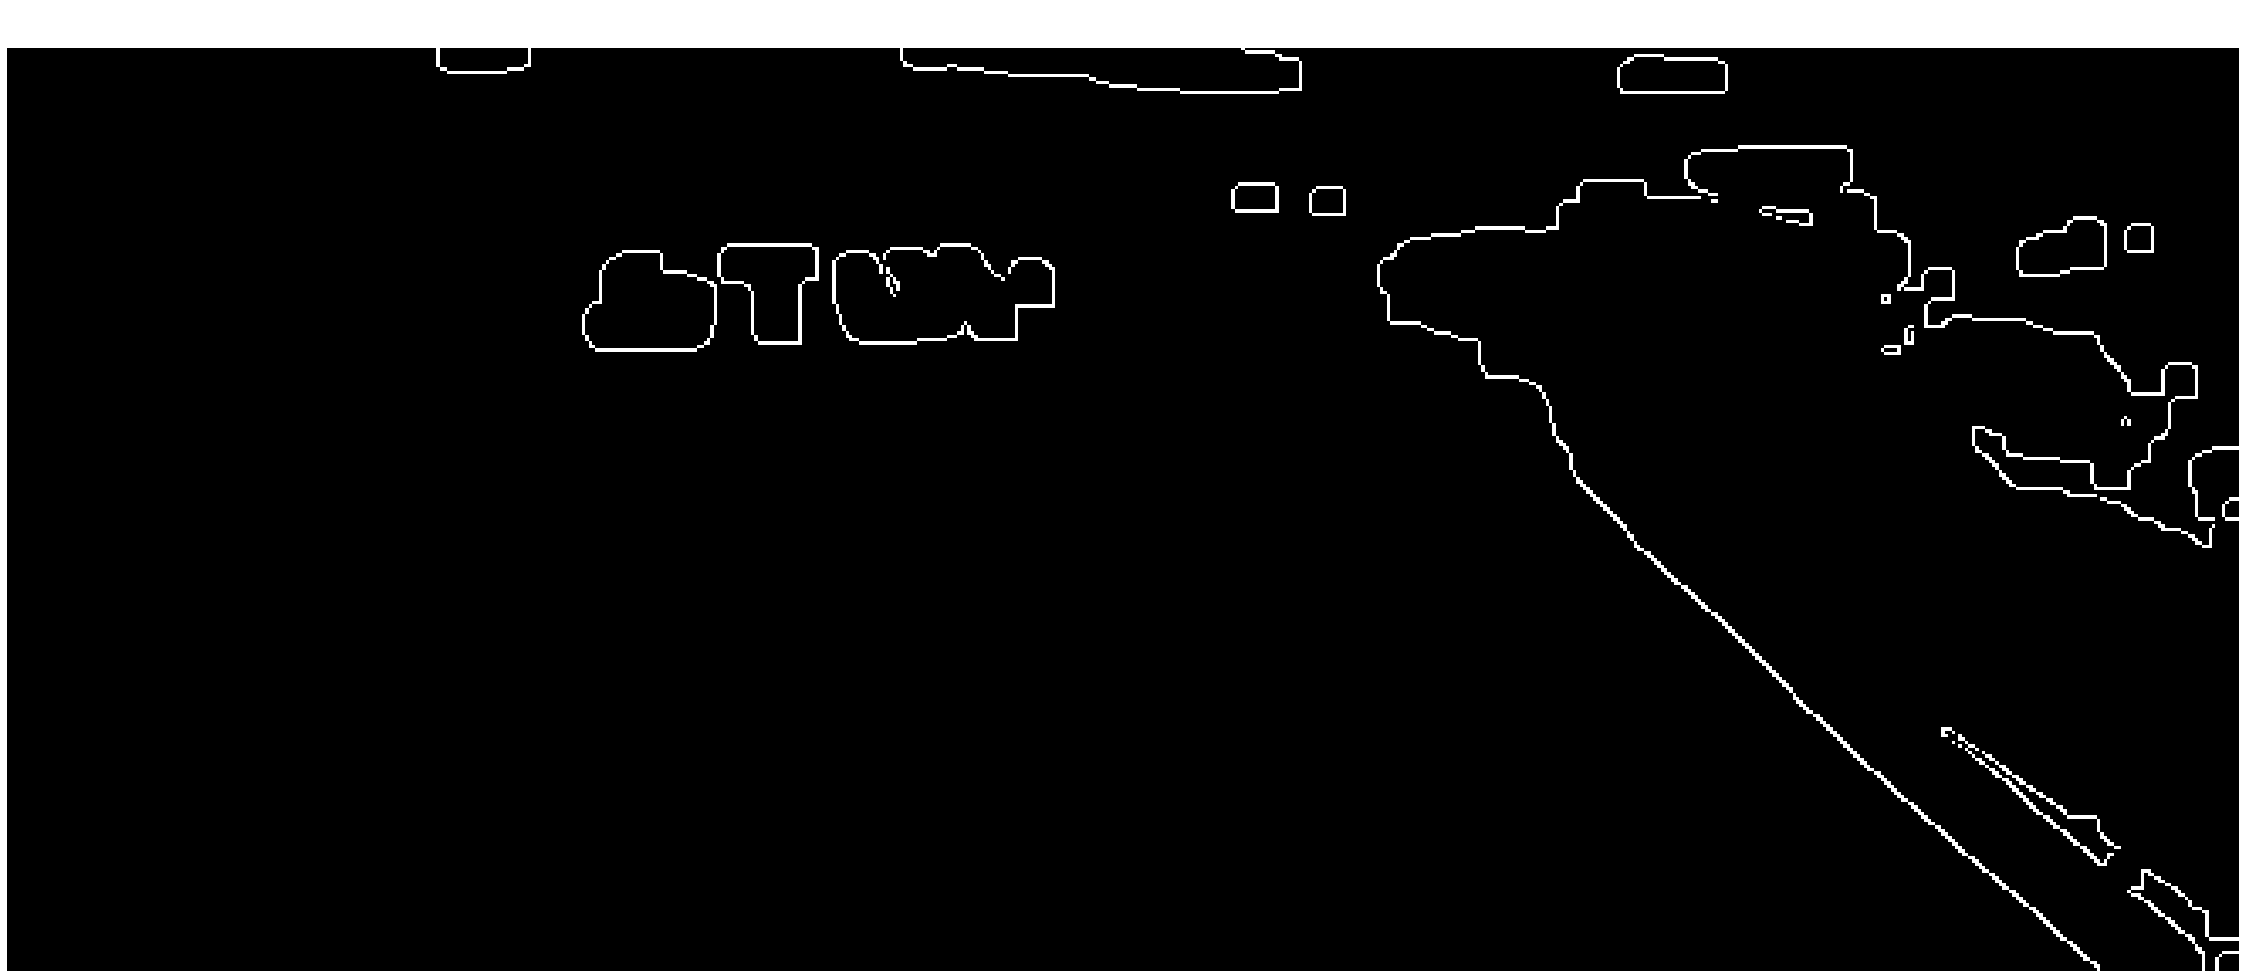

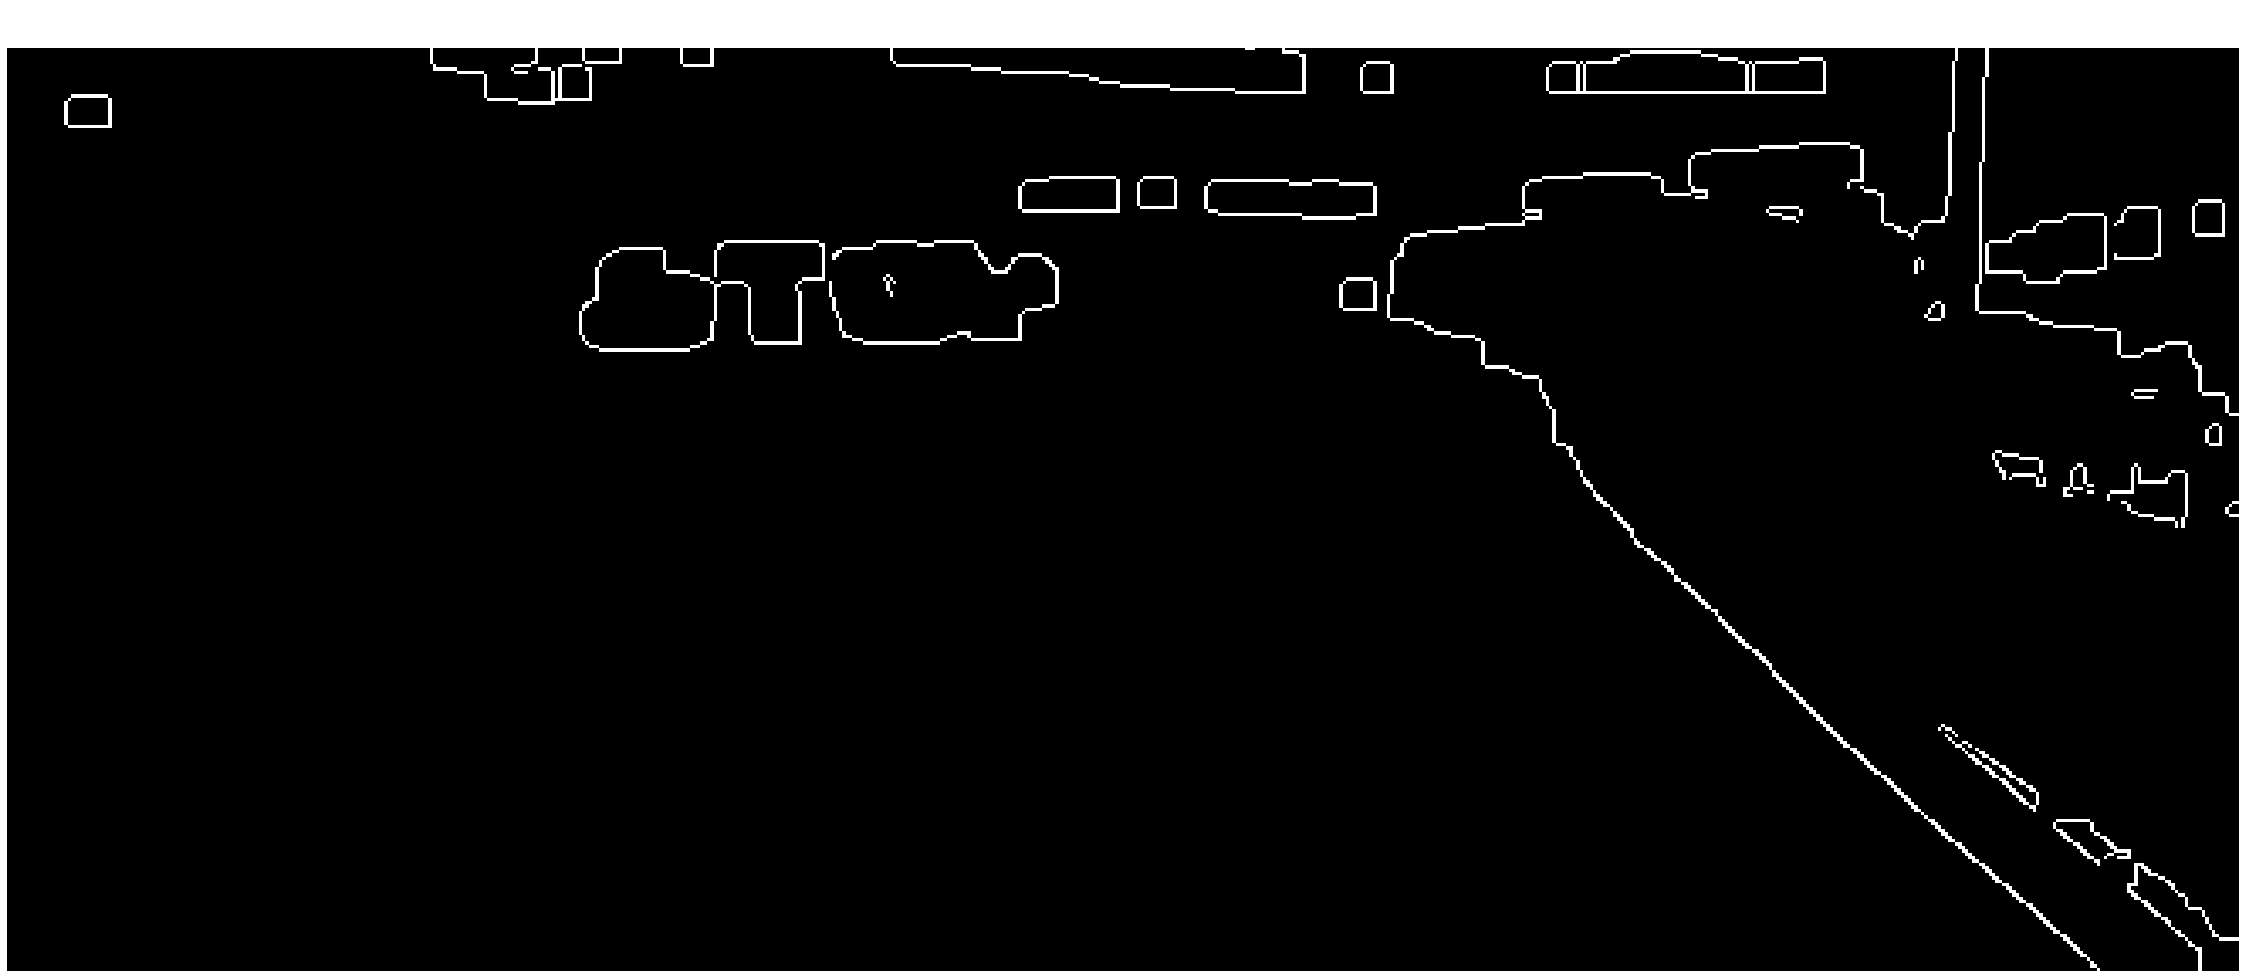

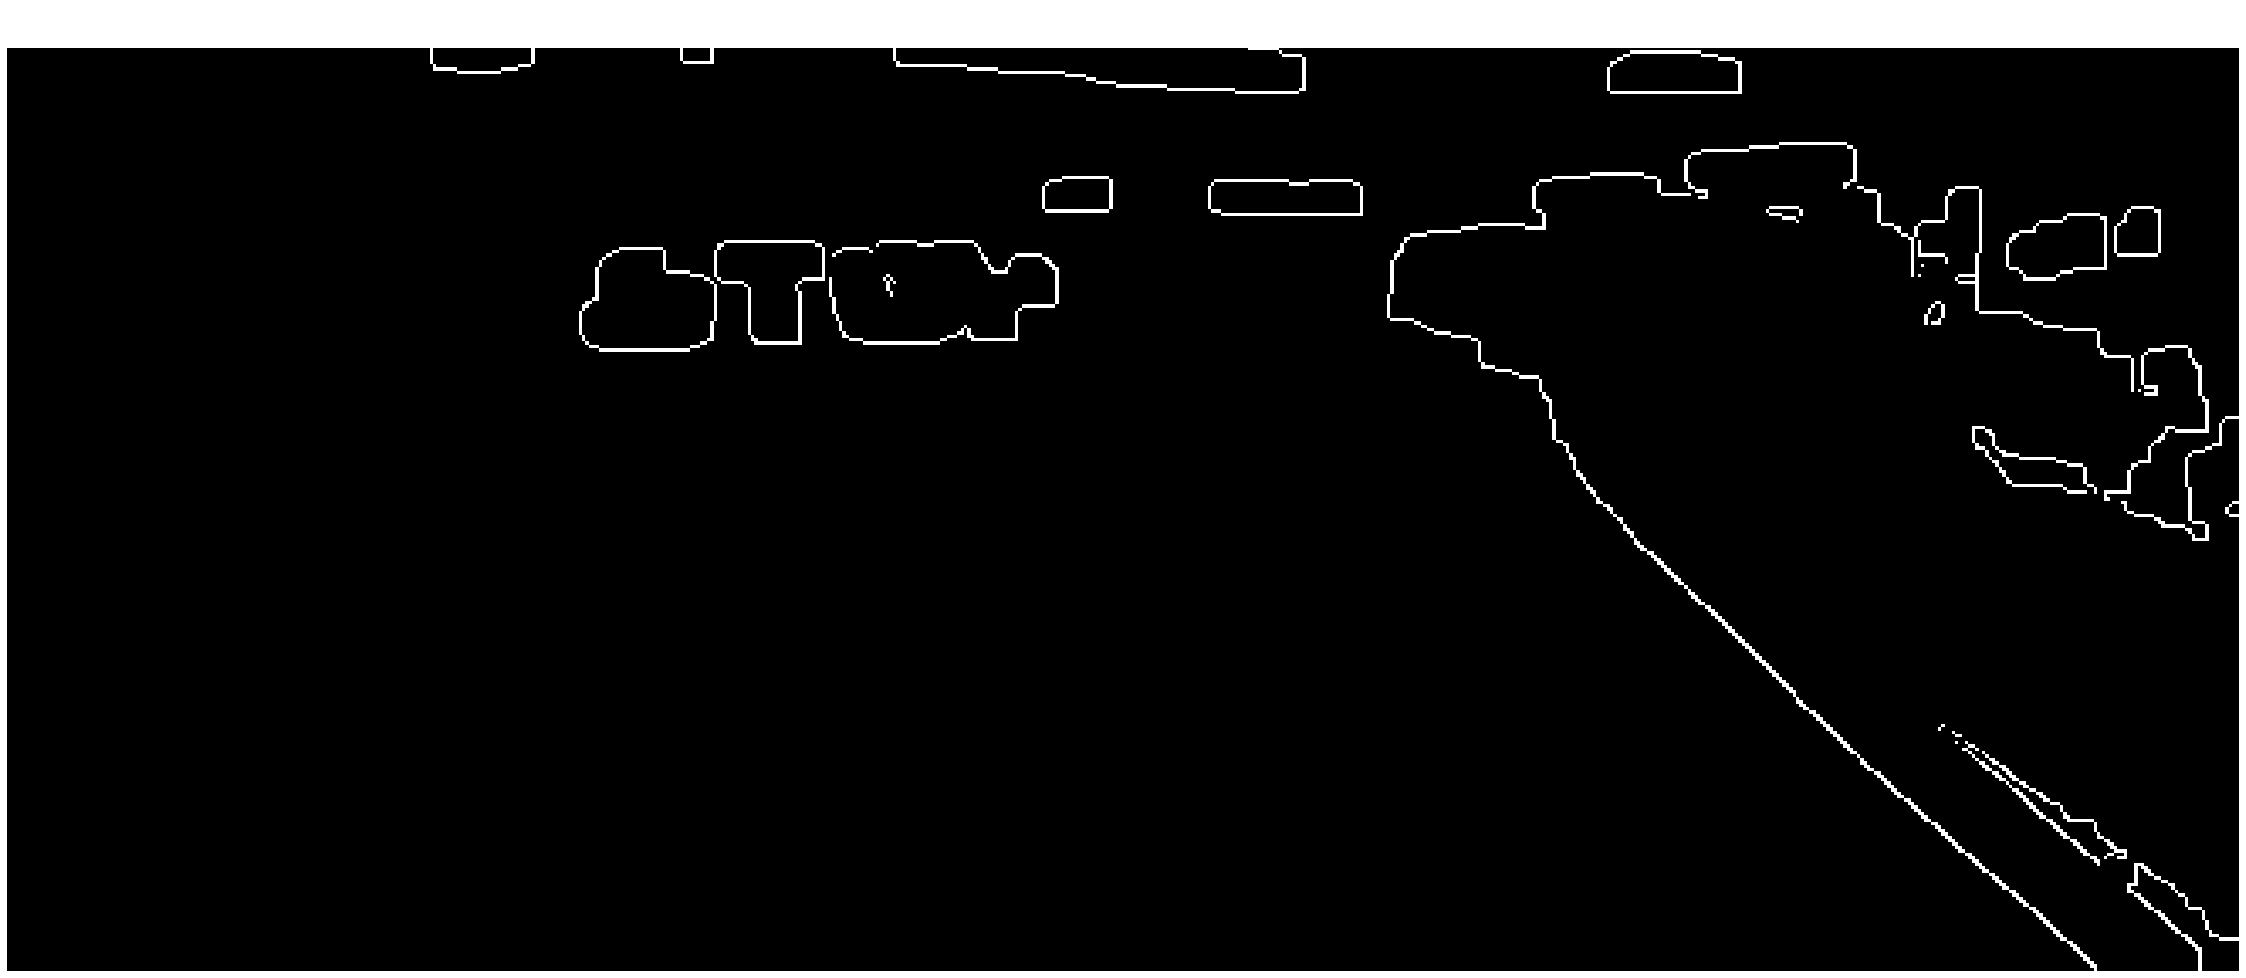

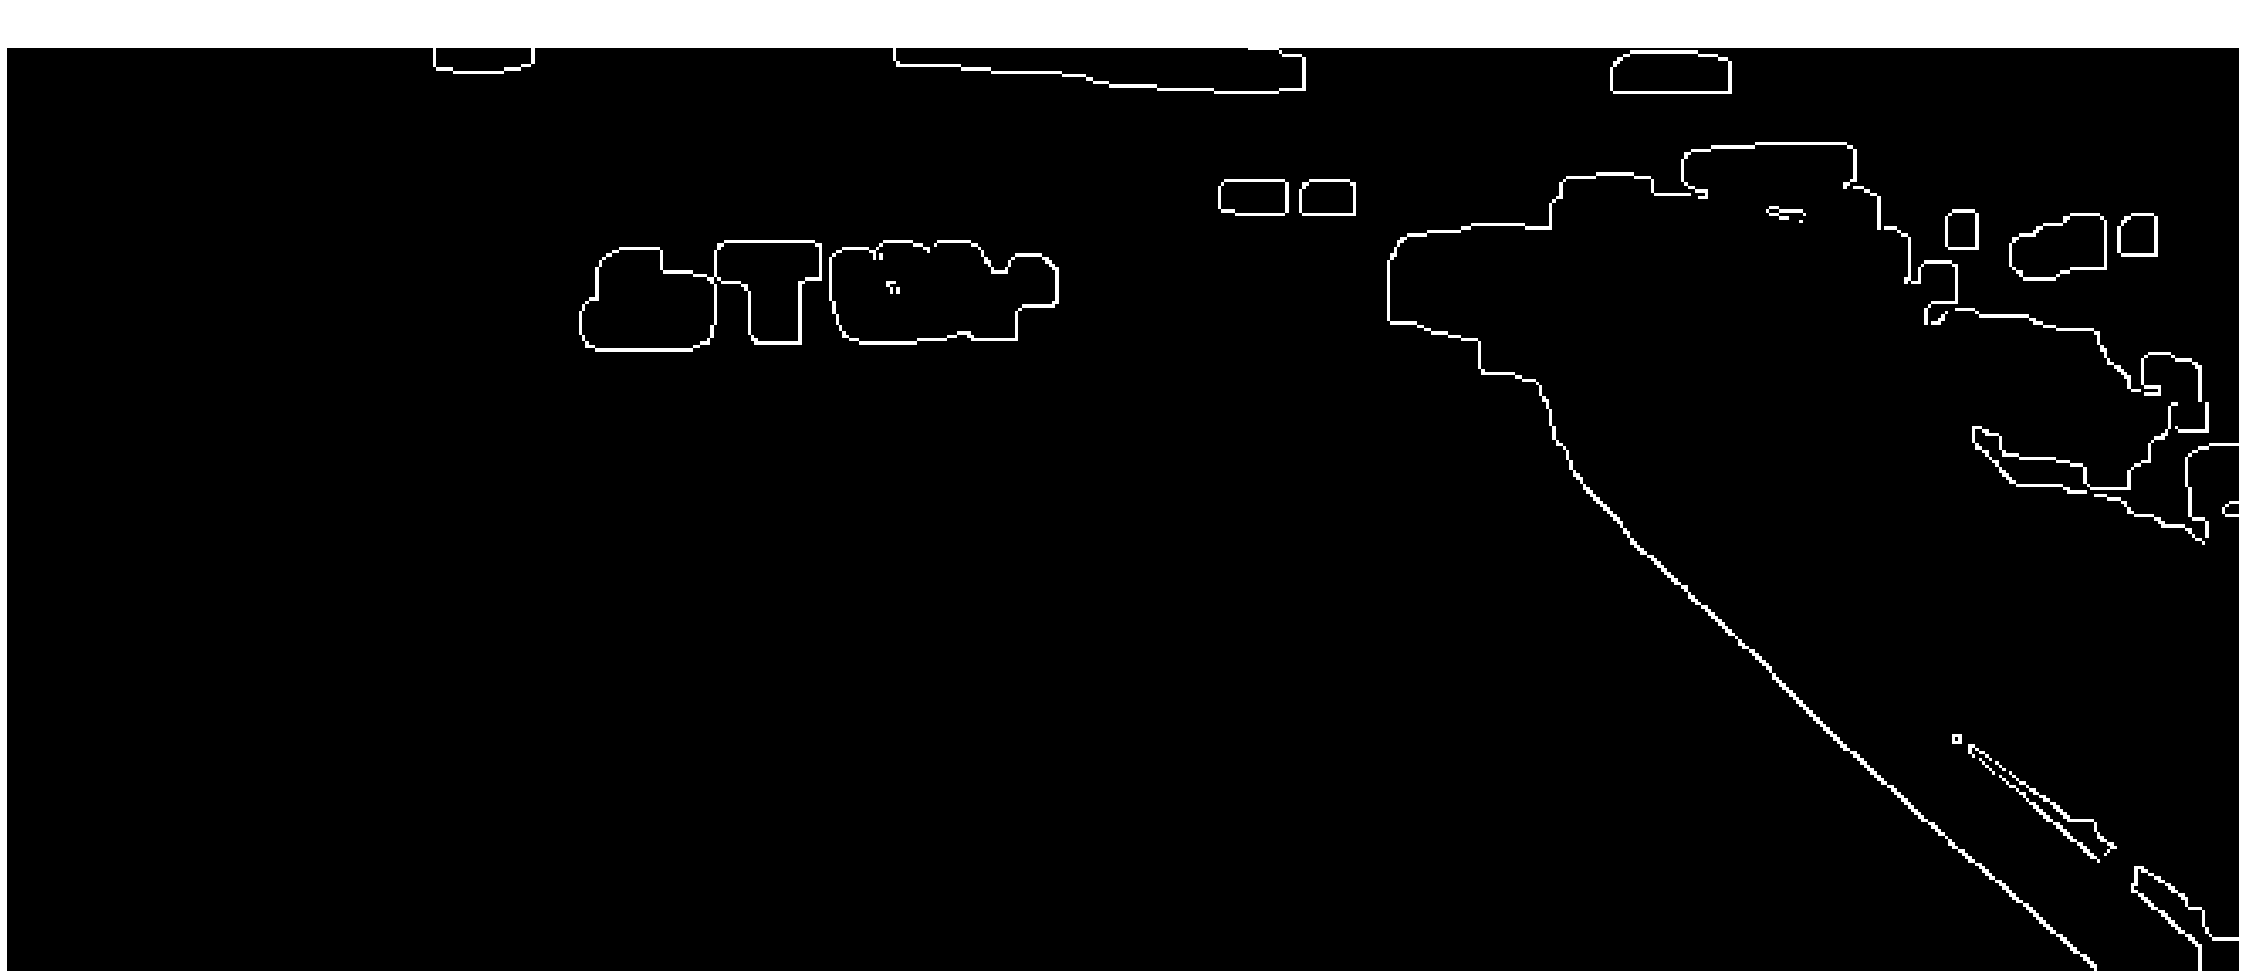

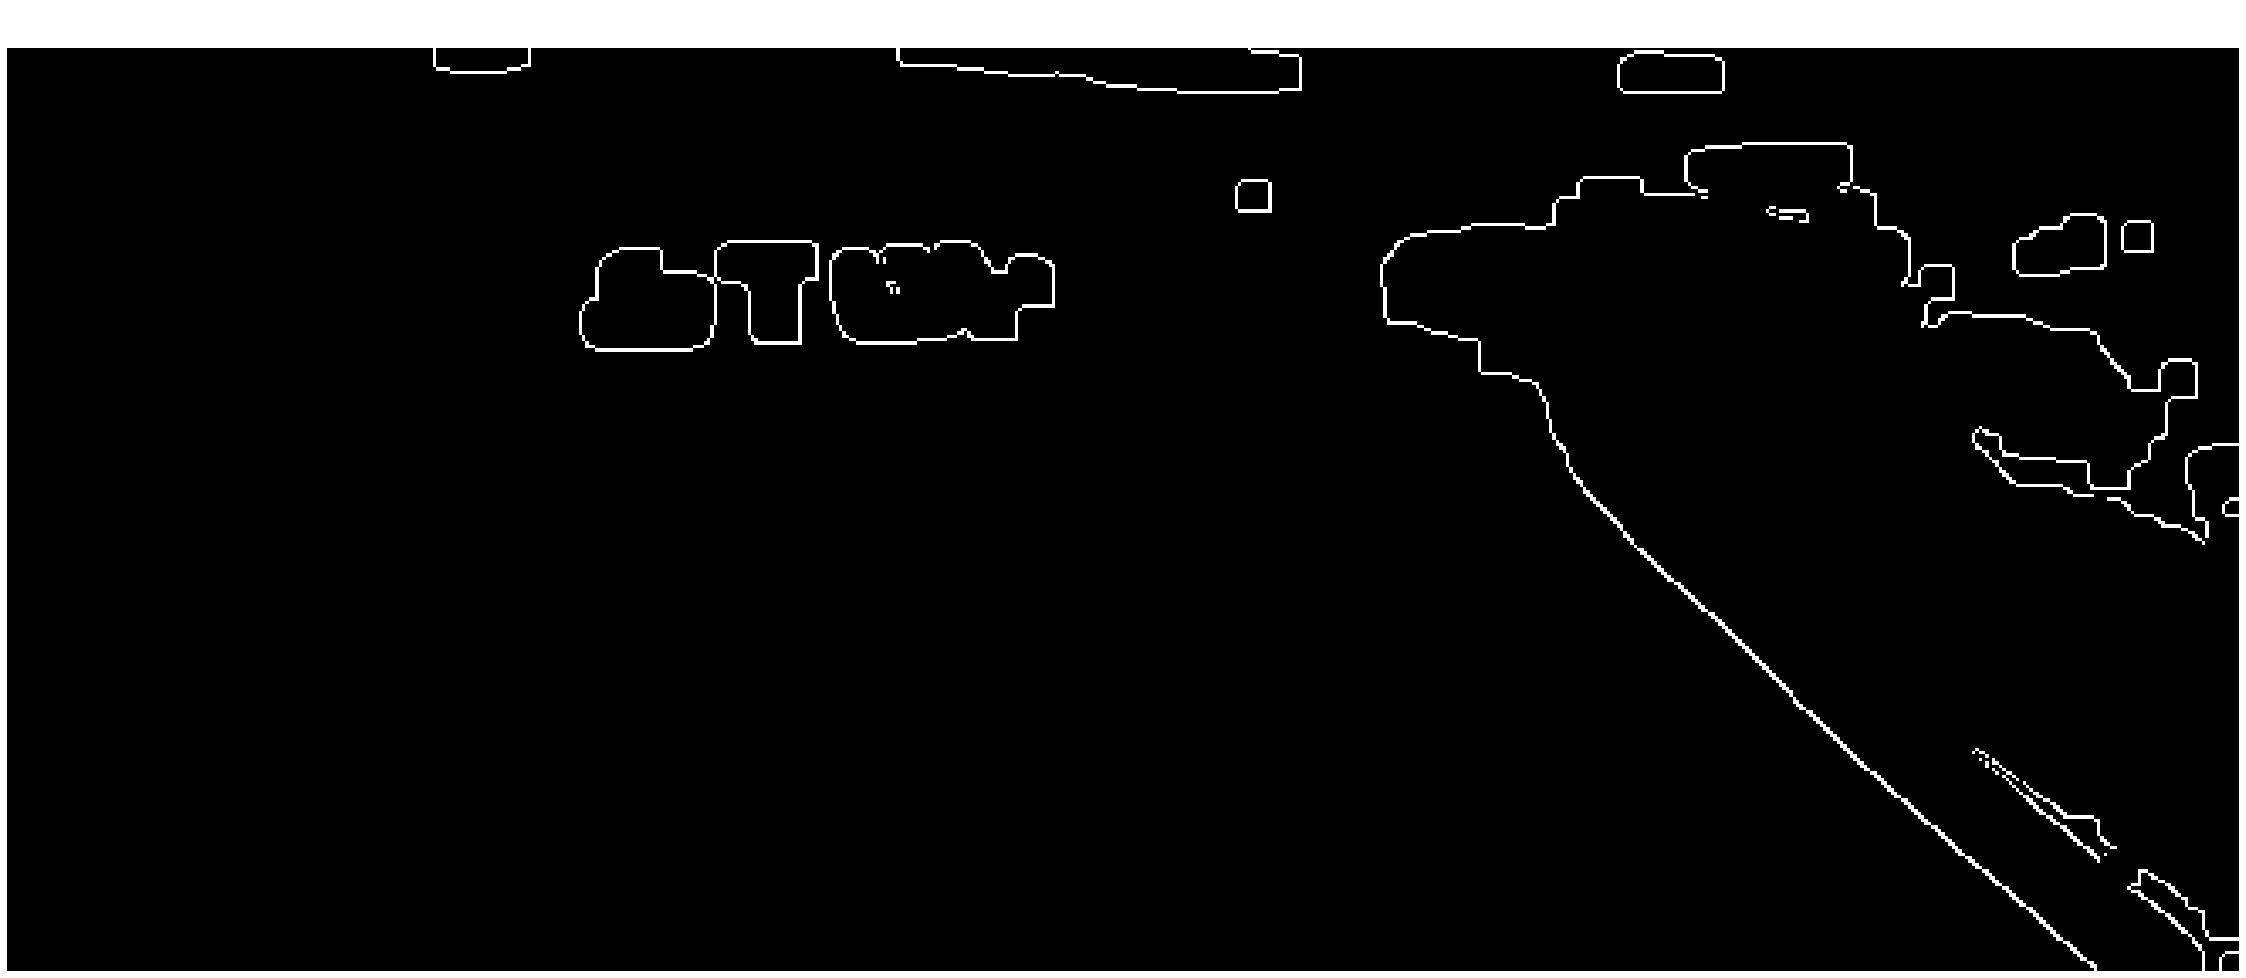

In [168]:
# Pipeline
def apply_pipeline(images, dilation_kernel_size, blurring_kernel_size, is_direct=False):
    new_images = []
    for (image, filename) in images:
        if is_direct:
            new_image = gaussian_blurring(image)
            new_image = image_segmentation_using_color_masking(new_image)

        else:
            new_image = crop_images(image, crop_ratio=0.45)
            new_image = gray_scale(new_image)
            new_image = gaussian_blurring(new_image, blurring_kernel_size)
            new_image = dilation(new_image, kernel_size=dilation_kernel_size, iterations=1)
            new_image = thresholding(new_image)
            new_image = canny_edge_detection(new_image)

        new_images.append((new_image, filename))

    title = "Dilation={}, Blur={}".format(dilation_kernel_size, blurring_kernel_size)
    show_images(new_images, title=title, cmap='gray')

def apply_kernels(images, max_dilation_kernel_size, max_blurring_kernel_size):
    for dil_ker in range(2, max_dilation_kernel_size):
        for blurr_ker in range(2, max_blurring_kernel_size):
            try:
                #print("Using {} dilation kernel and {} blur kernel".format(dil_ker, blurr_ker))
                apply_pipeline(images, dil_ker, blurr_ker)
                #print("=============================")
            except:
                continue

apply_kernels(read_images("lane5_stop"), max_dilation_kernel_size=10, max_blurring_kernel_size=10)


In [ ]:

apply_pipeline(read_images(), dilation_kernel_size=4, blurring_kernel_size=3)

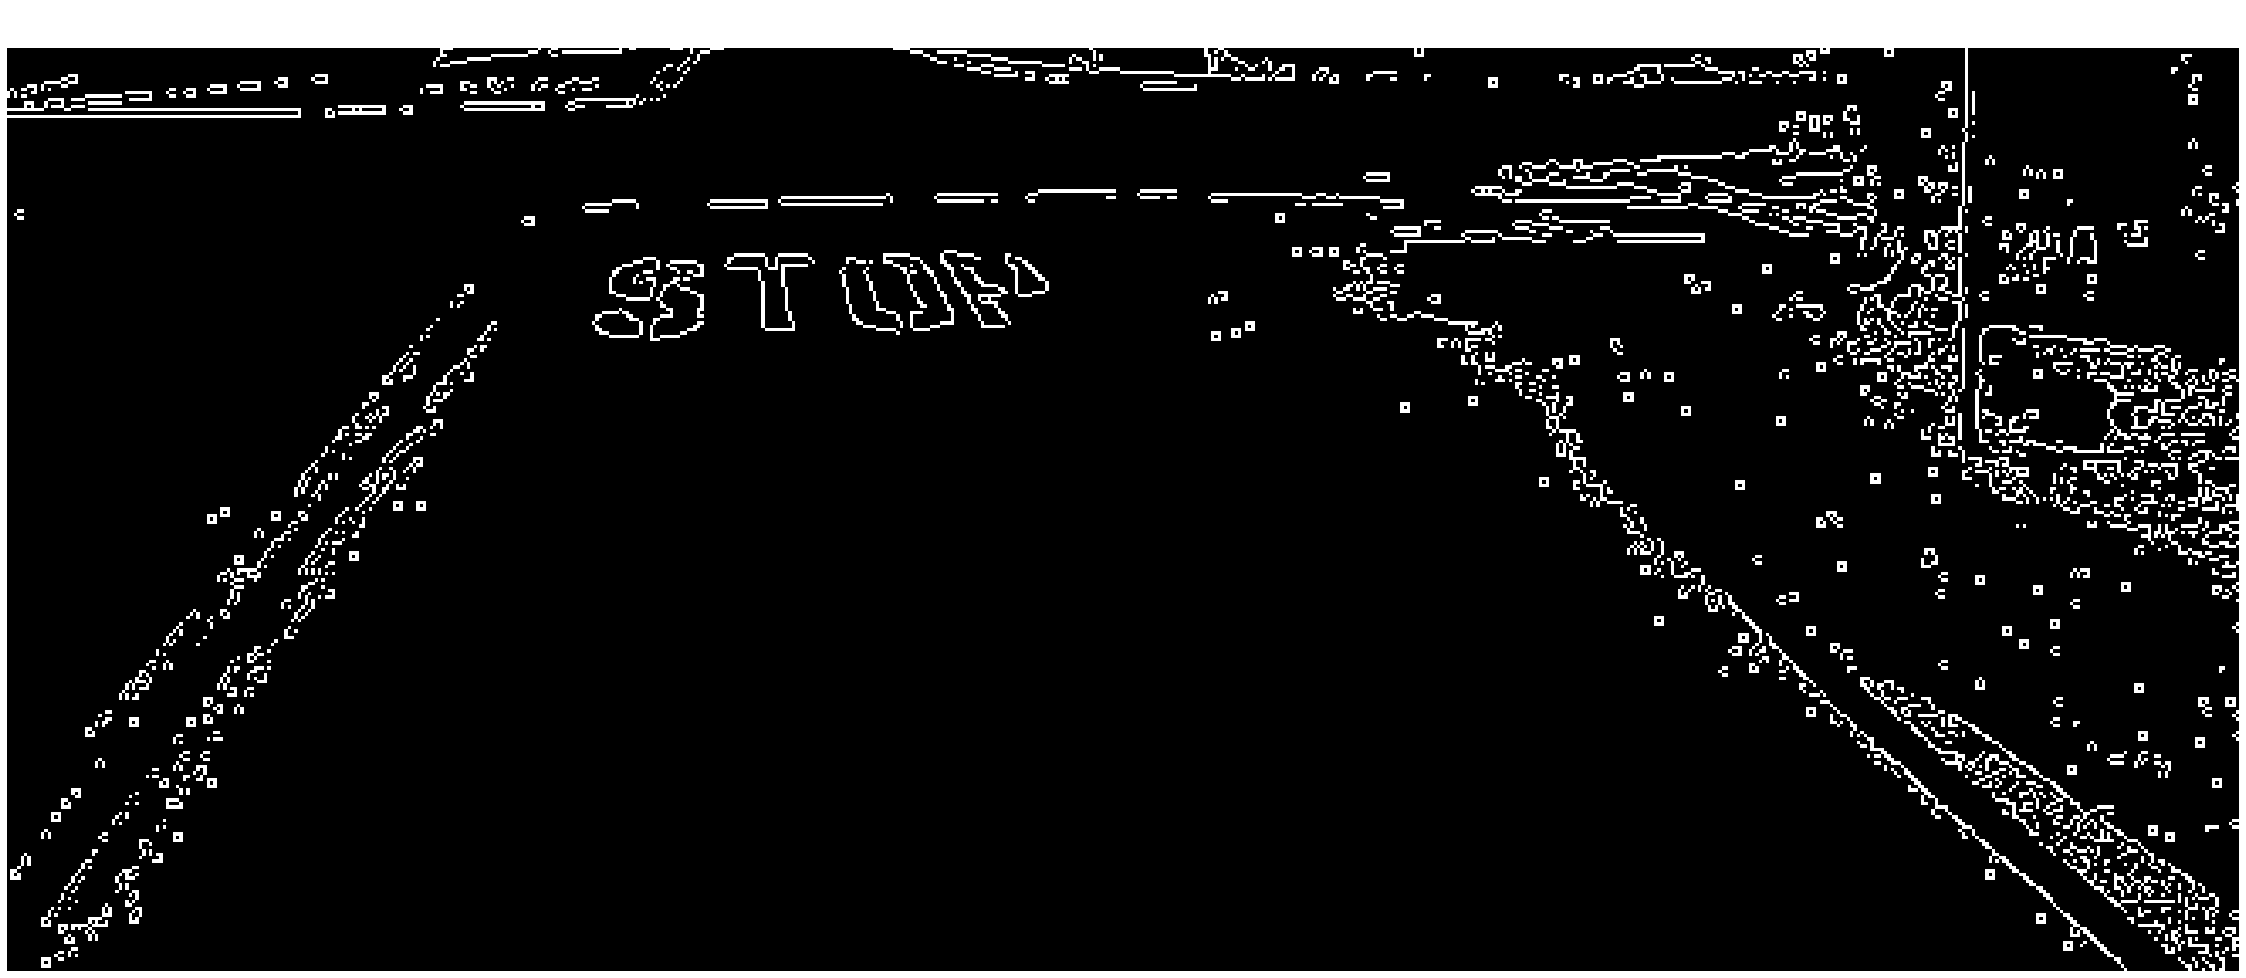

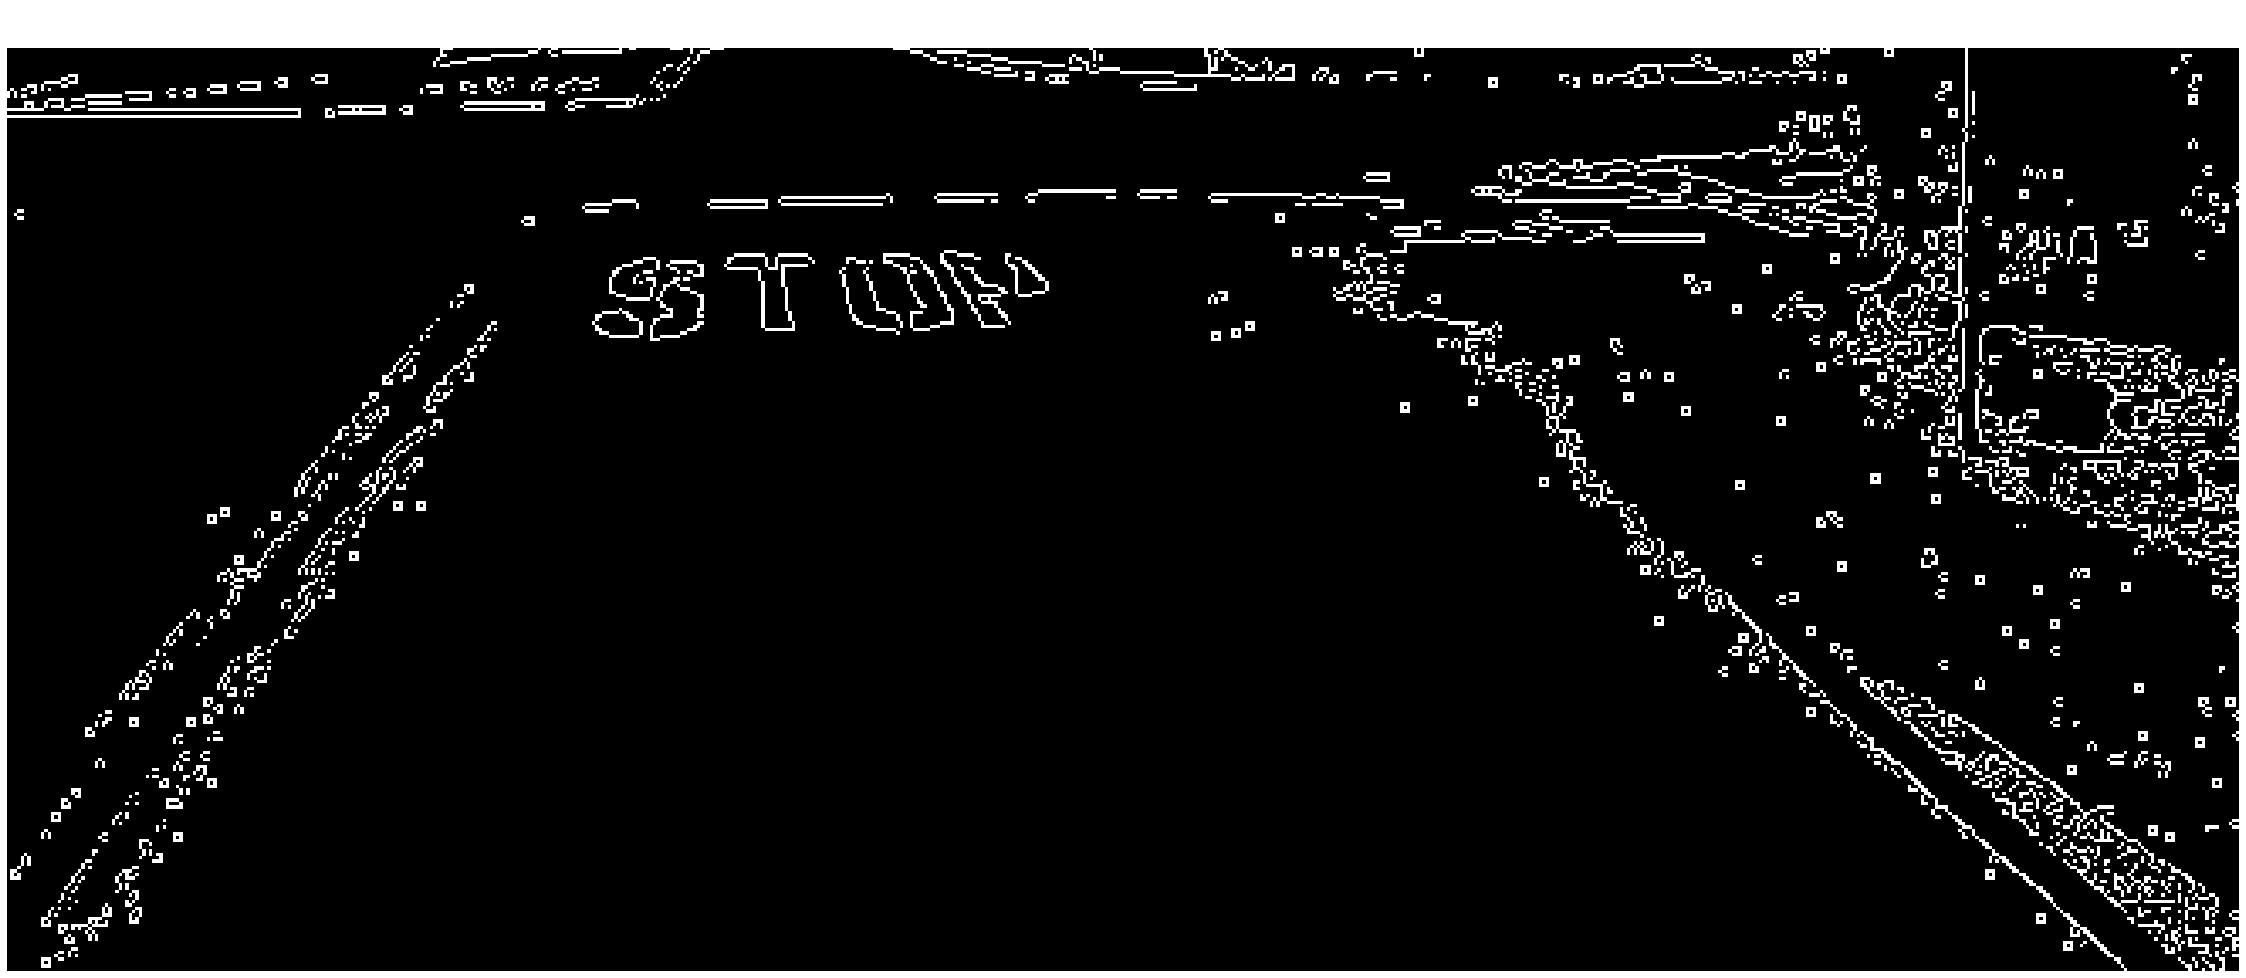

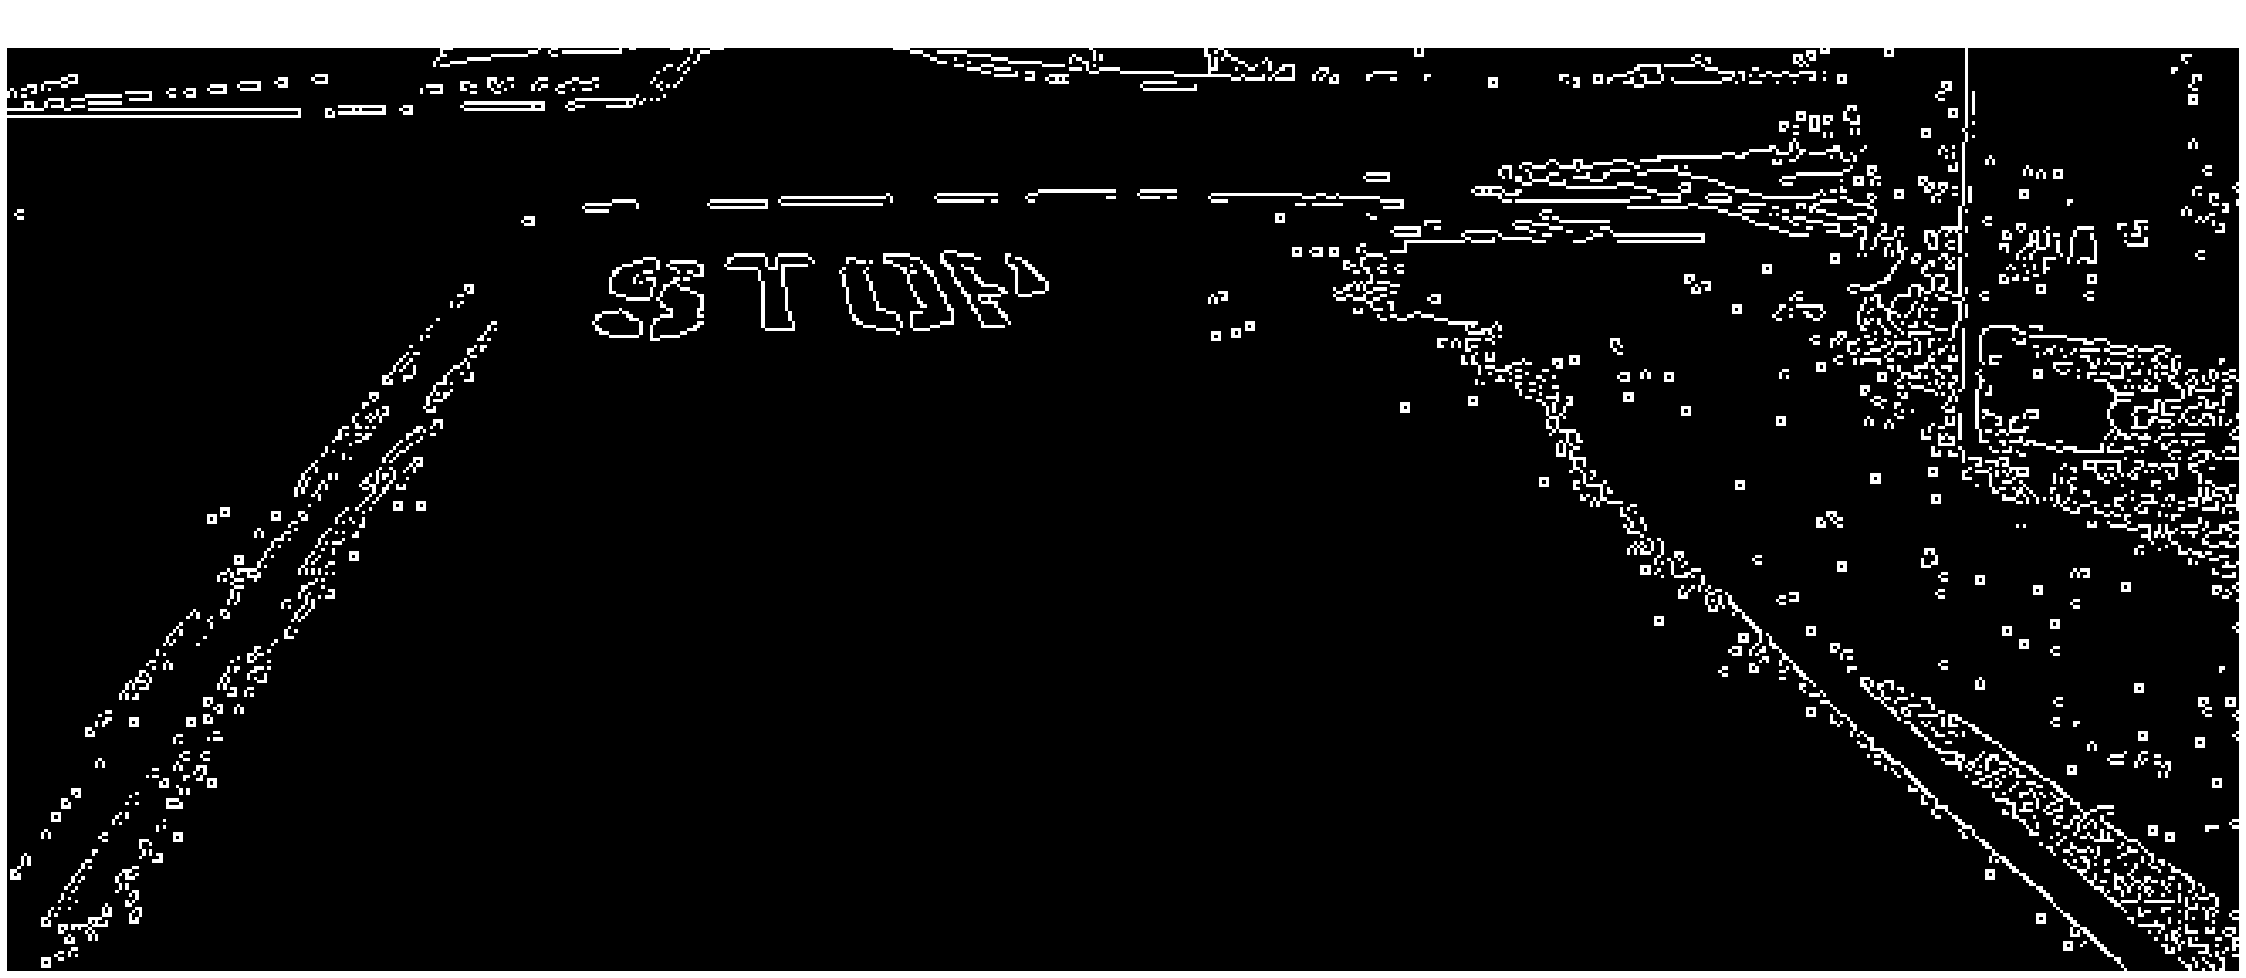

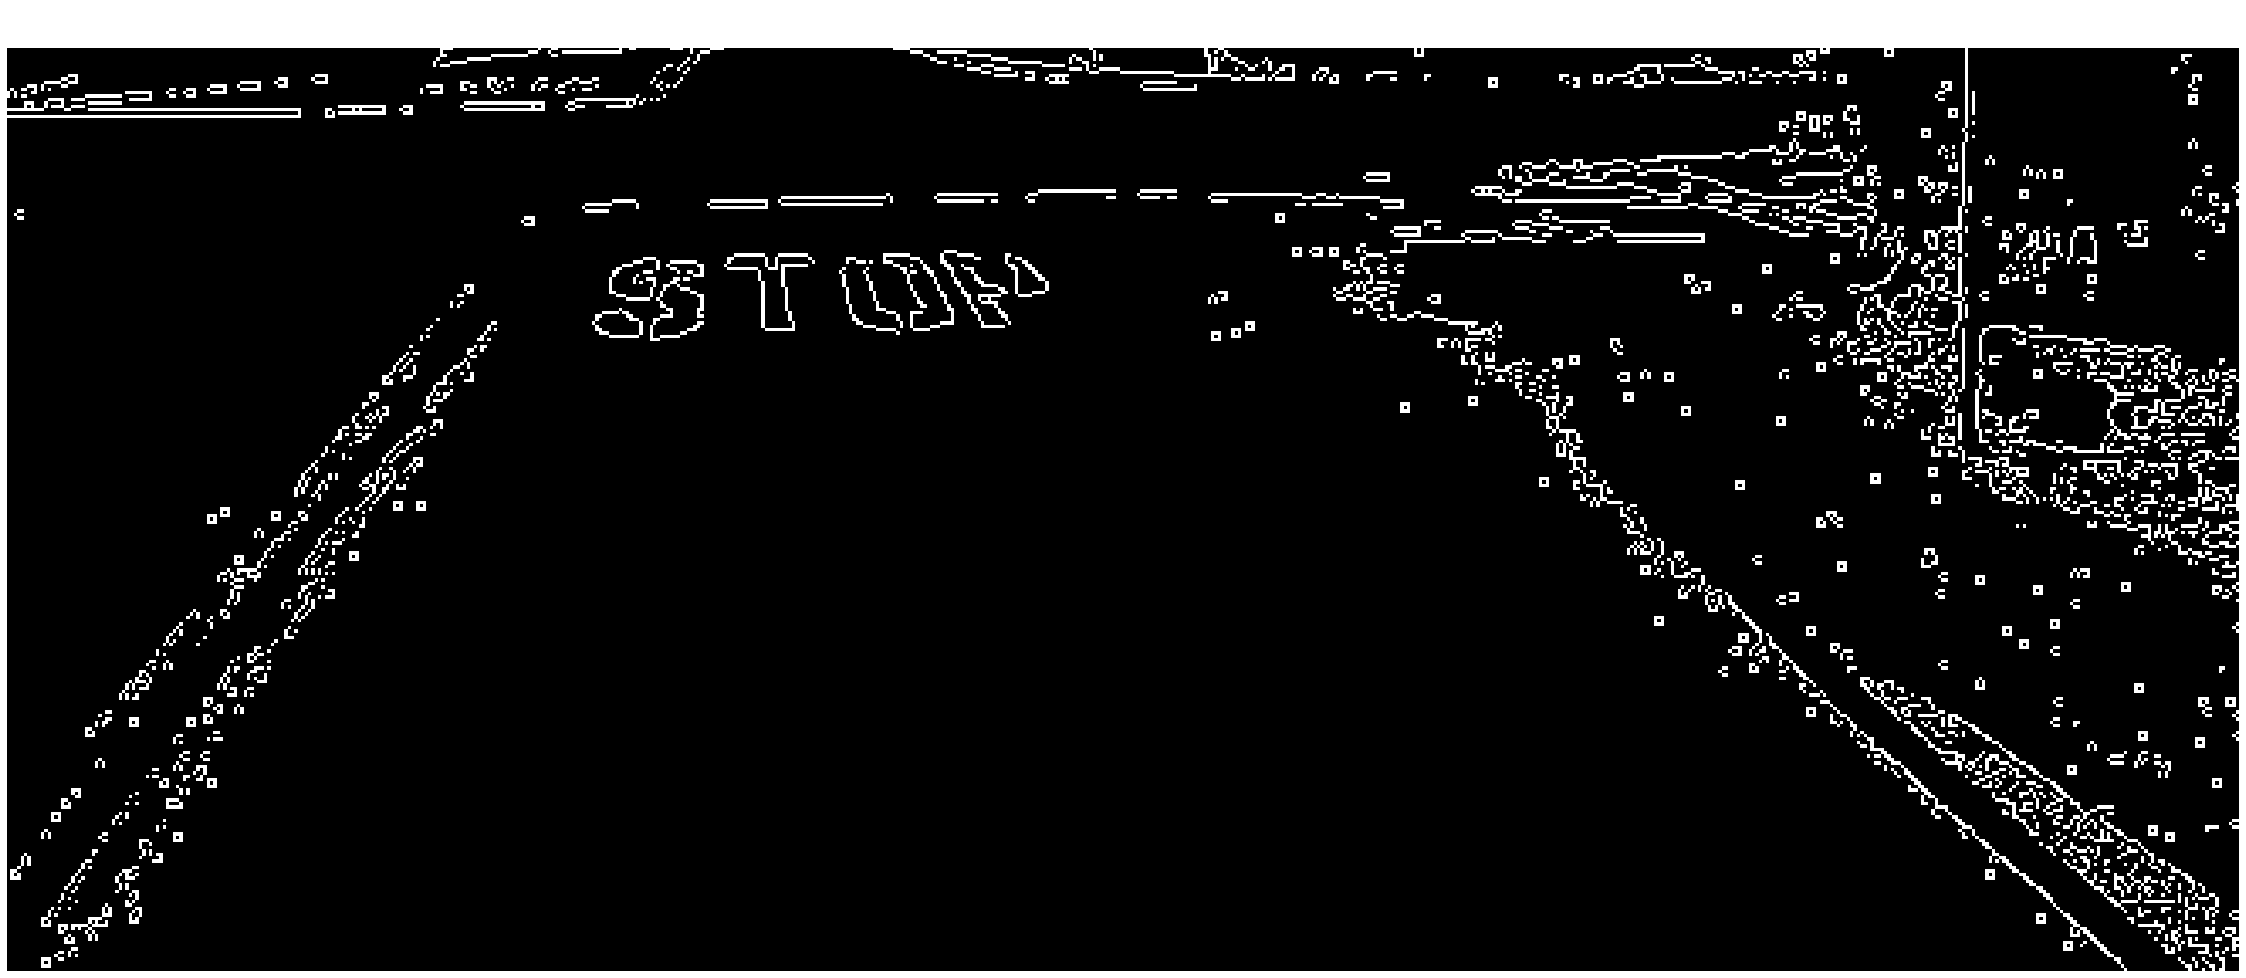

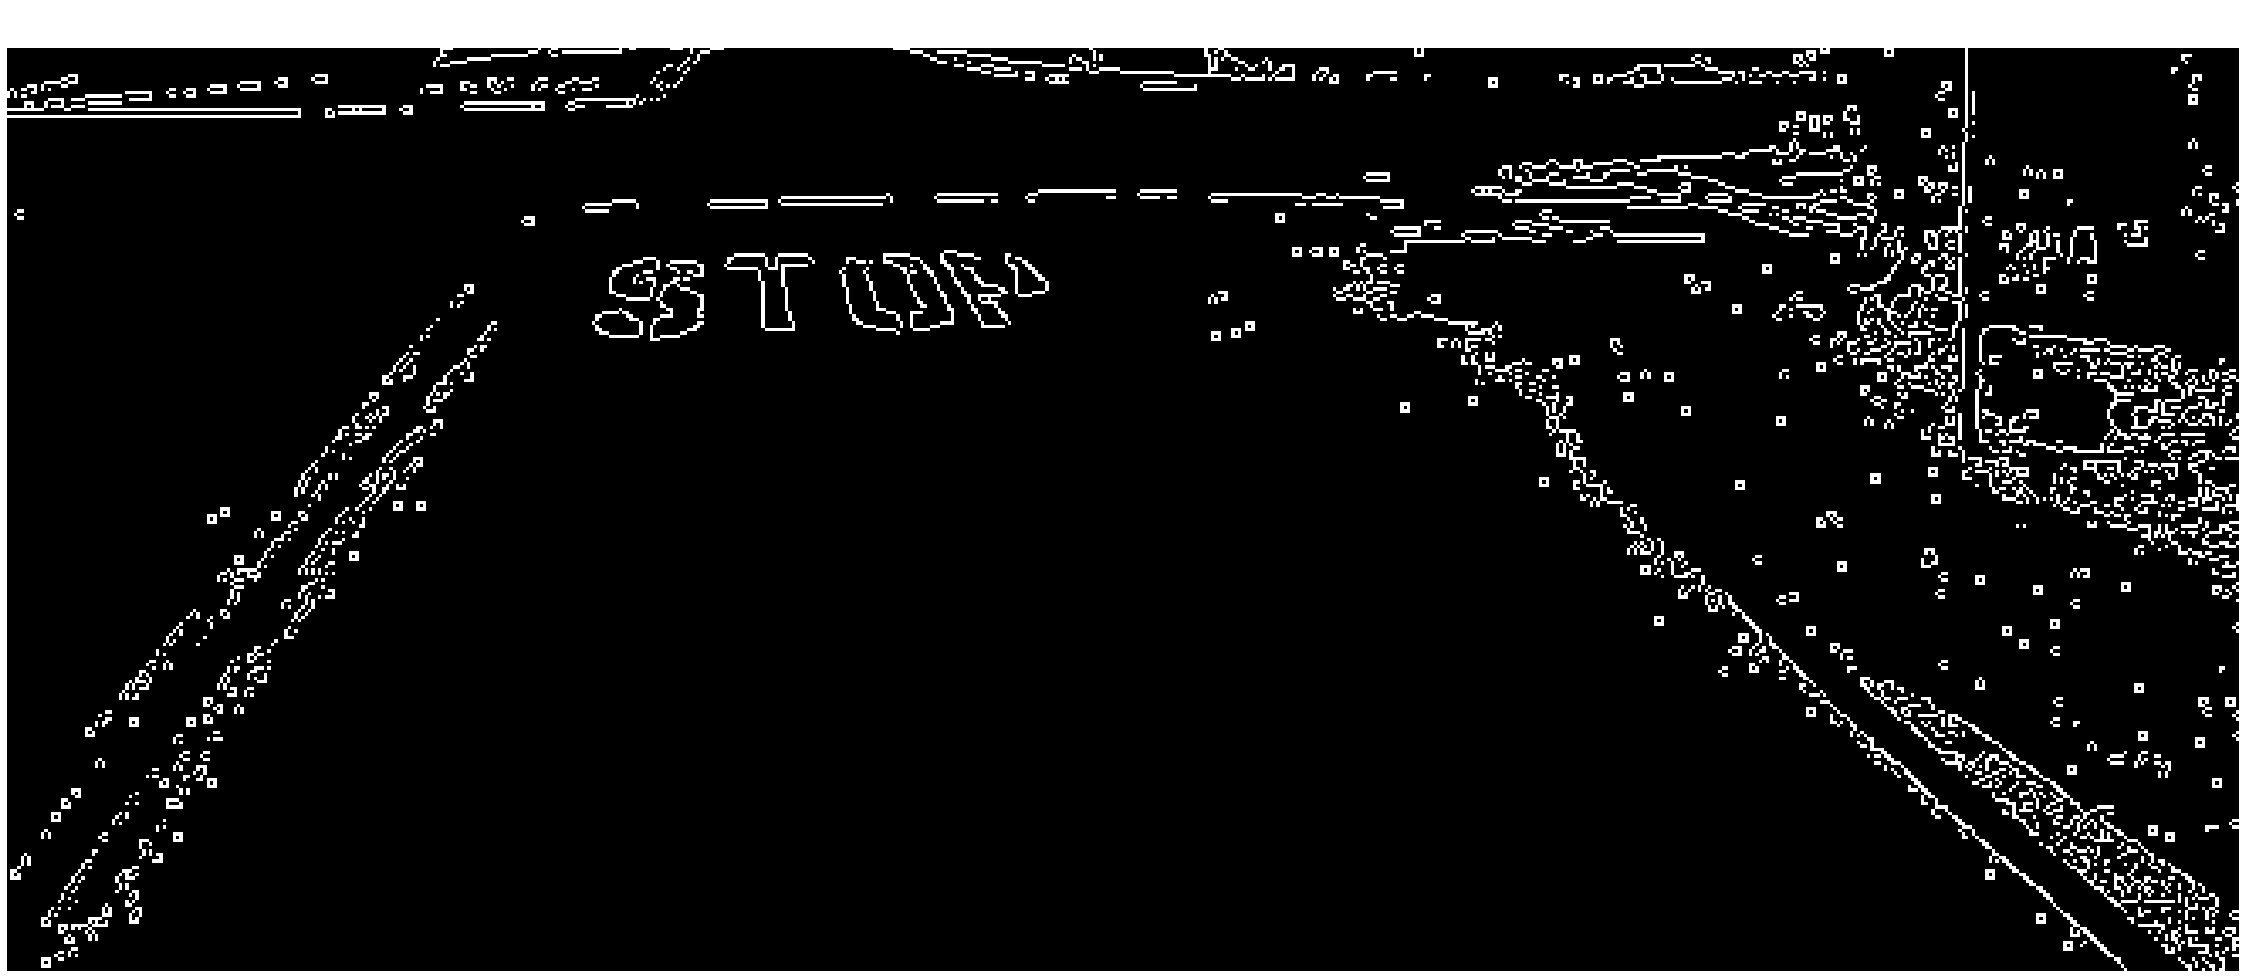

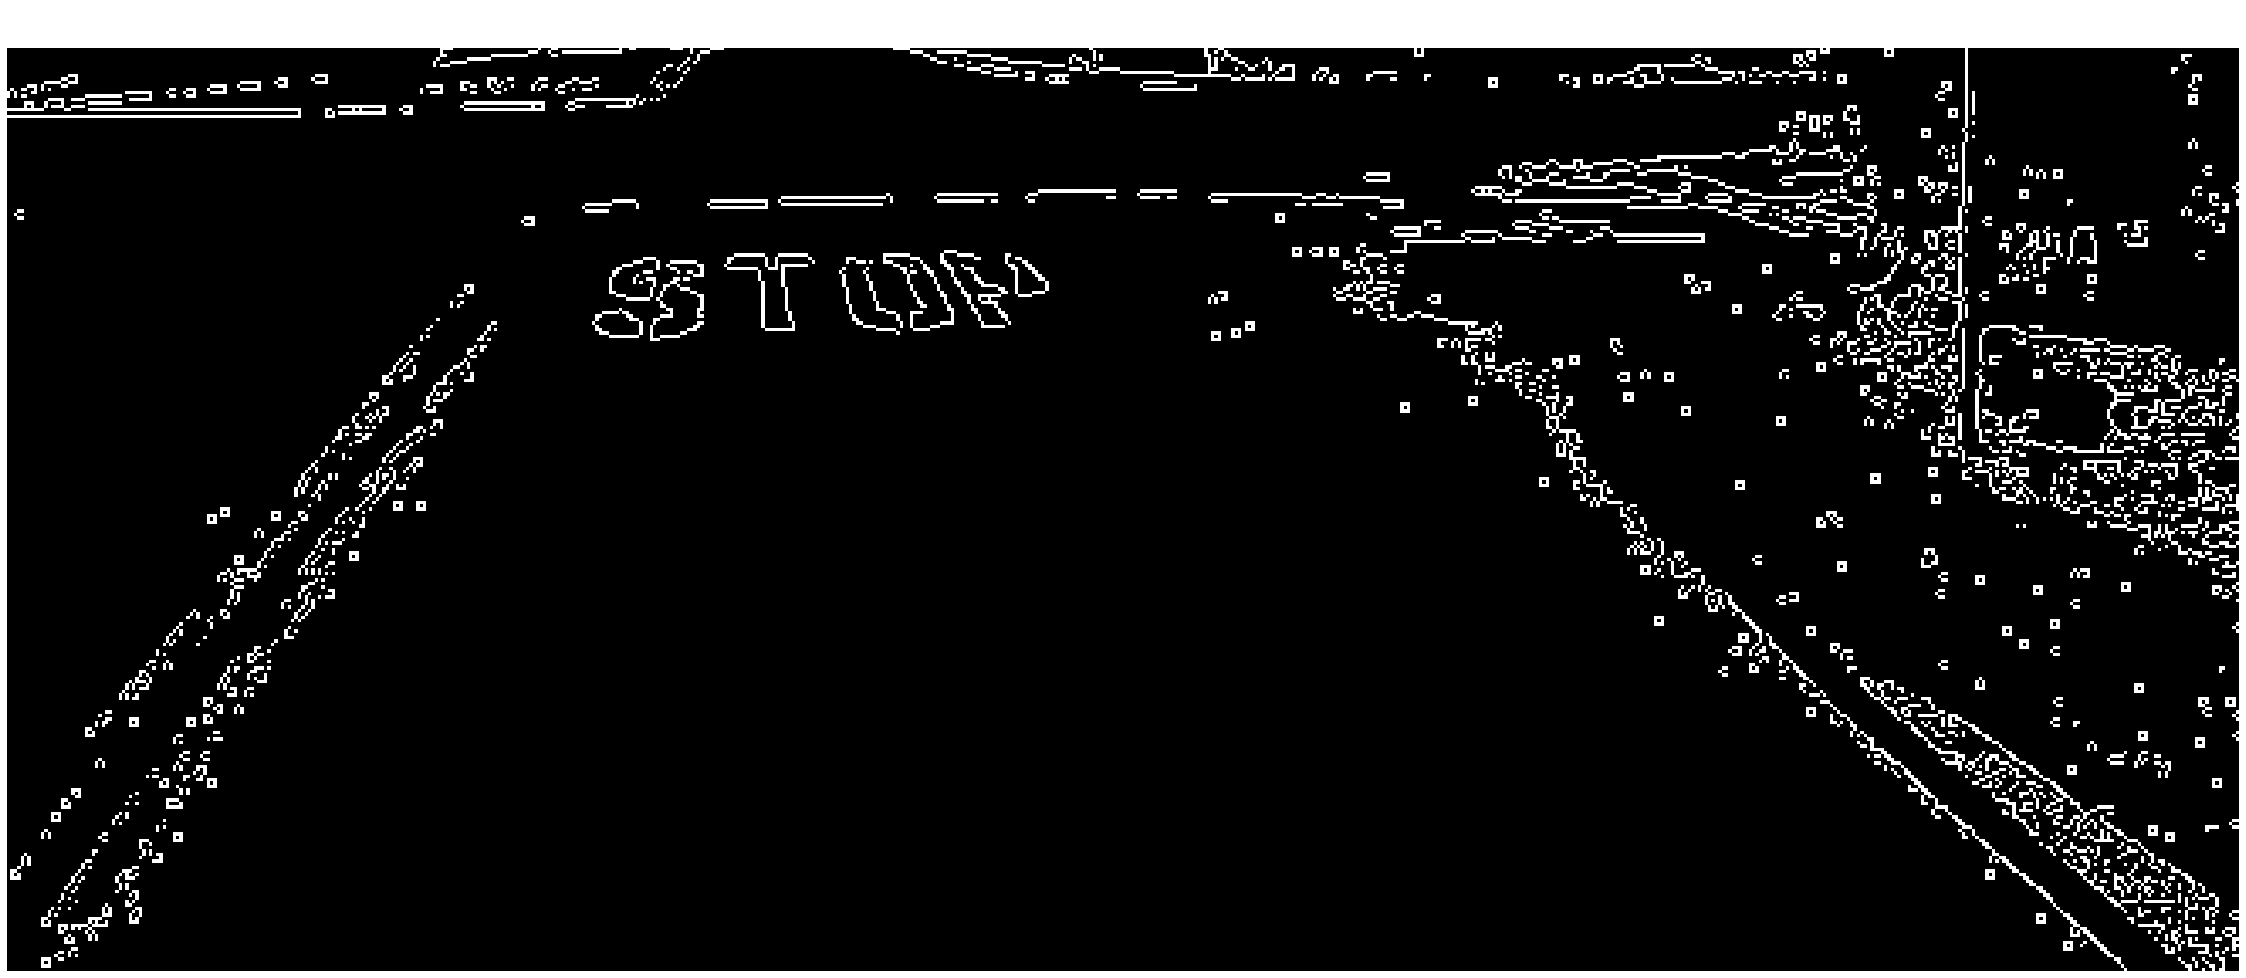

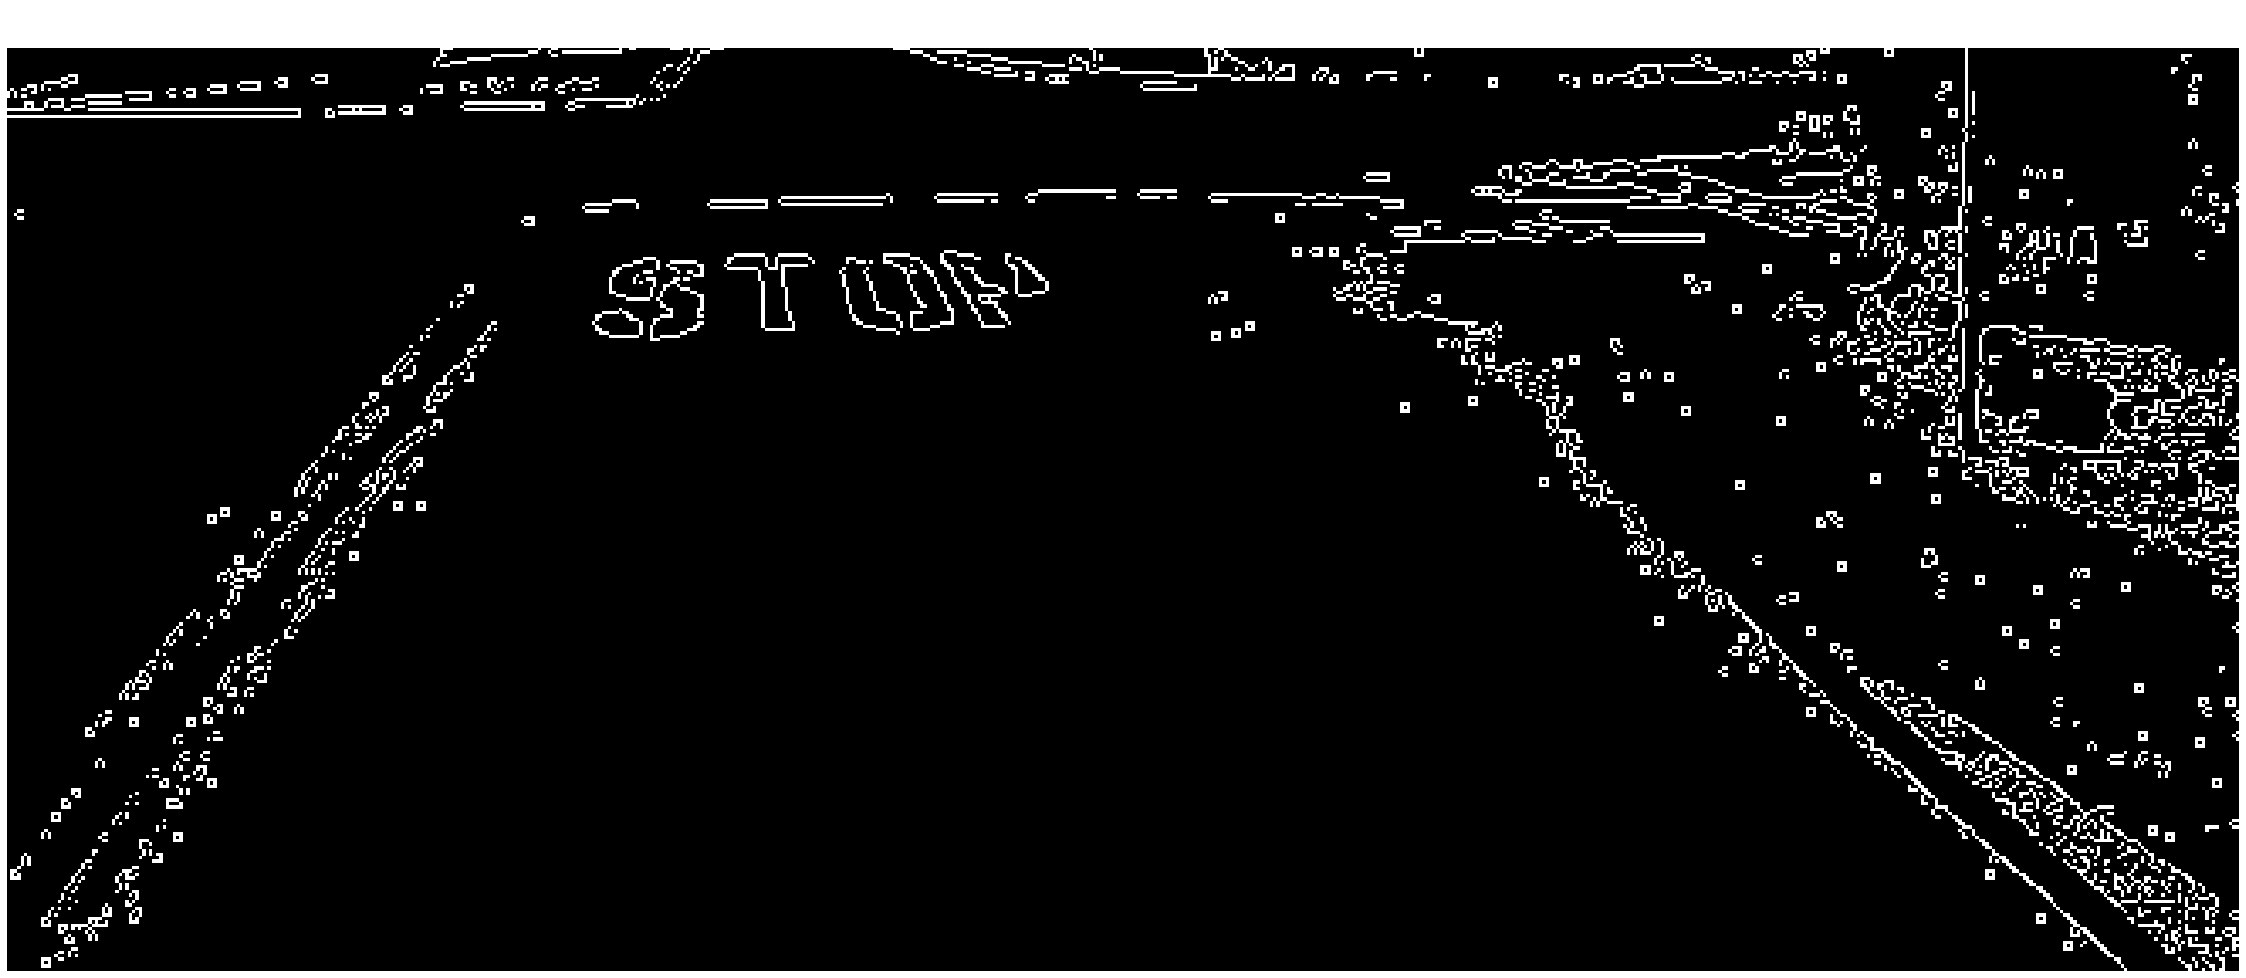

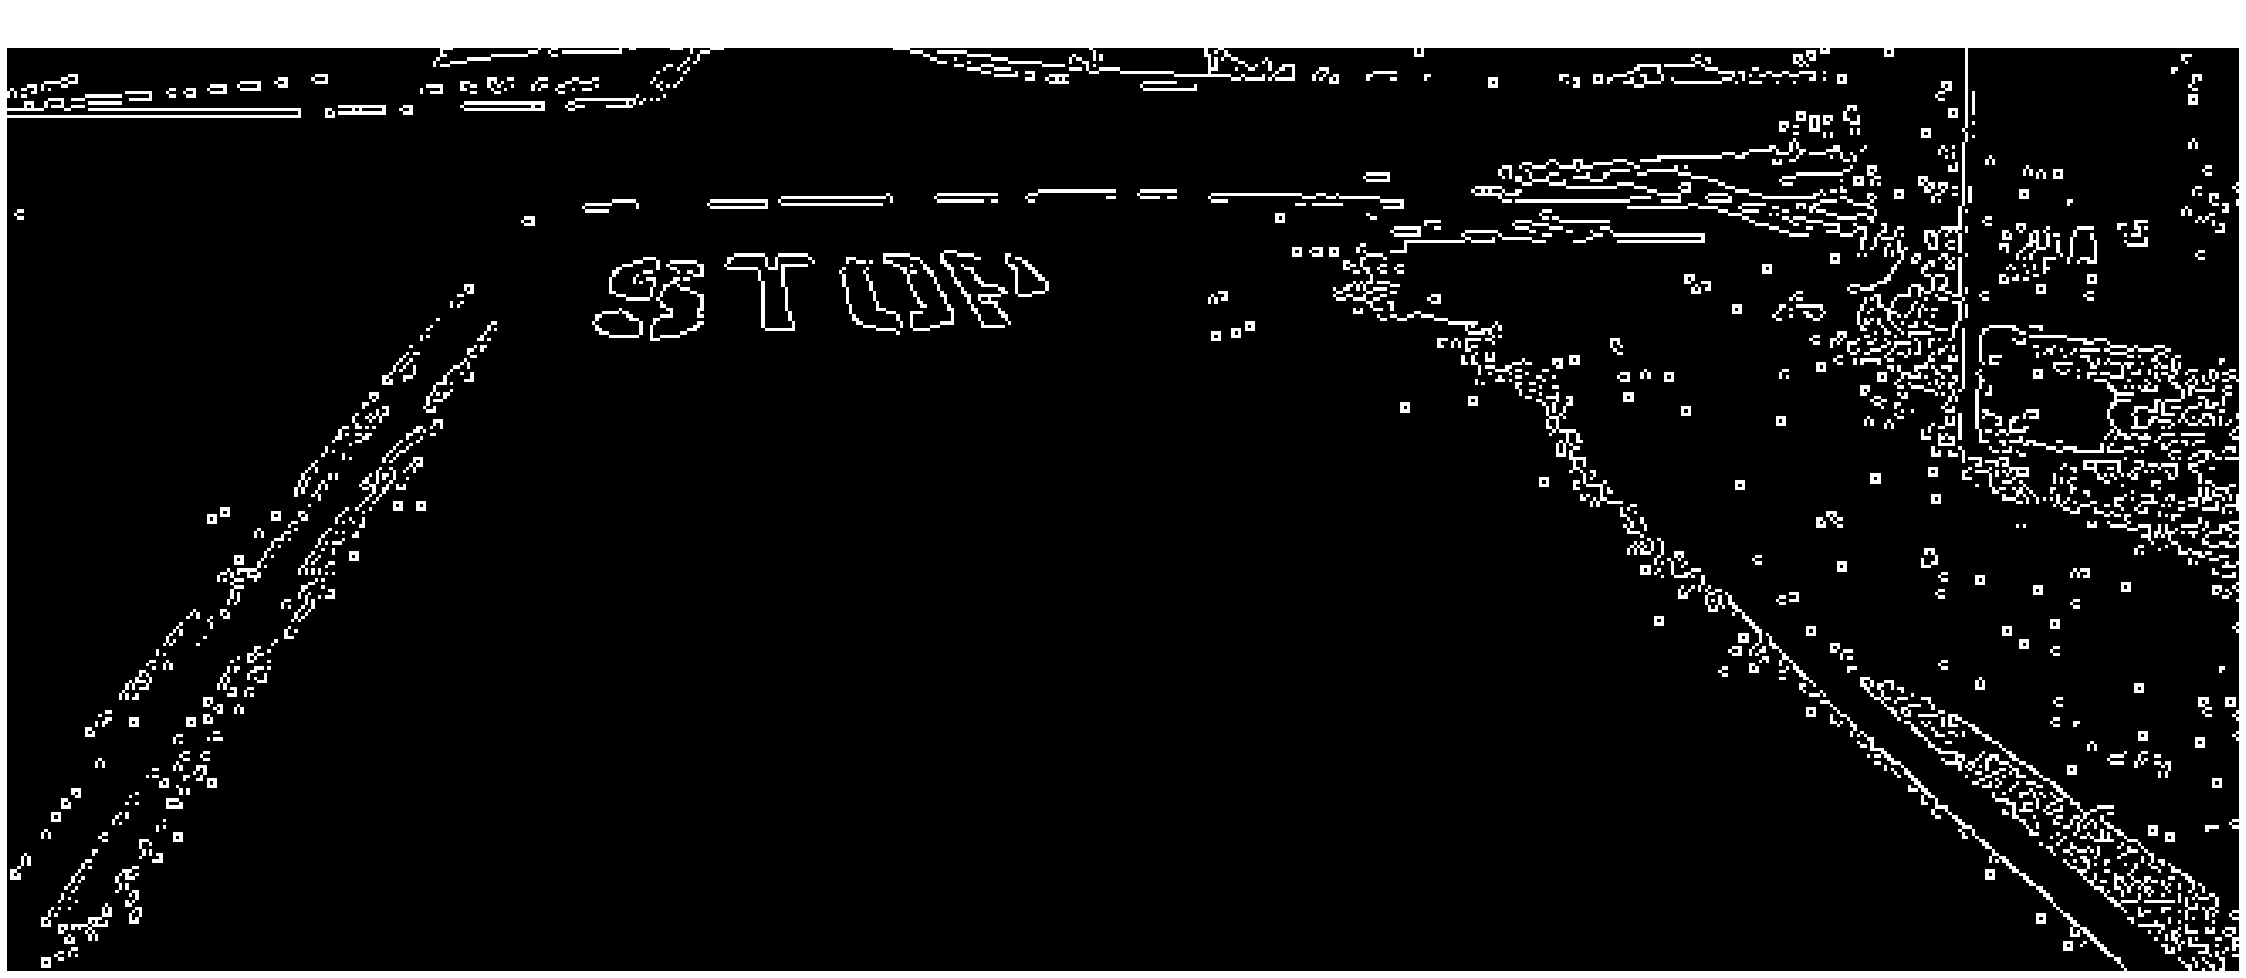

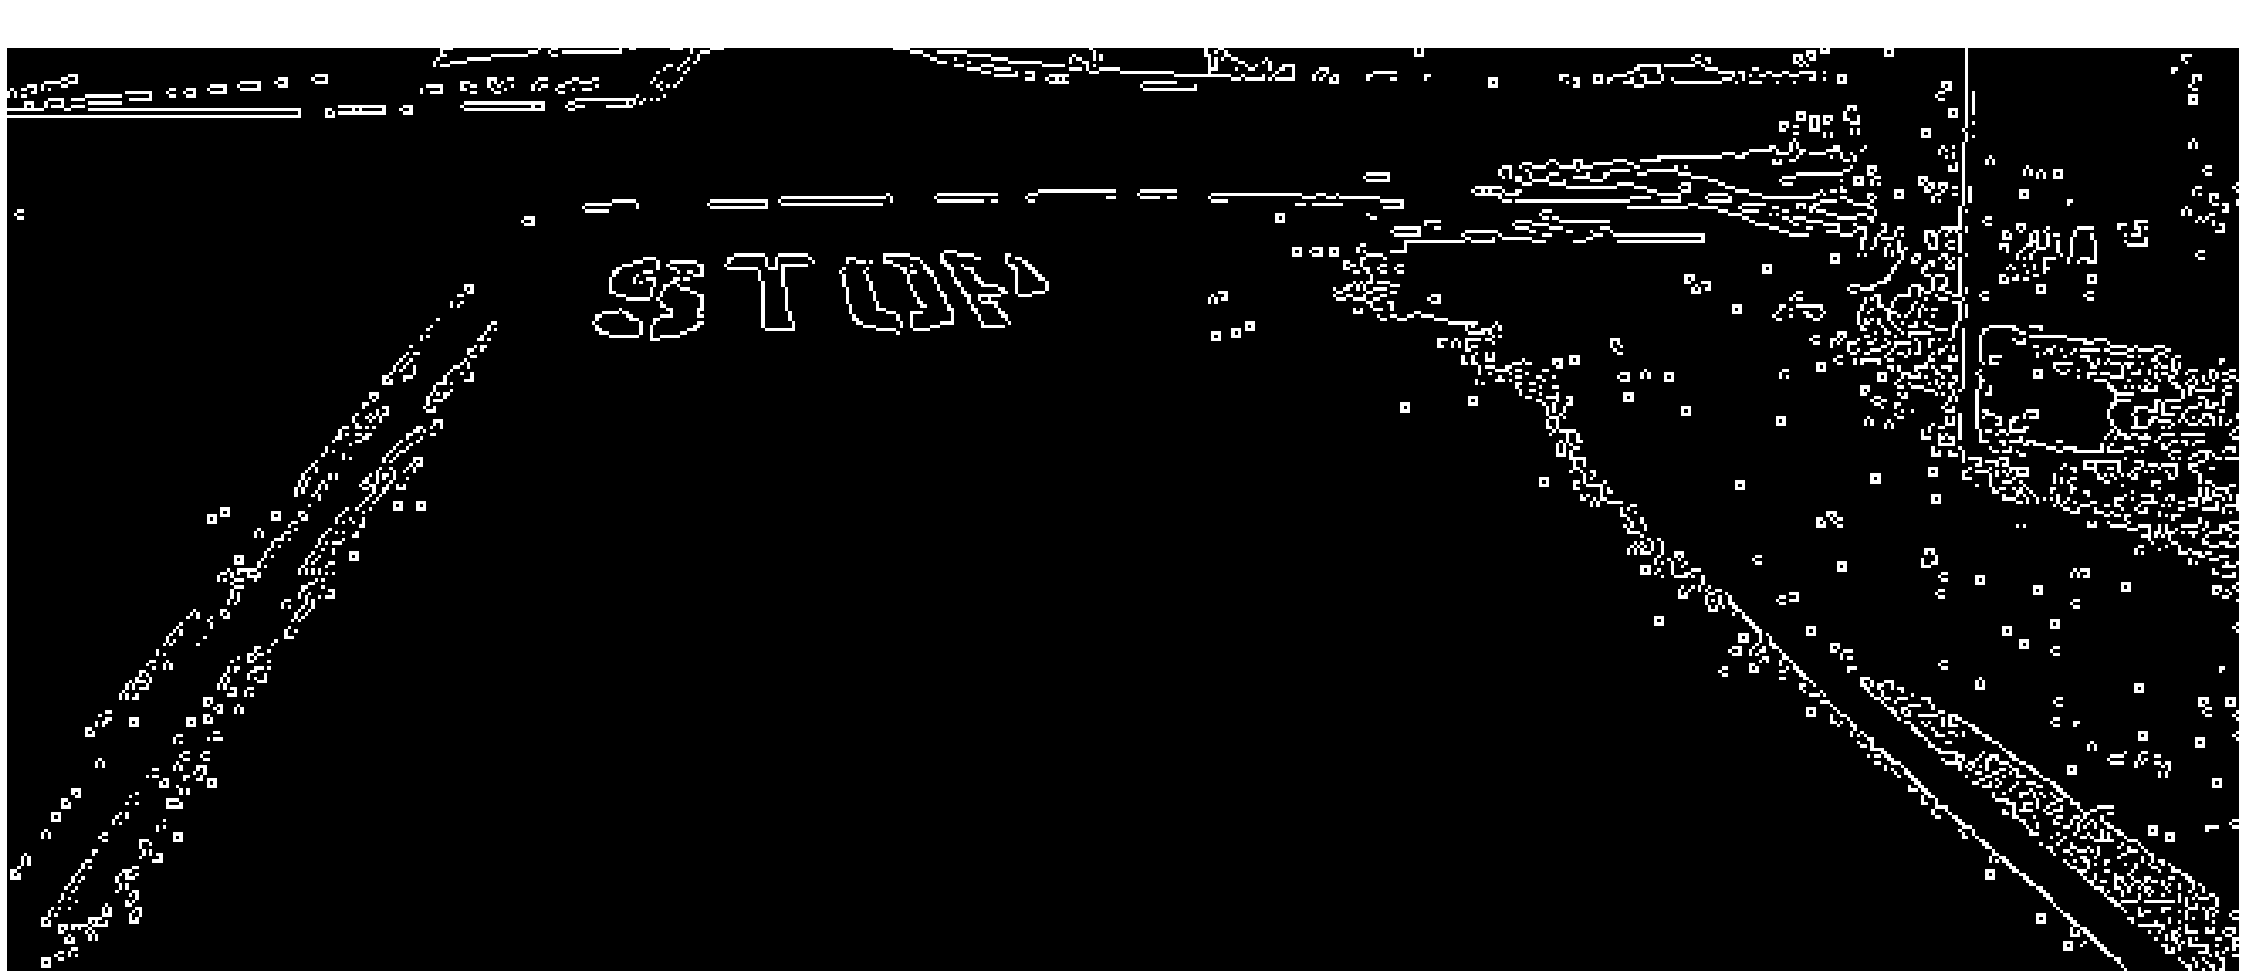

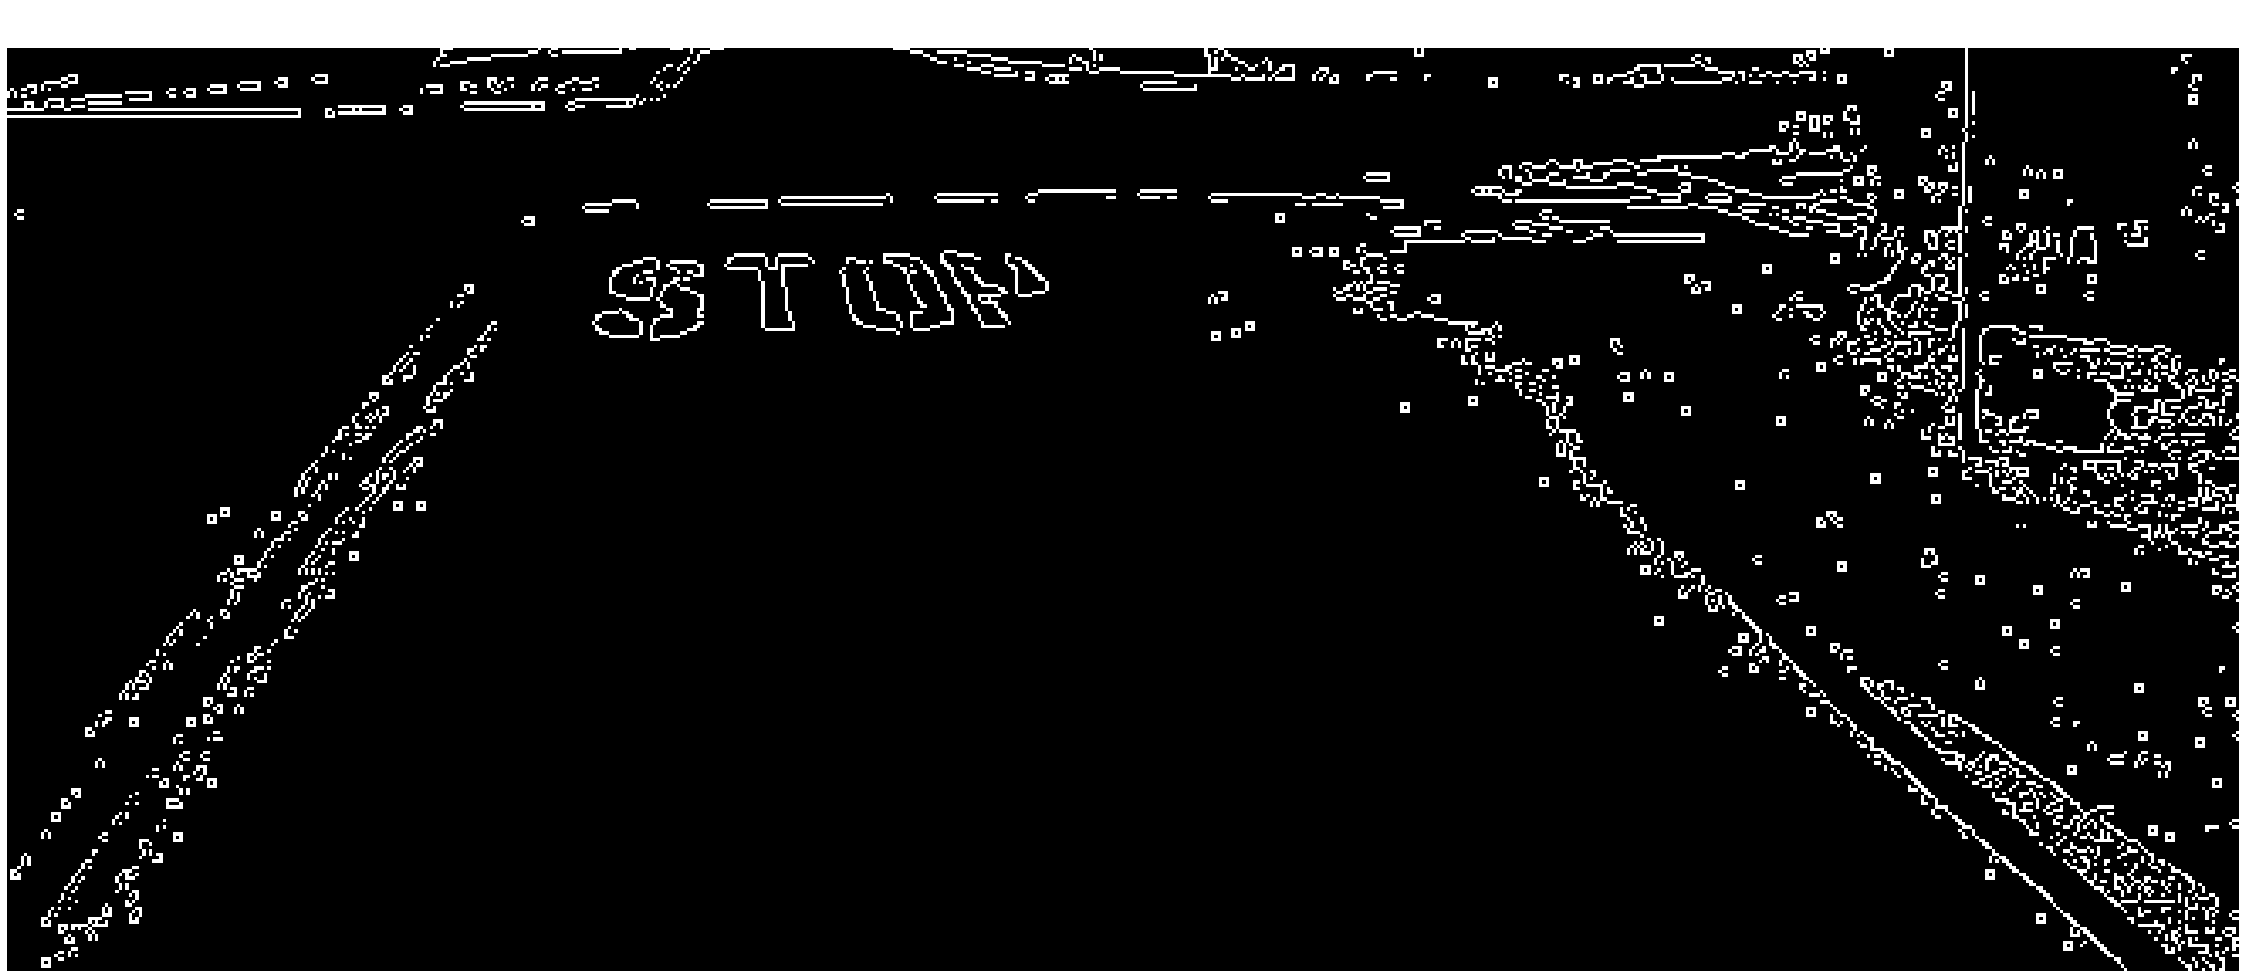

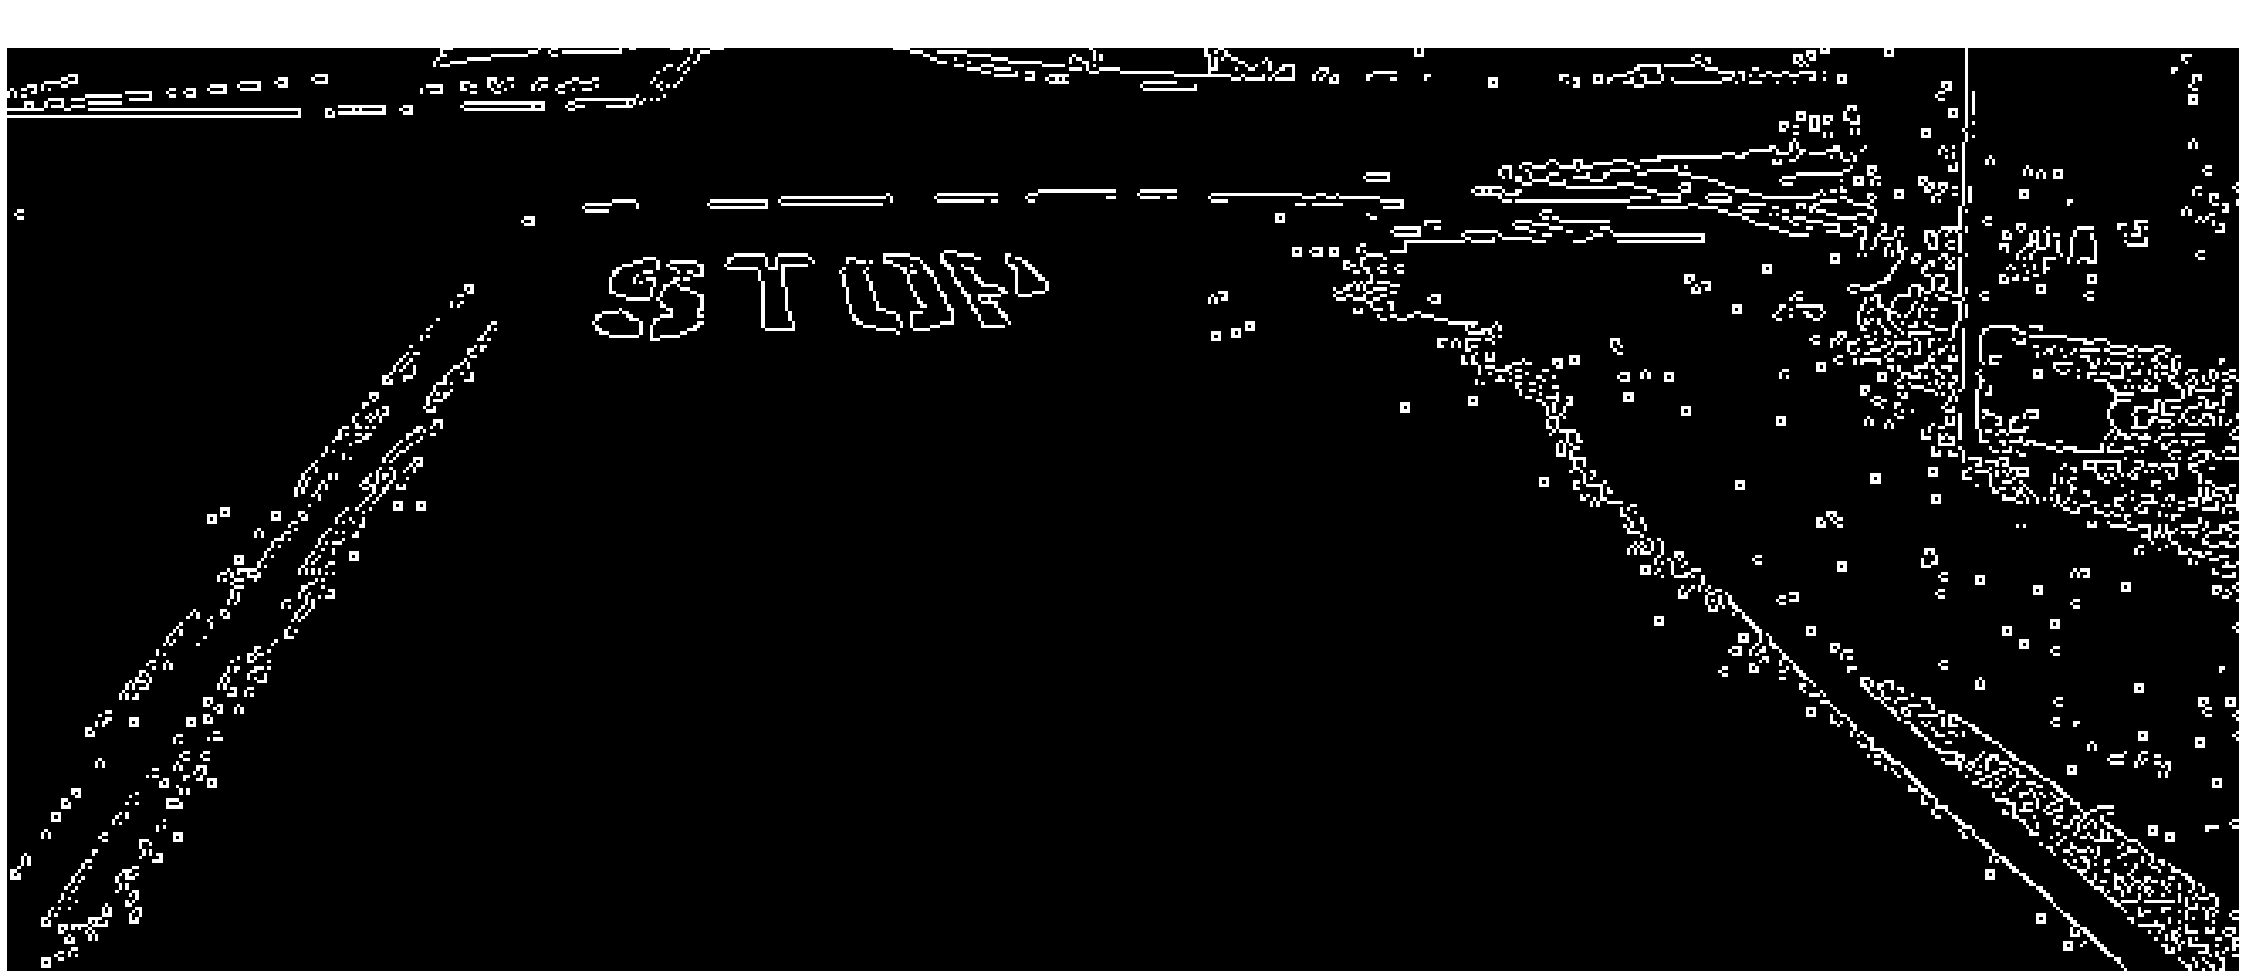

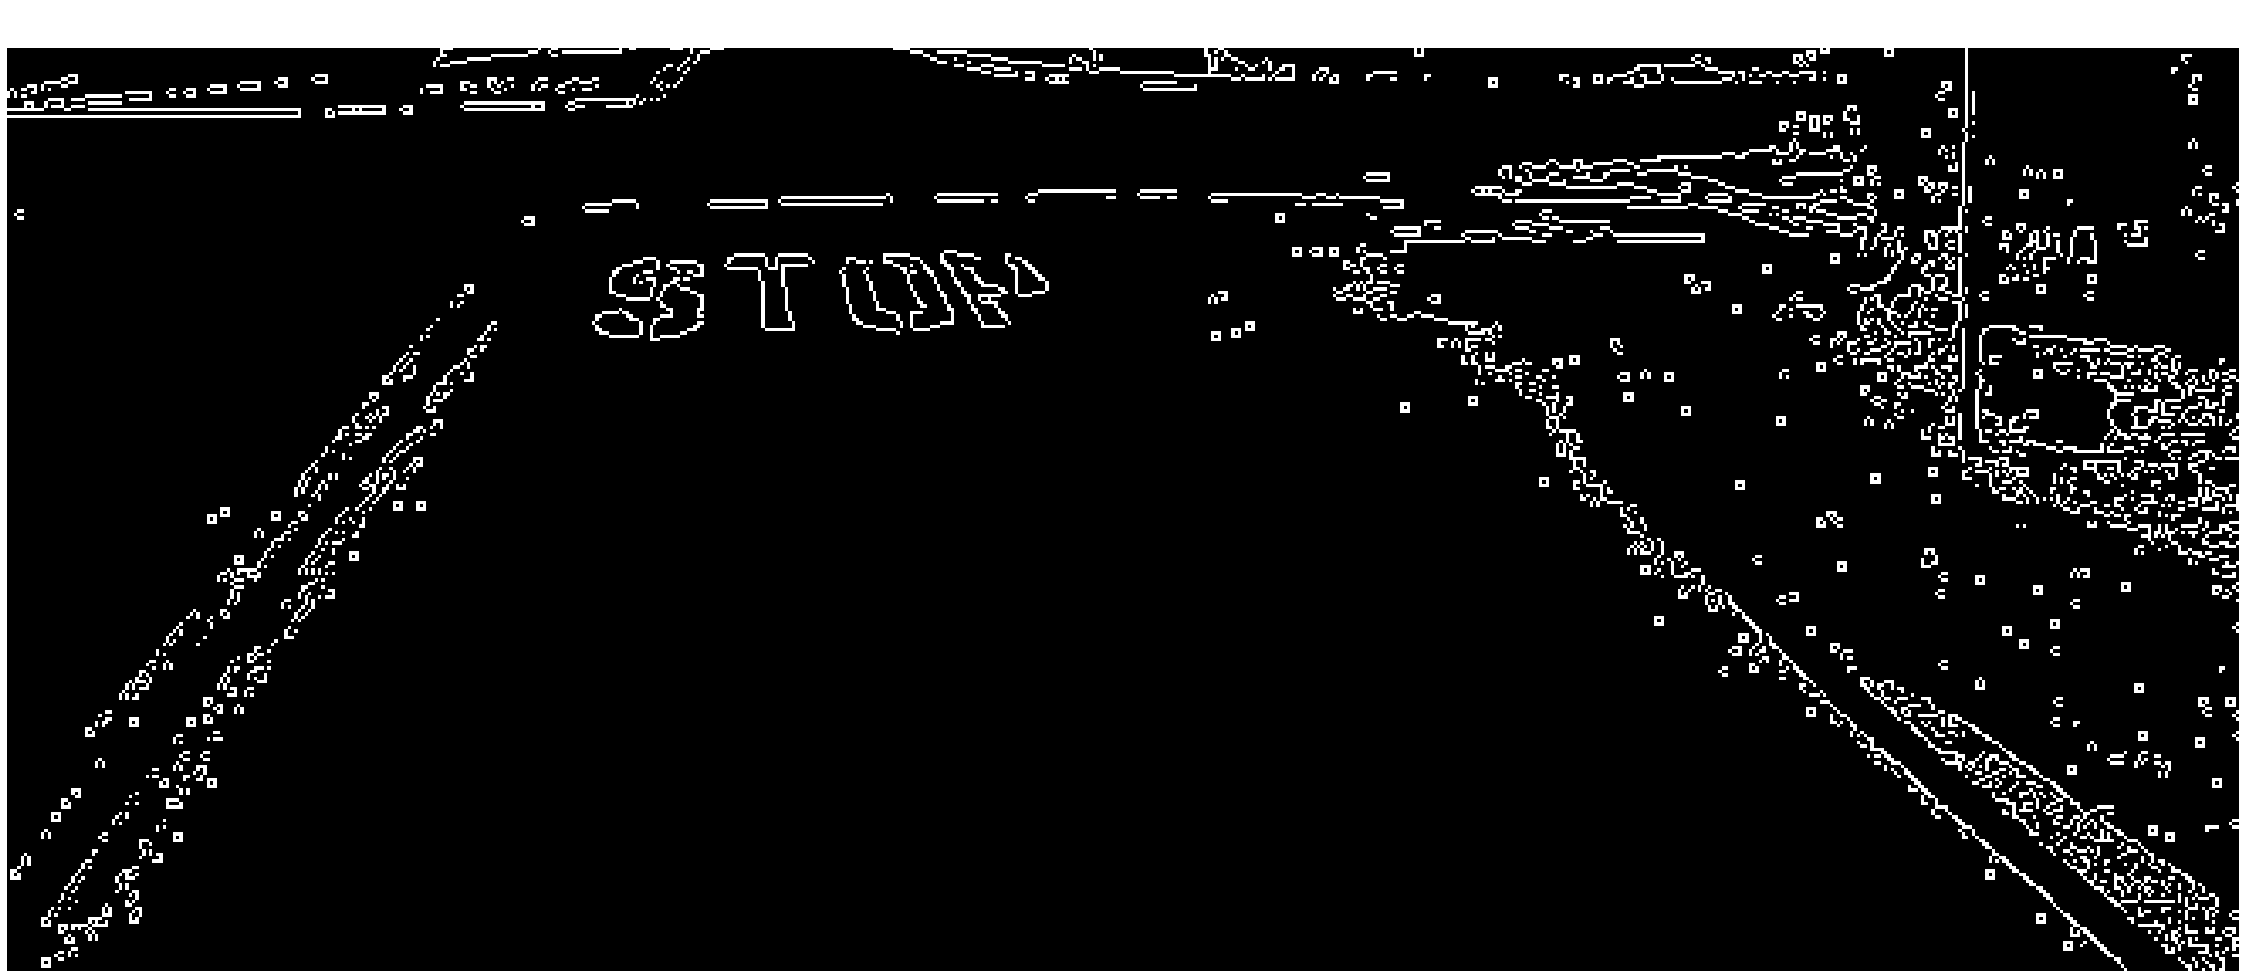

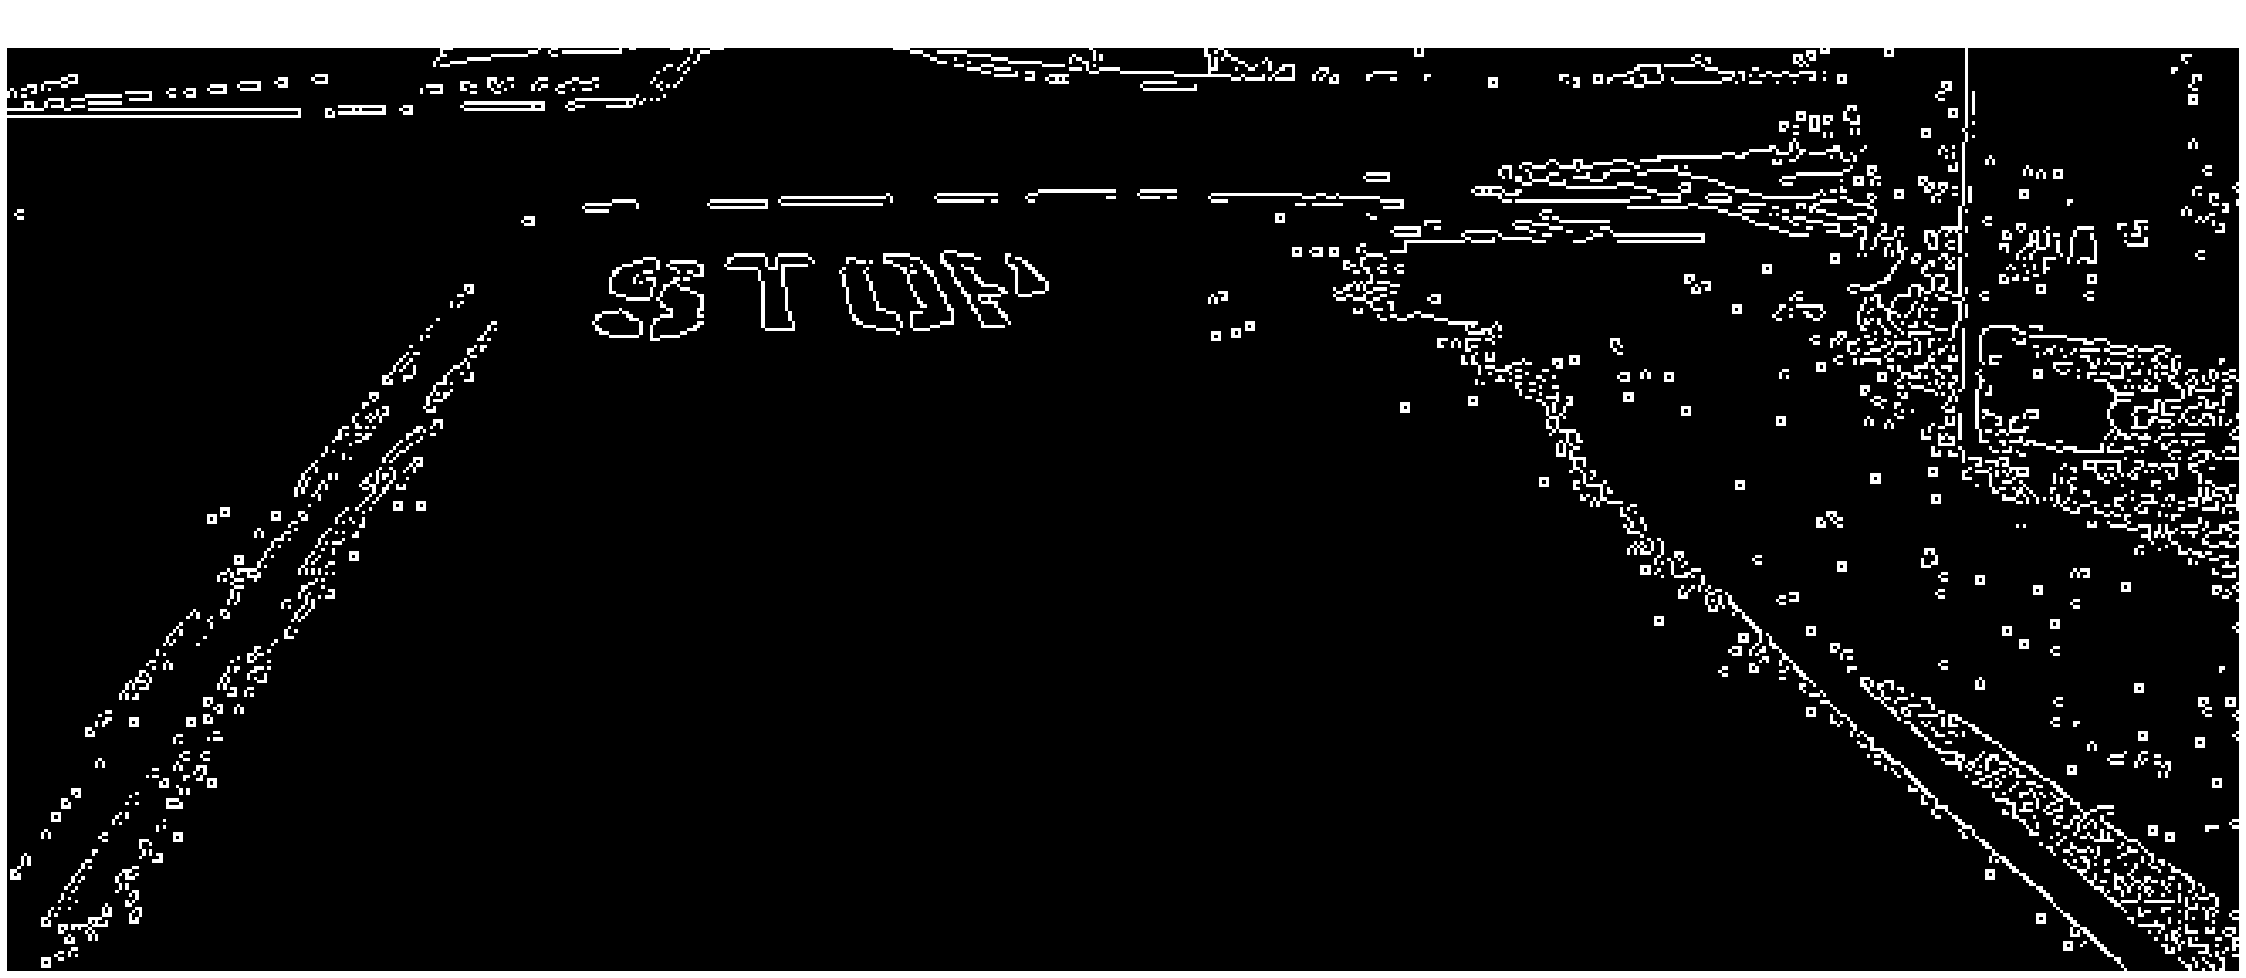

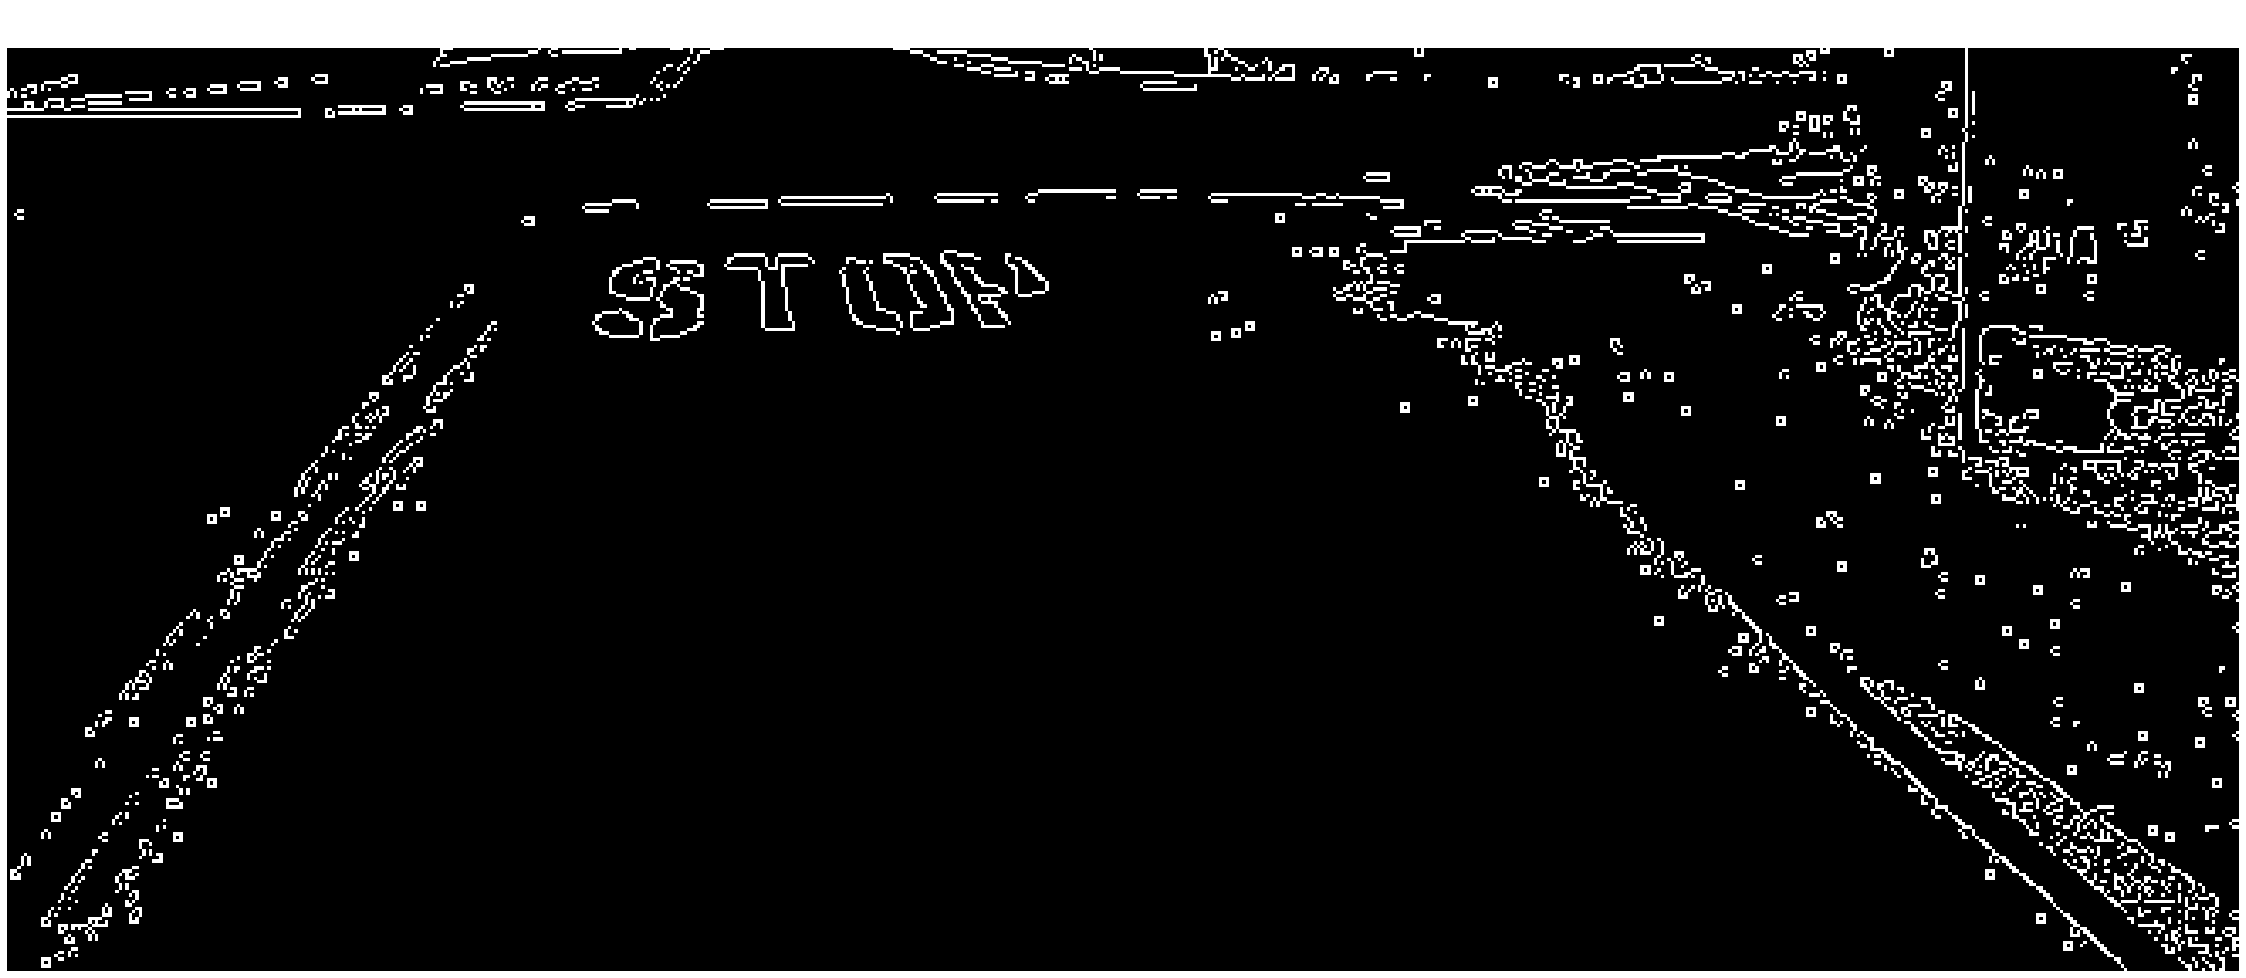

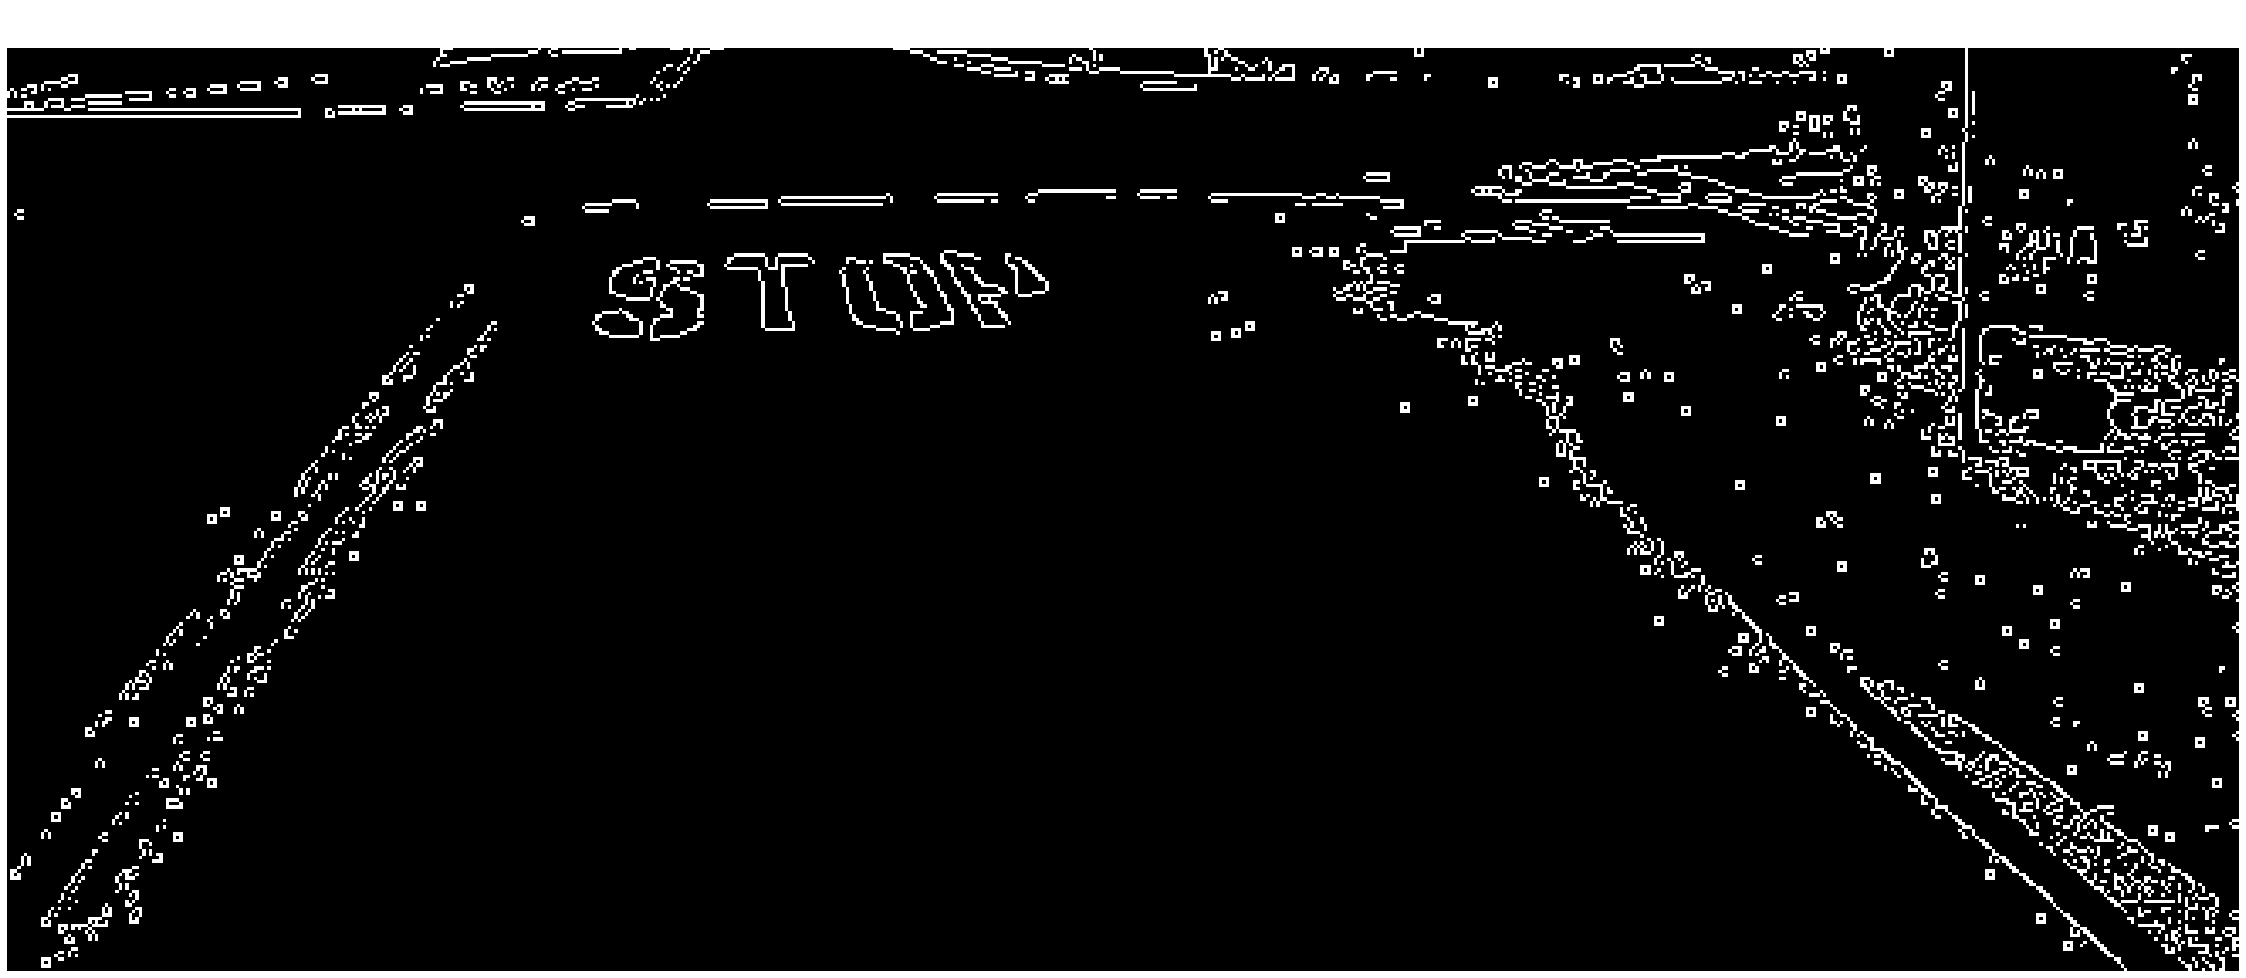

In [162]:
apply_kernels(read_images("lane5_stop"), max_dilation_kernel_size=5, max_blurring_kernel_size=7)